In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_5740/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


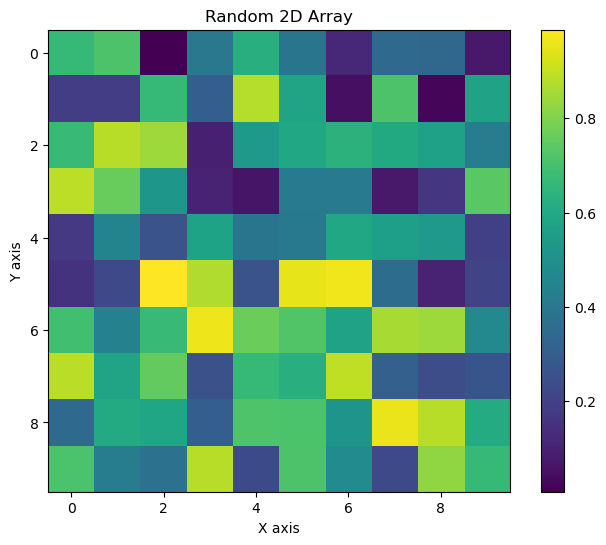

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################


            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################

                        
                        
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board ########################
# decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save


# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "4",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 8 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 34, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'NMNIST_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1,
#                 synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1,
#                 synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 1, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 1_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.
                
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# # dfa code from ASAP
# class feedback_receiver(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, input, weight_fb):
#         output = input.clone()
#         dummy = torch.Tensor(input.size()[0],weight_fb.size()[0]).zero_().to(input.device)
#         ctx.save_for_backward(weight_fb,)
#         ctx.shape = input.shape
#         return output, dummy
    
#     @staticmethod
#     def backward(ctx, grad_output, grad_dummy):
#         weight_fb, = ctx.saved_tensors
#         input_size = ctx.shape
#         grad_weight_fb = None
        
#         grad_input = torch.mm(grad_dummy.view(grad_dummy.size()[0],-1), weight_fb).view(input_size) # Batch_size, input
#         return grad_input, grad_weight_fb


# class Feedback_Receiver(nn.Module):
#     def __init__(self, connect_features):
#         super(Feedback_Receiver, self).__init__()
#         self.connect_features = connect_features
#         self.weight_fb = None
    
#     def forward(self, input):
#         if self.weight_fb is None:
#             self.weight_fb = nn.Parameter(torch.Tensor(self.connect_features, *input.size()[1:]).view(self.connect_features, -1)).to(input.device)
#             nn.init.normal_(self.weight_fb, std = math.sqrt(1./self.connect_features))
#         return feedback_receiver.apply(input, self.weight_fb)
   

In [7]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': 'my_snn_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
    'parameters': 
    {
        "learning_rate": {"min": 0.0001, "max": 0.01},
        "BATCH": {"values": [64,128,256,512]},
        "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
        "IMAGE_SIZE": {"values": [34]},
        "TIME": {"values": [5,6,7,8,9,10]},
        "epoch_num": {"values": [10]},
        "dvs_duration": {"values": [1_000,5_000,10_000,25_000]},
        "dvs_clipping": {"values": [0,1,2,4]},
        "which_data": {"values": ['NMNIST_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [True, False]},
        "surrogate": {"values": ['rectangle', 'sigmoid']},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate

    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "4",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = const2, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = const2, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',200,200], 
                cfg = [200,200],
                # cfg = [512], 
                # cfg = [64,128,'P',128,'P'], 
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.
                
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=10000)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 0bnqgi1u
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/0bnqgi1u


wandb: Agent Starting Run: ib8gotjz with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.004387764210522199
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:93.75%, lr=['0.004387764210522199'], iter_loss:0.5256019830703735, tr:89.59%, val:94.45%, val_best:94.45%: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]

epoch_time: 53.74532961845398 seconds

EPOCH 1



1-468/469 iter:96.88%, lr=['0.004280387977452999'], iter_loss:0.4599915146827698, tr:95.28%, val:95.95%, val_best:95.95%: 100%|██████████| 469/469 [00:51<00:00,  9.06it/s] 

epoch_time: 51.92849898338318 seconds

EPOCH 2



2-468/469 iter:96.88%, lr=['0.003968770012072417'], iter_loss:0.5629266500473022, tr:96.32%, val:95.57%, val_best:95.95%: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]  

epoch_time: 51.70493173599243 seconds

EPOCH 3



3-468/469 iter:98.96%, lr=['0.0034834136520019376'], iter_loss:0.8457728624343872, tr:97.00%, val:96.75%, val_best:96.75%: 100%|██████████| 469/469 [00:51<00:00,  9.18it/s]  

epoch_time: 51.27156925201416 seconds

EPOCH 4



4-468/469 iter:98.96%, lr=['0.002871828959441867'], iter_loss:0.4525752663612366, tr:97.52%, val:97.01%, val_best:97.01%: 100%|██████████| 469/469 [00:50<00:00,  9.21it/s]  

epoch_time: 51.114055156707764 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.0021938821052611'], iter_loss:0.35451483726501465, tr:98.00%, val:97.42%, val_best:97.42%: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s] 

epoch_time: 52.404695987701416 seconds

EPOCH 6



6-468/469 iter:98.96%, lr=['0.0015159352510803331'], iter_loss:0.4064052402973175, tr:98.28%, val:97.47%, val_best:97.47%: 100%|██████████| 469/469 [00:56<00:00,  8.31it/s]  

epoch_time: 56.62183594703674 seconds

EPOCH 7



7-468/469 iter:100.00%, lr=['0.0009043505585202625'], iter_loss:0.8829567432403564, tr:98.66%, val:97.57%, val_best:97.57%: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s] 

epoch_time: 53.372079849243164 seconds

EPOCH 8



8-468/469 iter:100.00%, lr=['0.0004189941984497831'], iter_loss:0.30111396312713623, tr:98.83%, val:97.66%, val_best:97.66%: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]

epoch_time: 53.39714813232422 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['0.00010737623306920093'], iter_loss:0.3946535587310791, tr:98.95%, val:97.70%, val_best:97.70%: 100%|██████████| 469/469 [00:56<00:00,  8.31it/s]  


epoch_time: 56.587738037109375 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▁▆▃▅▆▇▅▅▆▆▅▆▇▇██▇▇▆▆▆▆█▇█▇██▇███▇█▇███▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.98945
val_acc_best,0.977
val_acc_now,0.977


wandb: Agent Starting Run: repknrbk with config:
wandb: 	BATCH: 256
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 5000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.009900546813544776
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-234/235 iter:11.46%, lr=['0.009900546813544776'], iter_loss:2.3465144634246826, tr:10.99%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:11<00:00,  3.29it/s]

epoch_time: 71.5970950126648 seconds

EPOCH 1



1-234/235 iter:9.38%, lr=['0.009658263187725879'], iter_loss:2.327788829803467, tr:10.98%, val:10.10%, val_best:11.35%: 100%|██████████| 235/235 [01:13<00:00,  3.20it/s]  

epoch_time: 73.54082560539246 seconds

EPOCH 2



2-234/235 iter:15.62%, lr=['0.008955128719653618'], iter_loss:2.3001179695129395, tr:11.07%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:12<00:00,  3.23it/s]

epoch_time: 72.99473452568054 seconds

EPOCH 3



3-234/235 iter:8.33%, lr=['0.007859971110088817'], iter_loss:2.374009370803833, tr:11.19%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:12<00:00,  3.24it/s]  

epoch_time: 72.73845267295837 seconds

EPOCH 4



4-234/235 iter:6.25%, lr=['0.006479992016267423'], iter_loss:2.3169827461242676, tr:11.19%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s] 

epoch_time: 71.00280237197876 seconds

EPOCH 5



5-234/235 iter:13.54%, lr=['0.004950273406772388'], iter_loss:2.3855388164520264, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:10<00:00,  3.34it/s]

epoch_time: 70.57435131072998 seconds

EPOCH 6



6-234/235 iter:16.67%, lr=['0.0034205547972773536'], iter_loss:2.309544086456299, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:13<00:00,  3.21it/s] 

epoch_time: 73.40169858932495 seconds

EPOCH 7



7-234/235 iter:11.46%, lr=['0.00204057570345596'], iter_loss:2.331306219100952, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:12<00:00,  3.23it/s] 

epoch_time: 72.97411322593689 seconds

EPOCH 8



8-234/235 iter:10.42%, lr=['0.0009454180938911596'], iter_loss:2.307001829147339, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:13<00:00,  3.20it/s] 

epoch_time: 73.63856673240662 seconds

EPOCH 9



9-234/235 iter:13.54%, lr=['0.00024228362581889918'], iter_loss:2.3090553283691406, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 235/235 [01:11<00:00,  3.29it/s]


epoch_time: 71.61207866668701 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▃▁▆▃▅▃▃▃▂▄▅▄▄▄▄▅▅▄█▄▂▄▄▃▄▅▃▃▆▄▄▆▄▂▆▅▂▄▅▄
summary_val_acc,▁▁▁▁████▇▇▇▇████████████████████████████
tr_acc,▁▁▁▁████████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████▇▇▇▇████████████████████████████
epoch,9
iter_acc,0.13542
tr_acc,0.11237
val_acc_best,0.1135
val_acc_now,0.1135


wandb: Agent Starting Run: ywdjh4td with config:
wandb: 	BATCH: 512
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 5000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.009778290542192102
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-117/118 iter:11.46%, lr=['0.009778290542192102'], iter_loss:2.2962803840637207, tr:11.06%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:12<00:00,  1.63it/s]

epoch_time: 72.74553751945496 seconds

EPOCH 1



1-117/118 iter:8.33%, lr=['0.009538998740285586'], iter_loss:2.309279441833496, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:12<00:00,  1.63it/s]  

epoch_time: 72.63087248802185 seconds

EPOCH 2



2-117/118 iter:15.62%, lr=['0.008844546883380665'], iter_loss:2.311321973800659, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:12<00:00,  1.62it/s] 

epoch_time: 72.9683210849762 seconds

EPOCH 3



3-117/118 iter:8.33%, lr=['0.0077629127577617954'], iter_loss:2.360602855682373, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:11<00:00,  1.64it/s]  

epoch_time: 72.05316495895386 seconds

EPOCH 4



4-117/118 iter:6.25%, lr=['0.00639997424783264'], iter_loss:2.295020341873169, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:11<00:00,  1.66it/s]  

epoch_time: 71.25848412513733 seconds

EPOCH 5



5-117/118 iter:13.54%, lr=['0.004889145271096051'], iter_loss:2.3453447818756104, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:10<00:00,  1.67it/s]

epoch_time: 70.76939964294434 seconds

EPOCH 6



6-117/118 iter:16.67%, lr=['0.0033783162943594623'], iter_loss:2.3173062801361084, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

epoch_time: 69.45240712165833 seconds

EPOCH 7



7-117/118 iter:11.46%, lr=['0.0020153777844303072'], iter_loss:2.3163623809814453, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:10<00:00,  1.68it/s]

epoch_time: 70.24137854576111 seconds

EPOCH 8



8-117/118 iter:10.42%, lr=['0.0009337436588114367'], iter_loss:2.316382646560669, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:10<00:00,  1.67it/s] 

epoch_time: 70.70054030418396 seconds

EPOCH 9



9-117/118 iter:13.54%, lr=['0.00023929180190651673'], iter_loss:2.316129446029663, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 118/118 [01:10<00:00,  1.66it/s] 


epoch_time: 71.05146503448486 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▃▁▆▅▄▄▄▆▅▄▄▅▆▆▅▄▃▅▅▂▃▂▂▆▃▄▄▃▇▃▄█▆▆▅▅▆▅▅▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁████████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.13542
tr_acc,0.11237
val_acc_best,0.1135
val_acc_now,0.1135


wandb: Agent Starting Run: nwyzq9b2 with config:
wandb: 	BATCH: 256
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0021325146611914044
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-234/235 iter:90.62%, lr=['0.0021325146611914044'], iter_loss:0.8751188516616821, tr:67.88%, val:89.98%, val_best:89.98%: 100%|██████████| 235/235 [00:59<00:00,  3.93it/s]

epoch_time: 60.02907681465149 seconds

EPOCH 1



1-234/235 iter:95.83%, lr=['0.0020803283129062207'], iter_loss:0.7166659832000732, tr:91.61%, val:93.63%, val_best:93.63%: 100%|██████████| 235/235 [01:00<00:00,  3.90it/s]

epoch_time: 60.367658853530884 seconds

EPOCH 2



2-234/235 iter:94.79%, lr=['0.0019288776314244918'], iter_loss:0.5623180866241455, tr:94.19%, val:94.48%, val_best:94.48%: 100%|██████████| 235/235 [00:59<00:00,  3.94it/s]

epoch_time: 59.83310151100159 seconds

EPOCH 3



3-234/235 iter:96.88%, lr=['0.001692987664668596'], iter_loss:0.5655166506767273, tr:95.21%, val:95.38%, val_best:95.38%: 100%|██████████| 235/235 [00:59<00:00,  3.92it/s]

epoch_time: 60.08764457702637 seconds

EPOCH 4



4-234/235 iter:96.88%, lr=['0.0013957489661266408'], iter_loss:0.522381603717804, tr:95.91%, val:95.90%, val_best:95.90%: 100%|██████████| 235/235 [01:00<00:00,  3.91it/s] 

epoch_time: 60.212032318115234 seconds

EPOCH 5



5-234/235 iter:95.83%, lr=['0.0010662573305957022'], iter_loss:0.7429418563842773, tr:96.41%, val:96.18%, val_best:96.18%: 100%|██████████| 235/235 [01:01<00:00,  3.82it/s]

epoch_time: 61.61510372161865 seconds

EPOCH 6



6-234/235 iter:96.88%, lr=['0.0007367656950647638'], iter_loss:0.6588483452796936, tr:96.64%, val:96.24%, val_best:96.24%: 100%|██████████| 235/235 [00:58<00:00,  4.05it/s]

epoch_time: 58.28911757469177 seconds

EPOCH 7



7-234/235 iter:98.96%, lr=['0.00043952699652280864'], iter_loss:0.8030021786689758, tr:96.83%, val:96.32%, val_best:96.32%: 100%|██████████| 235/235 [00:57<00:00,  4.06it/s] 

epoch_time: 58.04366326332092 seconds

EPOCH 8



8-234/235 iter:96.88%, lr=['0.00020363702976691268'], iter_loss:0.7337967753410339, tr:96.95%, val:96.38%, val_best:96.38%: 100%|██████████| 235/235 [00:59<00:00,  3.95it/s]

epoch_time: 59.65654706954956 seconds

EPOCH 9



9-234/235 iter:98.96%, lr=['5.2186348285183854e-05'], iter_loss:0.49934810400009155, tr:97.06%, val:96.44%, val_best:96.44%: 100%|██████████| 235/235 [01:00<00:00,  3.88it/s]


epoch_time: 60.68007683753967 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▅▇▇▇▇▇█▇█████▇█████████████████████████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▆▆▆▆████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.97058
val_acc_best,0.9644
val_acc_now,0.9644


wandb: Agent Starting Run: b9dbbvmz with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0007145558825755494
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:89.58%, lr=['0.0007145558825755494'], iter_loss:0.5990020632743835, tr:71.92%, val:89.23%, val_best:89.23%: 100%|██████████| 469/469 [01:00<00:00,  7.73it/s]

epoch_time: 60.854633808135986 seconds

EPOCH 1



1-468/469 iter:94.79%, lr=['0.0006970694554780301'], iter_loss:0.5302623510360718, tr:90.73%, val:92.41%, val_best:92.41%: 100%|██████████| 469/469 [01:02<00:00,  7.49it/s]

epoch_time: 62.79538011550903 seconds

EPOCH 2



2-468/469 iter:93.75%, lr=['0.0006463218675048791'], iter_loss:0.3804953396320343, tr:93.05%, val:93.79%, val_best:93.79%: 100%|██████████| 469/469 [01:02<00:00,  7.56it/s]

epoch_time: 62.21284079551697 seconds

EPOCH 3



3-468/469 iter:92.71%, lr=['0.0005672806461461447'], iter_loss:0.14638568460941315, tr:94.17%, val:94.53%, val_best:94.53%: 100%|██████████| 469/469 [01:01<00:00,  7.66it/s]

epoch_time: 61.38549876213074 seconds

EPOCH 4



4-468/469 iter:95.83%, lr=['0.0004676828968609917'], iter_loss:0.42799806594848633, tr:94.92%, val:94.95%, val_best:94.95%: 100%|██████████| 469/469 [01:01<00:00,  7.58it/s]

epoch_time: 62.028000593185425 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.00035727794128777464'], iter_loss:0.37714558839797974, tr:95.44%, val:95.41%, val_best:95.41%: 100%|██████████| 469/469 [01:01<00:00,  7.67it/s]

epoch_time: 61.37515139579773 seconds

EPOCH 6



6-468/469 iter:95.83%, lr=['0.00024687298571455764'], iter_loss:0.4491906762123108, tr:95.68%, val:95.61%, val_best:95.61%: 100%|██████████| 469/469 [01:01<00:00,  7.60it/s] 

epoch_time: 61.86546540260315 seconds

EPOCH 7



7-468/469 iter:94.79%, lr=['0.0001472752364294047'], iter_loss:0.4038282334804535, tr:95.90%, val:95.66%, val_best:95.66%: 100%|██████████| 469/469 [01:00<00:00,  7.71it/s] 

epoch_time: 60.988651752471924 seconds

EPOCH 8



8-468/469 iter:95.83%, lr=['6.823401507067031e-05'], iter_loss:0.25385957956314087, tr:95.98%, val:95.74%, val_best:95.74%: 100%|██████████| 469/469 [01:01<00:00,  7.57it/s]

epoch_time: 62.1403124332428 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['1.7486427097519293e-05'], iter_loss:0.29515865445137024, tr:96.07%, val:95.72%, val_best:95.74%: 100%|██████████| 469/469 [01:01<00:00,  7.68it/s]


epoch_time: 61.23133587837219 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▅▆▇▇▇█▇▇▇█▇▇▇▇████▇▇▇▇▇▇█▇██████▇██████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▆▆▆▆████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.96068
val_acc_best,0.9574
val_acc_now,0.9572


wandb: Agent Starting Run: fwl6g6rf with config:
wandb: 	BATCH: 512
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0010124464869036575
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-117/118 iter:85.42%, lr=['0.0010124464869036575'], iter_loss:0.36584457755088806, tr:71.50%, val:87.02%, val_best:87.02%: 100%|██████████| 118/118 [00:49<00:00,  2.37it/s]

epoch_time: 49.89655828475952 seconds

EPOCH 1



1-117/118 iter:89.58%, lr=['0.0009876701578367586'], iter_loss:0.23756223917007446, tr:88.95%, val:90.97%, val_best:90.97%: 100%|██████████| 118/118 [00:50<00:00,  2.35it/s]

epoch_time: 50.351853370666504 seconds

EPOCH 2



2-117/118 iter:86.46%, lr=['0.0009157664503519646'], iter_loss:0.1557789146900177, tr:91.36%, val:92.40%, val_best:92.40%: 100%|██████████| 118/118 [00:49<00:00,  2.37it/s]

epoch_time: 49.86805558204651 seconds

EPOCH 3



3-117/118 iter:91.67%, lr=['0.000803773800320476'], iter_loss:0.1344577521085739, tr:92.66%, val:93.28%, val_best:93.28%: 100%|██████████| 118/118 [00:50<00:00,  2.33it/s]

epoch_time: 50.92017149925232 seconds

EPOCH 4



4-117/118 iter:93.75%, lr=['0.0006626548286260502'], iter_loss:0.12349265813827515, tr:93.42%, val:93.72%, val_best:93.72%: 100%|██████████| 118/118 [00:50<00:00,  2.35it/s]

epoch_time: 50.29361391067505 seconds

EPOCH 5



5-117/118 iter:95.83%, lr=['0.0005062232434518288'], iter_loss:0.13056787848472595, tr:93.91%, val:94.09%, val_best:94.09%: 100%|██████████| 118/118 [00:49<00:00,  2.38it/s]

epoch_time: 49.68776798248291 seconds

EPOCH 6



6-117/118 iter:92.71%, lr=['0.0003497916582776074'], iter_loss:0.09613119065761566, tr:94.25%, val:94.21%, val_best:94.21%: 100%|██████████| 118/118 [00:49<00:00,  2.40it/s]

epoch_time: 49.4284405708313 seconds

EPOCH 7



7-117/118 iter:96.88%, lr=['0.0002086726865831816'], iter_loss:0.12049593776464462, tr:94.41%, val:94.37%, val_best:94.37%: 100%|██████████| 118/118 [00:51<00:00,  2.31it/s]

epoch_time: 51.26373219490051 seconds

EPOCH 8



8-117/118 iter:91.67%, lr=['9.668003655169302e-05'], iter_loss:0.09912041574716568, tr:94.56%, val:94.50%, val_best:94.50%: 100%|██████████| 118/118 [00:52<00:00,  2.25it/s]

epoch_time: 52.576693058013916 seconds

EPOCH 9



9-117/118 iter:97.92%, lr=['2.4776329066899107e-05'], iter_loss:0.10531646013259888, tr:94.58%, val:94.36%, val_best:94.50%: 100%|██████████| 118/118 [00:51<00:00,  2.28it/s]


epoch_time: 51.88157343864441 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▅▆▆▇▇▇▇▇▇▇██▇██▇▇██████████████████████
summary_val_acc,▁▁▁▁▇▇▇▇████████████████████████████████
tr_acc,▁▁▁▁▆▆▆▆████████████████████████████████
val_acc_best,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▇▇▇▇████████████████████████████████
epoch,9
iter_acc,0.97917
tr_acc,0.94583
val_acc_best,0.945
val_acc_now,0.9436


wandb: Agent Starting Run: ouy5fukc with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0016356420322034978
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:91.67%, lr=['0.0016356420322034978'], iter_loss:0.7459911108016968, tr:86.80%, val:93.36%, val_best:93.36%: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]

epoch_time: 54.316890001297 seconds

EPOCH 1



1-468/469 iter:96.88%, lr=['0.0015956150226284409'], iter_loss:0.8816395998001099, tr:94.33%, val:95.42%, val_best:95.42%: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]

epoch_time: 53.51795673370361 seconds

EPOCH 2



2-468/469 iter:94.79%, lr=['0.0014794521164850512'], iter_loss:0.7368254661560059, tr:95.75%, val:95.46%, val_best:95.46%: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s] 

epoch_time: 53.449493169784546 seconds

EPOCH 3



3-468/469 iter:97.92%, lr=['0.0012985241483812022'], iter_loss:0.3623361885547638, tr:96.53%, val:96.30%, val_best:96.30%: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s] 

epoch_time: 54.034844636917114 seconds

EPOCH 4



4-468/469 iter:97.92%, lr=['0.001070541608434177'], iter_loss:0.6561340093612671, tr:97.10%, val:96.40%, val_best:96.40%: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]  

epoch_time: 53.698482275009155 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.000817821016101749'], iter_loss:0.4209655225276947, tr:97.47%, val:96.63%, val_best:96.63%: 100%|██████████| 469/469 [00:55<00:00,  8.41it/s]  

epoch_time: 55.97399950027466 seconds

EPOCH 6



6-468/469 iter:98.96%, lr=['0.0005651004237693211'], iter_loss:0.3323902189731598, tr:97.74%, val:96.89%, val_best:96.89%: 100%|██████████| 469/469 [00:56<00:00,  8.24it/s]  

epoch_time: 57.108372926712036 seconds

EPOCH 7



7-468/469 iter:100.00%, lr=['0.0003371178838222958'], iter_loss:0.5728675127029419, tr:97.99%, val:96.88%, val_best:96.89%: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s] 

epoch_time: 55.61778450012207 seconds

EPOCH 8



8-468/469 iter:98.96%, lr=['0.00015618991571844662'], iter_loss:0.2776104211807251, tr:98.12%, val:96.96%, val_best:96.96%: 100%|██████████| 469/469 [00:55<00:00,  8.47it/s]  

epoch_time: 55.57306933403015 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['4.0027009575056935e-05'], iter_loss:0.341939777135849, tr:98.20%, val:97.03%, val_best:97.03%: 100%|██████████| 469/469 [00:56<00:00,  8.36it/s]   


epoch_time: 56.31938695907593 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▆▄▅▇▇▅▆▆▇▇▇▇▇█▇▇▇▇▇▇▆█▇██▇█▇██▇▇█▇███▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.98197
val_acc_best,0.9703
val_acc_now,0.9703


wandb: Agent Starting Run: 08kjykva with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0012178551054434729
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0012178551054434729'], iter_loss:0.258926659822464, tr:88.86%, val:94.33%, val_best:94.33%: 100%|██████████| 938/938 [01:05<00:00, 14.22it/s]

epoch_time: 66.17978000640869 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0011880520696894046'], iter_loss:0.8278388381004333, tr:95.08%, val:95.42%, val_best:95.42%: 100%|██████████| 938/938 [01:04<00:00, 14.45it/s] 

epoch_time: 65.10989093780518 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.001101560291216768'], iter_loss:0.42141568660736084, tr:96.28%, val:96.21%, val_best:96.21%: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s] 

epoch_time: 65.80147194862366 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0009668461879261206'], iter_loss:0.5586810111999512, tr:96.97%, val:96.27%, val_best:96.27%: 100%|██████████| 938/938 [00:54<00:00, 17.09it/s] 

epoch_time: 55.052379846572876 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0007970965148558997'], iter_loss:0.5872645378112793, tr:97.59%, val:96.91%, val_best:96.91%: 100%|██████████| 938/938 [00:54<00:00, 17.32it/s] 

epoch_time: 54.3447790145874 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0006089275527217364'], iter_loss:0.6611031889915466, tr:97.90%, val:97.14%, val_best:97.14%: 100%|██████████| 938/938 [00:54<00:00, 17.11it/s] 

epoch_time: 54.97719430923462 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0004207585905875732'], iter_loss:0.4970359206199646, tr:98.21%, val:97.34%, val_best:97.34%: 100%|██████████| 938/938 [00:54<00:00, 17.21it/s] 

epoch_time: 54.670233964920044 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00025100891751735245'], iter_loss:0.39883795380592346, tr:98.47%, val:97.31%, val_best:97.34%: 100%|██████████| 938/938 [00:53<00:00, 17.41it/s]

epoch_time: 54.030280113220215 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00011629481422670496'], iter_loss:0.3229614794254303, tr:98.63%, val:97.44%, val_best:97.44%: 100%|██████████| 938/938 [00:53<00:00, 17.41it/s] 

epoch_time: 54.020039796829224 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.9803035754068352e-05'], iter_loss:0.42899930477142334, tr:98.68%, val:97.53%, val_best:97.53%: 100%|██████████| 938/938 [00:54<00:00, 17.35it/s]


epoch_time: 54.23136281967163 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▆▃▅▇▆▆█▆▇▆▇▇▇▇█▇▇▇▇▇▆▇▇██▇█▇██▇▇▇███▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98682
val_acc_best,0.9753
val_acc_now,0.9753


wandb: Agent Starting Run: tdufe68h with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0022867713528747433
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:93.75%, lr=['0.0022867713528747433'], iter_loss:0.4557616710662842, tr:90.18%, val:94.68%, val_best:94.68%: 100%|██████████| 938/938 [00:54<00:00, 17.29it/s]

epoch_time: 54.40938472747803 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.002230810074651676'], iter_loss:0.1225636675953865, tr:95.53%, val:95.97%, val_best:95.97%: 100%|██████████| 938/938 [00:54<00:00, 17.28it/s] 

epoch_time: 54.441752433776855 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0020684041198001'], iter_loss:0.3473846912384033, tr:96.67%, val:96.23%, val_best:96.23%: 100%|██████████| 938/938 [00:54<00:00, 17.30it/s]  

epoch_time: 54.40151500701904 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0018154509147297123'], iter_loss:0.10479691624641418, tr:97.27%, val:96.65%, val_best:96.65%: 100%|██████████| 938/938 [00:55<00:00, 16.77it/s]

epoch_time: 56.093334913253784 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0014967112815814144'], iter_loss:0.3135715126991272, tr:97.77%, val:96.91%, val_best:96.91%: 100%|██████████| 938/938 [00:55<00:00, 16.80it/s] 

epoch_time: 55.99888610839844 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0011433856764373716'], iter_loss:0.307886004447937, tr:98.23%, val:97.17%, val_best:97.17%: 100%|██████████| 938/938 [00:55<00:00, 16.96it/s]  

epoch_time: 55.46462440490723 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.000790060071293329'], iter_loss:0.5955858826637268, tr:98.57%, val:97.52%, val_best:97.52%: 100%|██████████| 938/938 [00:56<00:00, 16.72it/s] 

epoch_time: 56.261536836624146 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0004713204381450312'], iter_loss:0.39527422189712524, tr:98.82%, val:97.53%, val_best:97.53%: 100%|██████████| 938/938 [00:56<00:00, 16.68it/s]

epoch_time: 56.397114515304565 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.0002183672330746432'], iter_loss:0.3003600239753723, tr:99.01%, val:97.66%, val_best:97.66%: 100%|██████████| 938/938 [00:55<00:00, 16.80it/s] 

epoch_time: 55.982279777526855 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['5.5961278223067355e-05'], iter_loss:0.37069547176361084, tr:99.09%, val:97.60%, val_best:97.66%: 100%|██████████| 938/938 [00:55<00:00, 16.81it/s]


epoch_time: 55.94449996948242 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▃▃▆▆▅▇▅▆▆▆▇▇▇█▆▇▆▇▆▆▆▇████▆██▇▇▇███▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99093
val_acc_best,0.9766
val_acc_now,0.976


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s7gygerj with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0010683305174627338
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0010683305174627338'], iter_loss:0.2651446461677551, tr:88.68%, val:94.33%, val_best:94.33%: 100%|██████████| 938/938 [00:59<00:00, 15.89it/s]

epoch_time: 59.195441484451294 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0010421866088263202'], iter_loss:0.8146688938140869, tr:95.14%, val:95.59%, val_best:95.59%: 100%|██████████| 938/938 [00:57<00:00, 16.32it/s]  

epoch_time: 57.668296098709106 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.0009663140308497335'], iter_loss:0.3486531376838684, tr:96.31%, val:95.99%, val_best:95.99%: 100%|██████████| 938/938 [01:00<00:00, 15.42it/s]  

epoch_time: 60.992629289627075 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0008481397201006576'], iter_loss:0.41716229915618896, tr:97.09%, val:96.61%, val_best:96.61%: 100%|██████████| 938/938 [00:57<00:00, 16.34it/s]

epoch_time: 57.56503367424011 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.00069923140148405'], iter_loss:0.4597971737384796, tr:97.58%, val:96.90%, val_best:96.90%: 100%|██████████| 938/938 [00:58<00:00, 16.11it/s]  

epoch_time: 58.40621280670166 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0005341652587313669'], iter_loss:0.31028062105178833, tr:97.98%, val:97.04%, val_best:97.04%: 100%|██████████| 938/938 [00:56<00:00, 16.48it/s]

epoch_time: 57.08378052711487 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0003690991159786838'], iter_loss:0.10681196302175522, tr:98.30%, val:97.33%, val_best:97.33%: 100%|██████████| 938/938 [00:57<00:00, 16.28it/s]

epoch_time: 57.83625769615173 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00022019079736207629'], iter_loss:0.29025113582611084, tr:98.52%, val:97.44%, val_best:97.44%: 100%|██████████| 938/938 [00:57<00:00, 16.21it/s]

epoch_time: 58.030685901641846 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00010201648661300036'], iter_loss:0.2701496481895447, tr:98.68%, val:97.43%, val_best:97.44%: 100%|██████████| 938/938 [00:57<00:00, 16.29it/s] 

epoch_time: 57.76450181007385 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.6143908636413754e-05'], iter_loss:0.48137399554252625, tr:98.75%, val:97.43%, val_best:97.44%: 100%|██████████| 938/938 [00:59<00:00, 15.80it/s]


epoch_time: 59.52186942100525 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▃▁▅▃▅▆▇▆█▆▇▇▅▇▇▇█▇▇▇▇▇▆█▇█▇██▇██▇▅████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9875
val_acc_best,0.9744
val_acc_now,0.9743


wandb: Agent Starting Run: odjsr22x with config:
wandb: 	BATCH: 256
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0010284049515180017
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-234/235 iter:86.46%, lr=['0.0010284049515180017'], iter_loss:1.1019848585128784, tr:60.99%, val:84.87%, val_best:84.87%: 100%|██████████| 235/235 [01:11<00:00,  3.27it/s]

epoch_time: 72.1295554637909 seconds

EPOCH 1



1-234/235 iter:88.54%, lr=['0.0010032380910246993'], iter_loss:0.9112101197242737, tr:87.33%, val:90.10%, val_best:90.10%: 100%|██████████| 235/235 [00:59<00:00,  3.98it/s]

epoch_time: 59.22672653198242 seconds

EPOCH 2



2-234/235 iter:90.62%, lr=['0.0009302010171977044'], iter_loss:0.7446595430374146, tr:90.37%, val:91.48%, val_best:91.48%: 100%|██████████| 235/235 [01:01<00:00,  3.83it/s]

epoch_time: 61.43563723564148 seconds

EPOCH 3



3-234/235 iter:85.42%, lr=['0.0008164431077024194'], iter_loss:0.6301091909408569, tr:91.66%, val:92.57%, val_best:92.57%: 100%|██████████| 235/235 [00:58<00:00,  3.99it/s]

epoch_time: 59.05298185348511 seconds

EPOCH 4



4-234/235 iter:94.79%, lr=['0.000673099779318204'], iter_loss:0.6231718063354492, tr:92.42%, val:93.13%, val_best:93.13%: 100%|██████████| 235/235 [00:59<00:00,  3.98it/s]

epoch_time: 59.21678113937378 seconds

EPOCH 5



5-234/235 iter:92.71%, lr=['0.0005142024757590008'], iter_loss:0.46791961789131165, tr:93.04%, val:93.40%, val_best:93.40%: 100%|██████████| 235/235 [00:58<00:00,  4.02it/s]

epoch_time: 58.611860513687134 seconds

EPOCH 6



6-234/235 iter:90.62%, lr=['0.0003553051721997977'], iter_loss:0.5099713802337646, tr:93.36%, val:93.86%, val_best:93.86%: 100%|██████████| 235/235 [00:58<00:00,  4.00it/s]

epoch_time: 58.97558331489563 seconds

EPOCH 7



7-234/235 iter:92.71%, lr=['0.0002119618438155823'], iter_loss:0.7024479508399963, tr:93.52%, val:93.90%, val_best:93.90%: 100%|██████████| 235/235 [00:58<00:00,  4.02it/s]

epoch_time: 58.67511343955994 seconds

EPOCH 8



8-234/235 iter:93.75%, lr=['9.820393432029727e-05'], iter_loss:0.5963630676269531, tr:93.72%, val:93.90%, val_best:93.90%: 100%|██████████| 235/235 [01:01<00:00,  3.82it/s]

epoch_time: 61.71864032745361 seconds

EPOCH 9



9-234/235 iter:96.88%, lr=['2.516686049330237e-05'], iter_loss:0.5154250860214233, tr:93.75%, val:93.95%, val_best:93.95%: 100%|██████████| 235/235 [00:58<00:00,  4.01it/s]


epoch_time: 58.75302505493164 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▆▆▇▇▇▇▇█▇▇▇▇▇█▇██▇▇███▇███████████████
summary_val_acc,▁▁▁▁▇▇▇▇████████████████████████████████
tr_acc,▁▁▁▁▆▆▆▆████████████████████████████████
val_acc_best,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▇▇▇▇████████████████████████████████
epoch,9
iter_acc,0.96875
tr_acc,0.93755
val_acc_best,0.9395
val_acc_now,0.9395


wandb: Agent Starting Run: 7pbhh8ml with config:
wandb: 	BATCH: 256
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0012794299797575907
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-234/235 iter:90.62%, lr=['0.0012794299797575907'], iter_loss:0.960742175579071, tr:80.44%, val:91.23%, val_best:91.23%: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s]

epoch_time: 52.359697580337524 seconds

EPOCH 1



1-234/235 iter:93.75%, lr=['0.0012481200995747119'], iter_loss:0.7212669253349304, tr:92.12%, val:93.89%, val_best:93.89%: 100%|██████████| 235/235 [00:53<00:00,  4.39it/s]

epoch_time: 53.71822762489319 seconds

EPOCH 2



2-234/235 iter:94.79%, lr=['0.0011572552882471382'], iter_loss:0.8552184104919434, tr:94.08%, val:94.51%, val_best:94.51%: 100%|██████████| 235/235 [00:49<00:00,  4.74it/s]

epoch_time: 49.7904748916626 seconds

EPOCH 3



3-234/235 iter:96.88%, lr=['0.0010157300265999799'], iter_loss:0.5225667357444763, tr:94.97%, val:95.20%, val_best:95.20%: 100%|██████████| 235/235 [00:49<00:00,  4.71it/s]

epoch_time: 50.04056429862976 seconds

EPOCH 4



4-234/235 iter:95.83%, lr=['0.0008373977933077405'], iter_loss:0.9122239351272583, tr:95.57%, val:95.49%, val_best:95.49%: 100%|██████████| 235/235 [00:49<00:00,  4.75it/s]

epoch_time: 49.62054085731506 seconds

EPOCH 5



5-234/235 iter:94.79%, lr=['0.0006397149898787952'], iter_loss:0.5852230191230774, tr:96.02%, val:95.85%, val_best:95.85%: 100%|██████████| 235/235 [00:49<00:00,  4.77it/s]

epoch_time: 49.480443716049194 seconds

EPOCH 6



6-234/235 iter:93.75%, lr=['0.0004420321864498501'], iter_loss:0.5332804918289185, tr:96.28%, val:95.86%, val_best:95.86%: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]

epoch_time: 51.0539116859436 seconds

EPOCH 7



7-234/235 iter:97.92%, lr=['0.0002636999531576108'], iter_loss:0.815514862537384, tr:96.45%, val:95.96%, val_best:95.96%: 100%|██████████| 235/235 [00:50<00:00,  4.64it/s] 

epoch_time: 50.771204233169556 seconds

EPOCH 8



8-234/235 iter:98.96%, lr=['0.00012217469151045248'], iter_loss:0.39618775248527527, tr:96.62%, val:95.97%, val_best:95.97%: 100%|██████████| 235/235 [00:49<00:00,  4.73it/s]

epoch_time: 49.84724044799805 seconds

EPOCH 9



9-234/235 iter:98.96%, lr=['3.130988018287885e-05'], iter_loss:0.4858138859272003, tr:96.63%, val:96.02%, val_best:96.02%: 100%|██████████| 235/235 [00:50<00:00,  4.70it/s]


epoch_time: 50.20697498321533 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▅▅▆▆▆▆▆█▆█▇▇▇▇▇██▇▇█▇█▇▇█▇▇██▇█▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.96632
val_acc_best,0.9602
val_acc_now,0.9602


wandb: Agent Starting Run: 4bt7mkql with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0024624071273671743
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0024624071273671743'], iter_loss:0.16869616508483887, tr:90.63%, val:95.77%, val_best:95.77%: 100%|██████████| 938/938 [00:56<00:00, 16.69it/s]

epoch_time: 56.36461424827576 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.002402147735810678'], iter_loss:0.27367234230041504, tr:96.17%, val:96.70%, val_best:96.70%: 100%|██████████| 938/938 [00:56<00:00, 16.55it/s]

epoch_time: 56.863017320632935 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.0022272681702386068'], iter_loss:0.1791677176952362, tr:97.12%, val:96.80%, val_best:96.80%: 100%|██████████| 938/938 [00:56<00:00, 16.62it/s]  

epoch_time: 56.584681034088135 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.001954886860986736'], iter_loss:0.33099421858787537, tr:97.64%, val:97.25%, val_best:97.25%: 100%|██████████| 938/938 [00:58<00:00, 16.17it/s]

epoch_time: 58.202234983444214 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0016116663883968133'], iter_loss:1.1202071905136108, tr:98.17%, val:97.21%, val_best:97.25%: 100%|██████████| 938/938 [01:01<00:00, 15.32it/s] 

epoch_time: 61.37048816680908 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.001231203563683587'], iter_loss:0.6184868216514587, tr:98.49%, val:97.72%, val_best:97.72%: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s] 

epoch_time: 62.05353617668152 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0008507407389703608'], iter_loss:0.5287852883338928, tr:98.85%, val:97.75%, val_best:97.75%: 100%|██████████| 938/938 [01:00<00:00, 15.56it/s] 

epoch_time: 60.43505024909973 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0005075202663804379'], iter_loss:0.47328293323516846, tr:99.12%, val:97.85%, val_best:97.85%: 100%|██████████| 938/938 [00:59<00:00, 15.83it/s]

epoch_time: 59.43300175666809 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00023513895712856737'], iter_loss:0.4892933964729309, tr:99.26%, val:97.85%, val_best:97.85%: 100%|██████████| 938/938 [00:57<00:00, 16.28it/s] 

epoch_time: 57.78144693374634 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['6.0259391556496536e-05'], iter_loss:0.6127215623855591, tr:99.37%, val:97.91%, val_best:97.91%: 100%|██████████| 938/938 [00:59<00:00, 15.88it/s] 


epoch_time: 59.23342847824097 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▄▁▄▅▄▆▄▅█▅▆▅▆█▇███▇▇▇▇▅█▇████▆██▆▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99367
val_acc_best,0.9791
val_acc_now,0.9791


wandb: Agent Starting Run: q6maypjd with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.000967825885371966
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.000967825885371966'], iter_loss:0.34067538380622864, tr:88.47%, val:93.97%, val_best:93.97%: 100%|██████████| 938/938 [00:58<00:00, 16.09it/s]

epoch_time: 58.47064805030823 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0009441415001470504'], iter_loss:0.2525768280029297, tr:94.72%, val:95.51%, val_best:95.51%: 100%|██████████| 938/938 [00:57<00:00, 16.41it/s]

epoch_time: 57.340534687042236 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0008754067371169333'], iter_loss:0.40098705887794495, tr:96.05%, val:95.97%, val_best:95.97%: 100%|██████████| 938/938 [00:56<00:00, 16.58it/s]

epoch_time: 56.7374849319458 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0007683498337902568'], iter_loss:0.4375319182872772, tr:96.80%, val:96.26%, val_best:96.26%: 100%|██████████| 938/938 [00:58<00:00, 16.02it/s]  

epoch_time: 58.728081941604614 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0006334502657739418'], iter_loss:0.42647993564605713, tr:97.27%, val:96.76%, val_best:96.76%: 100%|██████████| 938/938 [01:01<00:00, 15.28it/s]

epoch_time: 61.54607033729553 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0004839129426859831'], iter_loss:0.33673444390296936, tr:97.65%, val:96.98%, val_best:96.98%: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]

epoch_time: 61.749130725860596 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00033437561959802445'], iter_loss:0.25475767254829407, tr:97.97%, val:97.22%, val_best:97.22%: 100%|██████████| 938/938 [00:58<00:00, 16.15it/s]

epoch_time: 58.24043345451355 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0001994760515817095'], iter_loss:0.47049903869628906, tr:98.21%, val:97.34%, val_best:97.34%: 100%|██████████| 938/938 [00:58<00:00, 15.96it/s]

epoch_time: 58.93622875213623 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['9.241914825503291e-05'], iter_loss:0.38041770458221436, tr:98.36%, val:97.27%, val_best:97.34%: 100%|██████████| 938/938 [00:56<00:00, 16.49it/s]

epoch_time: 57.04265832901001 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.368438522491572e-05'], iter_loss:0.4557446837425232, tr:98.45%, val:97.35%, val_best:97.35%: 100%|██████████| 938/938 [00:56<00:00, 16.55it/s] 


epoch_time: 56.847142696380615 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▁▆▃▃▆▅▃▇▅▆▆▆▆▇▇█▆▆▇▆▆▅█▇████▆██▅▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98447
val_acc_best,0.9735
val_acc_now,0.9735


wandb: Agent Starting Run: mdiajo3b with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0010963257949630615
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0010963257949630615'], iter_loss:0.48608386516571045, tr:88.62%, val:94.42%, val_best:94.42%: 100%|██████████| 938/938 [00:56<00:00, 16.63it/s]

epoch_time: 56.560988903045654 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.001069496793122573'], iter_loss:0.39112383127212524, tr:95.00%, val:95.69%, val_best:95.69%: 100%|██████████| 938/938 [01:10<00:00, 13.28it/s]

epoch_time: 70.78766512870789 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0009916359972299011'], iter_loss:0.14851659536361694, tr:96.22%, val:96.12%, val_best:96.12%: 100%|██████████| 938/938 [00:56<00:00, 16.63it/s] 

epoch_time: 56.55173873901367 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0008703649644750854'], iter_loss:0.5179886817932129, tr:96.93%, val:96.50%, val_best:96.50%: 100%|██████████| 938/938 [00:56<00:00, 16.67it/s] 

epoch_time: 56.464515924453735 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0007175545484891359'], iter_loss:0.7213897705078125, tr:97.45%, val:96.76%, val_best:96.76%: 100%|██████████| 938/938 [00:56<00:00, 16.66it/s]  

epoch_time: 56.46659803390503 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0005481628974815308'], iter_loss:1.0911675691604614, tr:97.84%, val:97.07%, val_best:97.07%: 100%|██████████| 938/938 [01:01<00:00, 15.35it/s] 

epoch_time: 61.244816064834595 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0003787712464739257'], iter_loss:0.3770145773887634, tr:98.10%, val:97.33%, val_best:97.33%: 100%|██████████| 938/938 [00:58<00:00, 16.02it/s] 

epoch_time: 58.70782446861267 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00022596083048797617'], iter_loss:0.5203827023506165, tr:98.38%, val:97.35%, val_best:97.35%: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s] 

epoch_time: 61.819363832473755 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00010468979773316036'], iter_loss:0.29627305269241333, tr:98.53%, val:97.48%, val_best:97.48%: 100%|██████████| 938/938 [00:59<00:00, 15.81it/s]

epoch_time: 59.53482508659363 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.6829001840488726e-05'], iter_loss:0.11395885050296783, tr:98.63%, val:97.37%, val_best:97.48%: 100%|██████████| 938/938 [00:59<00:00, 15.78it/s]


epoch_time: 59.6112277507782 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▂▅▇▅▆█▅▇▆▅██▇██▇▇▇▇▅█▇▇▇██▇██▅▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98633
val_acc_best,0.9748
val_acc_now,0.9737


wandb: Agent Starting Run: 9btiwpql with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.00046292174550841247
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:87.50%, lr=['0.00046292174550841247'], iter_loss:1.1390944719314575, tr:56.82%, val:83.51%, val_best:83.51%: 100%|██████████| 469/469 [01:00<00:00,  7.69it/s]

epoch_time: 61.18094873428345 seconds

EPOCH 1



1-468/469 iter:90.62%, lr=['0.00045159324405445744'], iter_loss:0.7557483911514282, tr:87.17%, val:89.89%, val_best:89.89%: 100%|██████████| 469/469 [01:00<00:00,  7.71it/s]

epoch_time: 61.036115884780884 seconds

EPOCH 2



2-468/469 iter:90.62%, lr=['0.0004187166523452163'], iter_loss:0.7822341918945312, tr:90.54%, val:91.54%, val_best:91.54%: 100%|██████████| 469/469 [01:01<00:00,  7.59it/s]

epoch_time: 61.93535923957825 seconds

EPOCH 3



3-468/469 iter:88.54%, lr=['0.00036751016024187336'], iter_loss:0.600657045841217, tr:91.79%, val:92.66%, val_best:92.66%: 100%|██████████| 469/469 [01:01<00:00,  7.68it/s] 

epoch_time: 61.25373911857605 seconds

EPOCH 4



4-468/469 iter:93.75%, lr=['0.0003029862159681132'], iter_loss:0.6614649295806885, tr:92.74%, val:93.36%, val_best:93.36%: 100%|██████████| 469/469 [01:01<00:00,  7.61it/s]

epoch_time: 61.802000522613525 seconds

EPOCH 5



5-468/469 iter:93.75%, lr=['0.0002314608727542062'], iter_loss:0.6088502407073975, tr:93.32%, val:93.63%, val_best:93.63%: 100%|██████████| 469/469 [01:00<00:00,  7.72it/s]

epoch_time: 60.9597065448761 seconds

EPOCH 6



6-468/469 iter:91.67%, lr=['0.00015993552954029927'], iter_loss:0.5973581075668335, tr:93.63%, val:93.90%, val_best:93.90%: 100%|██████████| 469/469 [01:00<00:00,  7.82it/s]

epoch_time: 60.176735401153564 seconds

EPOCH 7



7-468/469 iter:93.75%, lr=['9.541158526653912e-05'], iter_loss:0.6647169589996338, tr:93.90%, val:93.97%, val_best:93.97%: 100%|██████████| 469/469 [00:59<00:00,  7.93it/s]

epoch_time: 59.277827739715576 seconds

EPOCH 8



8-468/469 iter:92.71%, lr=['4.4205093163196166e-05'], iter_loss:0.6240083575248718, tr:94.01%, val:94.06%, val_best:94.06%: 100%|██████████| 469/469 [00:59<00:00,  7.90it/s]

epoch_time: 59.57403492927551 seconds

EPOCH 9



9-468/469 iter:96.88%, lr=['1.1328501453955034e-05'], iter_loss:0.6586446166038513, tr:94.01%, val:94.01%, val_best:94.06%: 100%|██████████| 469/469 [00:59<00:00,  7.88it/s]


epoch_time: 59.71386933326721 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▆▆▇▇▇▇▇▇▇▇▇███▇██▇▇▇▇▇▇█▇▇▇███▇████▇██
summary_val_acc,▁▁▁▁▇▇▇▇████████████████████████████████
tr_acc,▁▁▁▁▅▅▅▅▇▇▇▇████████████████████████████
val_acc_best,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▇▇▇▇████████████████████████████████
epoch,9
iter_acc,0.96875
tr_acc,0.94012
val_acc_best,0.9406
val_acc_now,0.9401


wandb: Agent Starting Run: jdh266bw with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0004742270605822959
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:87.50%, lr=['0.0004742270605822959'], iter_loss:0.42299801111221313, tr:76.22%, val:90.24%, val_best:90.24%: 100%|██████████| 938/938 [01:05<00:00, 14.36it/s]

epoch_time: 65.53437876701355 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0004626218983762925'], iter_loss:0.33971279859542847, tr:91.64%, val:93.48%, val_best:93.48%: 100%|██████████| 938/938 [01:06<00:00, 14.01it/s]

epoch_time: 67.15092301368713 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.00042894240589292547'], iter_loss:0.41739606857299805, tr:93.84%, val:94.32%, val_best:94.32%: 100%|██████████| 938/938 [01:05<00:00, 14.26it/s]

epoch_time: 65.96305751800537 seconds

EPOCH 3



3-937/938 iter:93.75%, lr=['0.0003764853665152893'], iter_loss:0.40681925415992737, tr:94.91%, val:95.28%, val_best:95.28%: 100%|██████████| 938/938 [01:07<00:00, 13.80it/s]

epoch_time: 68.14084458351135 seconds

EPOCH 4



4-937/938 iter:90.62%, lr=['0.0003103856407473515'], iter_loss:0.4199836254119873, tr:95.59%, val:95.58%, val_best:95.58%: 100%|██████████| 938/938 [01:06<00:00, 14.07it/s] 

epoch_time: 66.84154725074768 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0002371135302911479'], iter_loss:0.4658333361148834, tr:96.10%, val:96.03%, val_best:96.03%: 100%|██████████| 938/938 [01:06<00:00, 14.01it/s]

epoch_time: 67.1274836063385 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00016384141983494436'], iter_loss:0.462502121925354, tr:96.33%, val:96.15%, val_best:96.15%: 100%|██████████| 938/938 [01:06<00:00, 14.19it/s] 

epoch_time: 66.29020571708679 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['9.77416940670066e-05'], iter_loss:0.2761887013912201, tr:96.57%, val:96.12%, val_best:96.15%: 100%|██████████| 938/938 [01:04<00:00, 14.48it/s]

epoch_time: 64.93437910079956 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['4.52846546893704e-05'], iter_loss:0.26188838481903076, tr:96.66%, val:96.25%, val_best:96.25%: 100%|██████████| 938/938 [01:05<00:00, 14.33it/s]

epoch_time: 65.62108254432678 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.1605162206003418e-05'], iter_loss:0.39164745807647705, tr:96.68%, val:96.26%, val_best:96.26%: 100%|██████████| 938/938 [01:09<00:00, 13.52it/s]


epoch_time: 69.57418537139893 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▄▆▆▆▇▇▆▇▇▇█▇███▇█▇▇▇▇▇▇▇███▇▇██▇▇██▇███
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.96682
val_acc_best,0.9626
val_acc_now,0.9626


wandb: Agent Starting Run: 0k4f7qfo with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.002352997390926173
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:94.79%, lr=['0.002352997390926173'], iter_loss:0.42912450432777405, tr:88.16%, val:94.34%, val_best:94.34%: 100%|██████████| 469/469 [00:52<00:00,  8.85it/s]

epoch_time: 53.19726777076721 seconds

EPOCH 1



1-468/469 iter:95.83%, lr=['0.0022954154461960023'], iter_loss:0.45019087195396423, tr:95.19%, val:96.15%, val_best:96.15%: 100%|██████████| 469/469 [00:52<00:00,  8.96it/s]

epoch_time: 52.49685883522034 seconds

EPOCH 2



2-468/469 iter:95.83%, lr=['0.002128306133952679'], iter_loss:0.5891786217689514, tr:96.36%, val:96.15%, val_best:96.15%: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]  

epoch_time: 53.27161264419556 seconds

EPOCH 3



3-468/469 iter:98.96%, lr=['0.0018680272779976223'], iter_loss:0.22442832589149475, tr:97.09%, val:96.64%, val_best:96.64%: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s] 

epoch_time: 54.404239654541016 seconds

EPOCH 4



4-468/469 iter:97.92%, lr=['0.001540056786221136'], iter_loss:0.40140530467033386, tr:97.57%, val:96.92%, val_best:96.92%: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s] 

epoch_time: 53.311299085617065 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.0011764986954630864'], iter_loss:0.3784082531929016, tr:97.99%, val:96.97%, val_best:96.97%: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]  

epoch_time: 54.26734256744385 seconds

EPOCH 6



6-468/469 iter:97.92%, lr=['0.000812940604705037'], iter_loss:0.22220367193222046, tr:98.27%, val:97.19%, val_best:97.19%: 100%|██████████| 469/469 [00:51<00:00,  9.02it/s] 

epoch_time: 52.162848711013794 seconds

EPOCH 7



7-468/469 iter:100.00%, lr=['0.00048497011292855083'], iter_loss:0.416420578956604, tr:98.49%, val:97.33%, val_best:97.33%: 100%|██████████| 469/469 [00:50<00:00,  9.22it/s]  

epoch_time: 51.05634784698486 seconds

EPOCH 8



8-468/469 iter:98.96%, lr=['0.0002246912569734938'], iter_loss:0.10660327225923538, tr:98.63%, val:97.34%, val_best:97.34%: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s] 

epoch_time: 52.73926138877869 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['5.7581944730170704e-05'], iter_loss:0.20164264738559723, tr:98.66%, val:97.37%, val_best:97.37%: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s] 


epoch_time: 52.752527475357056 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▆▅▆▇▇▅▇▇▇▆▇▇▇█▇▇▇▇▇▇▇███▇██▇██▇▇██████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.9866
val_acc_best,0.9737
val_acc_now,0.9737


wandb: Agent Starting Run: 955wl34g with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.001343173375306318
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.001343173375306318'], iter_loss:0.3189944624900818, tr:85.05%, val:93.38%, val_best:93.38%: 100%|██████████| 938/938 [01:09<00:00, 13.57it/s]

epoch_time: 69.29920196533203 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.001310303583202774'], iter_loss:0.14687854051589966, tr:94.46%, val:95.31%, val_best:95.31%: 100%|██████████| 938/938 [01:10<00:00, 13.33it/s]

epoch_time: 70.54433274269104 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0012149117311605444'], iter_loss:0.0793733224272728, tr:96.01%, val:95.69%, val_best:95.69%: 100%|██████████| 938/938 [01:10<00:00, 13.31it/s] 

epoch_time: 70.6102180480957 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0010663354382916374'], iter_loss:0.180646613240242, tr:96.75%, val:96.42%, val_best:96.42%: 100%|██████████| 938/938 [01:07<00:00, 13.94it/s]  

epoch_time: 67.44705009460449 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0008791183873339648'], iter_loss:0.13722218573093414, tr:97.29%, val:96.64%, val_best:96.64%: 100%|██████████| 938/938 [01:05<00:00, 14.25it/s]

epoch_time: 66.0045874118805 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.000671586687653159'], iter_loss:0.1422310471534729, tr:97.63%, val:96.93%, val_best:96.93%: 100%|██████████| 938/938 [01:11<00:00, 13.12it/s]

epoch_time: 71.69730019569397 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.0004640549879723532'], iter_loss:0.1044466644525528, tr:97.86%, val:97.11%, val_best:97.11%: 100%|██████████| 938/938 [01:09<00:00, 13.57it/s] 

epoch_time: 69.30652499198914 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00027683793701468063'], iter_loss:0.08859004825353622, tr:98.12%, val:97.11%, val_best:97.11%: 100%|██████████| 938/938 [01:08<00:00, 13.68it/s]

epoch_time: 68.72207903862 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00012826164414577373'], iter_loss:0.11261693388223648, tr:98.20%, val:97.14%, val_best:97.14%: 100%|██████████| 938/938 [01:05<00:00, 14.42it/s]

epoch_time: 65.2035448551178 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['3.2869792103544194e-05'], iter_loss:0.08805475383996964, tr:98.30%, val:97.09%, val_best:97.14%: 100%|██████████| 938/938 [01:06<00:00, 14.17it/s]


epoch_time: 66.36653852462769 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▇▆▅▇▆▆▇▆▇▇▆█████▇▇█▇▇▇▇████▇██▇▇██████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98297
val_acc_best,0.9714
val_acc_now,0.9709


wandb: Agent Starting Run: 8ky0ia1s with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0008897059418065158
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:87.50%, lr=['0.0008897059418065158'], iter_loss:0.551583468914032, tr:79.24%, val:93.06%, val_best:93.06%: 100%|██████████| 938/938 [01:03<00:00, 14.71it/s]

epoch_time: 63.91457009315491 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0008679332876740597'], iter_loss:0.5394395589828491, tr:94.11%, val:95.38%, val_best:95.38%: 100%|██████████| 938/938 [01:04<00:00, 14.60it/s] 

epoch_time: 64.40170001983643 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0008047465843621775'], iter_loss:0.35886749625205994, tr:95.88%, val:95.80%, val_best:95.80%: 100%|██████████| 938/938 [01:03<00:00, 14.73it/s]

epoch_time: 63.85070085525513 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0007063309866386856'], iter_loss:0.27139830589294434, tr:96.66%, val:96.58%, val_best:96.58%: 100%|██████████| 938/938 [01:10<00:00, 13.23it/s]

epoch_time: 71.07299423217773 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0005823200989105486'], iter_loss:0.5856621861457825, tr:97.21%, val:96.86%, val_best:96.86%: 100%|██████████| 938/938 [01:07<00:00, 13.84it/s]  

epoch_time: 67.92600893974304 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0004448529709032579'], iter_loss:0.4321857690811157, tr:97.54%, val:96.88%, val_best:96.88%: 100%|██████████| 938/938 [01:06<00:00, 14.11it/s]

epoch_time: 66.68258953094482 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00030738584289596724'], iter_loss:0.4078778326511383, tr:97.82%, val:97.04%, val_best:97.04%: 100%|██████████| 938/938 [01:06<00:00, 14.13it/s]

epoch_time: 66.57025408744812 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0001833749551678303'], iter_loss:0.31603991985321045, tr:98.00%, val:97.11%, val_best:97.11%: 100%|██████████| 938/938 [01:04<00:00, 14.46it/s]

epoch_time: 65.05763697624207 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['8.49593574443383e-05'], iter_loss:0.3484022617340088, tr:98.08%, val:97.18%, val_best:97.18%: 100%|██████████| 938/938 [01:06<00:00, 14.01it/s] 

epoch_time: 67.11783695220947 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.1772654132456146e-05'], iter_loss:0.2656383514404297, tr:98.15%, val:97.15%, val_best:97.18%: 100%|██████████| 938/938 [01:06<00:00, 14.08it/s] 


epoch_time: 66.80968856811523 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▁▅▆▆▇▇▆▇▆▇▇▇▇███▇█▇▇▇▇█▇████▇██▇▆██████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98147
val_acc_best,0.9718
val_acc_now,0.9715


wandb: Agent Starting Run: 9vb409wd with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0015718956497888215
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0015718956497888215'], iter_loss:0.3809543251991272, tr:89.91%, val:95.03%, val_best:95.03%: 100%|██████████| 938/938 [01:03<00:00, 14.76it/s]

epoch_time: 63.72709536552429 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0015334286252282425'], iter_loss:0.2614625096321106, tr:95.75%, val:96.48%, val_best:96.48%: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s]

epoch_time: 63.72970247268677 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0014217929719260143'], iter_loss:0.23023779690265656, tr:96.90%, val:96.66%, val_best:96.66%: 100%|██████████| 938/938 [01:04<00:00, 14.61it/s]

epoch_time: 64.38895750045776 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0012479163654386925'], iter_loss:0.06896670907735825, tr:97.48%, val:96.94%, val_best:96.94%: 100%|██████████| 938/938 [01:04<00:00, 14.62it/s]

epoch_time: 64.31095814704895 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.001028819059478809'], iter_loss:0.17634989321231842, tr:97.92%, val:97.10%, val_best:97.10%: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]

epoch_time: 65.6587266921997 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0007859478248944108'], iter_loss:0.16887807846069336, tr:98.28%, val:97.49%, val_best:97.49%: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]

epoch_time: 63.33763027191162 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0005430765903100125'], iter_loss:0.05421208590269089, tr:98.60%, val:97.51%, val_best:97.51%: 100%|██████████| 938/938 [01:04<00:00, 14.65it/s]

epoch_time: 64.21566581726074 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0003239792843501291'], iter_loss:0.09322048723697662, tr:98.85%, val:97.67%, val_best:97.67%: 100%|██████████| 938/938 [01:05<00:00, 14.40it/s]

epoch_time: 65.32023000717163 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00015010267786280717'], iter_loss:0.08511586487293243, tr:99.01%, val:97.67%, val_best:97.67%: 100%|██████████| 938/938 [01:06<00:00, 14.17it/s]

epoch_time: 66.40554642677307 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['3.846702456057912e-05'], iter_loss:0.03941621631383896, tr:99.09%, val:97.68%, val_best:97.68%: 100%|██████████| 938/938 [01:06<00:00, 14.17it/s]


epoch_time: 66.40182709693909 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▆▁▃▆▅▄█▅▇▅▆█▇▆█▆▇▅▇▆▃▇▇████▆██▆▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99087
val_acc_best,0.9768
val_acc_now,0.9768


wandb: Agent Starting Run: ol20fzoa with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.000912684304763996
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:90.62%, lr=['0.000912684304763996'], iter_loss:0.44129133224487305, tr:84.08%, val:91.88%, val_best:91.88%: 100%|██████████| 469/469 [00:56<00:00,  8.36it/s]

epoch_time: 56.26430702209473 seconds

EPOCH 1



1-468/469 iter:95.83%, lr=['0.0008903493300650532'], iter_loss:0.41400963068008423, tr:93.06%, val:94.28%, val_best:94.28%: 100%|██████████| 469/469 [00:56<00:00,  8.36it/s]

epoch_time: 56.33699440956116 seconds

EPOCH 2



2-468/469 iter:93.75%, lr=['0.0008255307089086763'], iter_loss:0.24448658525943756, tr:94.73%, val:94.52%, val_best:94.52%: 100%|██████████| 469/469 [00:56<00:00,  8.33it/s]

epoch_time: 56.477569580078125 seconds

EPOCH 3



3-468/469 iter:95.83%, lr=['0.000724573339551541'], iter_loss:0.3323941230773926, tr:95.52%, val:95.47%, val_best:95.47%: 100%|██████████| 469/469 [00:55<00:00,  8.44it/s] 

epoch_time: 55.72991228103638 seconds

EPOCH 4



4-468/469 iter:94.79%, lr=['0.0005973596327176774'], iter_loss:0.19615881145000458, tr:96.20%, val:95.90%, val_best:95.90%: 100%|██████████| 469/469 [00:56<00:00,  8.33it/s]

epoch_time: 56.44713640213013 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.0004563421523819981'], iter_loss:0.23657239973545074, tr:96.52%, val:96.01%, val_best:96.01%: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s]

epoch_time: 56.22181963920593 seconds

EPOCH 6



6-468/469 iter:97.92%, lr=['0.00031532467204631884'], iter_loss:0.06664619594812393, tr:96.76%, val:96.34%, val_best:96.34%: 100%|██████████| 469/469 [00:55<00:00,  8.42it/s]

epoch_time: 55.9125816822052 seconds

EPOCH 7



7-468/469 iter:97.92%, lr=['0.0001881109652124552'], iter_loss:0.12866617739200592, tr:96.98%, val:96.31%, val_best:96.34%: 100%|██████████| 469/469 [00:54<00:00,  8.55it/s]

epoch_time: 55.05577254295349 seconds

EPOCH 8



8-468/469 iter:96.88%, lr=['8.71535958553198e-05'], iter_loss:0.09388639032840729, tr:97.12%, val:96.43%, val_best:96.43%: 100%|██████████| 469/469 [00:55<00:00,  8.38it/s]

epoch_time: 56.12872004508972 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['2.233497469894289e-05'], iter_loss:0.1059134379029274, tr:97.17%, val:96.39%, val_best:96.43%: 100%|██████████| 469/469 [00:56<00:00,  8.31it/s] 


epoch_time: 56.64687705039978 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▆▄▄▆▇▆▇▆▇▆▆▇▇▇▇█▇▆▆▆▆▇▇█▇▇█▇██▇▆▇█▇███
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.97165
val_acc_best,0.9643
val_acc_now,0.9639


wandb: Agent Starting Run: by1dz55g with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0004453516795293617
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:87.50%, lr=['0.0004453516795293617'], iter_loss:0.26593372225761414, tr:84.65%, val:92.22%, val_best:92.22%: 100%|██████████| 938/938 [01:06<00:00, 14.00it/s]

epoch_time: 67.16022539138794 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.00043445314819437605'], iter_loss:0.44709548354148865, tr:93.22%, val:94.47%, val_best:94.47%: 100%|██████████| 938/938 [01:06<00:00, 14.10it/s]

epoch_time: 66.66301226615906 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0004028243783710203'], iter_loss:0.42963773012161255, tr:94.83%, val:95.02%, val_best:95.02%: 100%|██████████| 938/938 [01:06<00:00, 14.13it/s]

epoch_time: 66.54676222801208 seconds

EPOCH 3



3-937/938 iter:90.62%, lr=['0.0003535614144202021'], iter_loss:0.09210023283958435, tr:95.60%, val:95.52%, val_best:95.52%: 100%|██████████| 938/938 [01:05<00:00, 14.26it/s]

epoch_time: 65.92414999008179 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.00029148645848867994'], iter_loss:0.12823350727558136, tr:96.19%, val:95.93%, val_best:95.93%: 100%|██████████| 938/938 [01:06<00:00, 14.11it/s]

epoch_time: 66.63528871536255 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00022267583976468087'], iter_loss:0.14560532569885254, tr:96.51%, val:96.22%, val_best:96.22%: 100%|██████████| 938/938 [01:06<00:00, 14.11it/s]

epoch_time: 66.64958882331848 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.00015386522104068182'], iter_loss:0.2734660804271698, tr:96.81%, val:96.32%, val_best:96.32%: 100%|██████████| 938/938 [01:05<00:00, 14.26it/s] 

epoch_time: 65.9112548828125 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['9.179026510915964e-05'], iter_loss:0.12158472090959549, tr:97.03%, val:96.34%, val_best:96.34%: 100%|██████████| 938/938 [01:05<00:00, 14.25it/s]

epoch_time: 65.96163368225098 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['4.252730115834138e-05'], iter_loss:0.15437349677085876, tr:97.19%, val:96.42%, val_best:96.42%: 100%|██████████| 938/938 [01:06<00:00, 14.08it/s]

epoch_time: 66.78538990020752 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.0898531334985665e-05'], iter_loss:0.19232118129730225, tr:97.26%, val:96.40%, val_best:96.42%: 100%|██████████| 938/938 [01:07<00:00, 13.81it/s]


epoch_time: 68.11631083488464 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▅▄▅▆▆▅▇▆▇▆▅▇▇▇▇▆▆▇▆▇▅▆▆▇▇▇█▇█▇▅▆▆█▇█▇▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.97257
val_acc_best,0.9642
val_acc_now,0.964


wandb: Agent Starting Run: 7nwvg7jz with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.000753436107543193
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.000753436107543193'], iter_loss:0.44613727927207947, tr:86.80%, val:93.38%, val_best:93.38%: 100%|██████████| 938/938 [00:54<00:00, 17.06it/s]

epoch_time: 55.182528018951416 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0007349982136171015'], iter_loss:0.8517929911613464, tr:94.44%, val:95.62%, val_best:95.62%: 100%|██████████| 938/938 [00:54<00:00, 17.17it/s] 

epoch_time: 54.79801392555237 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0006814893613606733'], iter_loss:0.7100499272346497, tr:95.86%, val:95.54%, val_best:95.62%: 100%|██████████| 938/938 [00:54<00:00, 17.11it/s]  

epoch_time: 54.98180103302002 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0005981473700508638'], iter_loss:0.5705944299697876, tr:96.66%, val:96.32%, val_best:96.32%: 100%|██████████| 938/938 [00:54<00:00, 17.14it/s]  

epoch_time: 54.915661334991455 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.000493130334474875'], iter_loss:0.7538214921951294, tr:97.17%, val:96.72%, val_best:96.72%: 100%|██████████| 938/938 [00:54<00:00, 17.20it/s]  

epoch_time: 54.685309410095215 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00037671805377159645'], iter_loss:0.6015564799308777, tr:97.58%, val:96.89%, val_best:96.89%: 100%|██████████| 938/938 [00:54<00:00, 17.09it/s] 

epoch_time: 55.05390524864197 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0002603057730683179'], iter_loss:0.9501211047172546, tr:97.85%, val:96.85%, val_best:96.89%: 100%|██████████| 938/938 [00:54<00:00, 17.28it/s] 

epoch_time: 54.44624876976013 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0001552887374923292'], iter_loss:0.59419184923172, tr:98.06%, val:96.98%, val_best:96.98%: 100%|██████████| 938/938 [00:55<00:00, 16.95it/s]   

epoch_time: 55.48127460479736 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['7.19467461825197e-05'], iter_loss:0.3408334255218506, tr:98.19%, val:97.00%, val_best:97.00%: 100%|██████████| 938/938 [00:55<00:00, 16.91it/s] 

epoch_time: 55.64773964881897 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.8437893926091607e-05'], iter_loss:0.32905057072639465, tr:98.29%, val:97.06%, val_best:97.06%: 100%|██████████| 938/938 [00:54<00:00, 17.24it/s]


epoch_time: 54.58394908905029 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▄▄▄▄▅▇▅▇▆▅▇▆▇▇▇▇▇▇▇▇▇▆█▇█▇▇█▇██▅▅▇█▇█▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98292
val_acc_best,0.9706
val_acc_now,0.9706


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d1d2m0x3 with config:
wandb: 	BATCH: 256
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0011156315761503847
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-234/235 iter:89.58%, lr=['0.0011156315761503847'], iter_loss:0.6800791025161743, tr:79.55%, val:90.05%, val_best:90.05%: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]

epoch_time: 51.04912281036377 seconds

EPOCH 1



1-234/235 iter:92.71%, lr=['0.0010883301282164205'], iter_loss:0.676402747631073, tr:91.31%, val:92.92%, val_best:92.92%: 100%|██████████| 235/235 [00:51<00:00,  4.52it/s] 

epoch_time: 52.1310715675354 seconds

EPOCH 2



2-234/235 iter:89.58%, lr=['0.0010090982403586771'], iter_loss:0.6871933937072754, tr:93.41%, val:94.01%, val_best:94.01%: 100%|██████████| 235/235 [00:51<00:00,  4.53it/s]

epoch_time: 52.031266927719116 seconds

EPOCH 3



3-234/235 iter:93.75%, lr=['0.0008856916818016941'], iter_loss:0.47581785917282104, tr:94.41%, val:94.56%, val_best:94.56%: 100%|██████████| 235/235 [00:52<00:00,  4.47it/s]

epoch_time: 52.79156994819641 seconds

EPOCH 4



4-234/235 iter:94.79%, lr=['0.000730190346321081'], iter_loss:0.6086616516113281, tr:95.12%, val:95.04%, val_best:95.04%: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s]

epoch_time: 52.397130250930786 seconds

EPOCH 5



5-234/235 iter:96.88%, lr=['0.0005578157880751924'], iter_loss:0.533187985420227, tr:95.59%, val:95.31%, val_best:95.31%: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s] 

epoch_time: 54.00333285331726 seconds

EPOCH 6



6-234/235 iter:93.75%, lr=['0.00038544122982930385'], iter_loss:0.3725789785385132, tr:95.86%, val:95.51%, val_best:95.51%: 100%|██████████| 235/235 [00:53<00:00,  4.39it/s]

epoch_time: 53.71602153778076 seconds

EPOCH 7



7-234/235 iter:95.83%, lr=['0.00022993989434869078'], iter_loss:0.4556348919868469, tr:96.08%, val:95.69%, val_best:95.69%: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]

epoch_time: 53.85916209220886 seconds

EPOCH 8



8-234/235 iter:97.92%, lr=['0.00010653333579170766'], iter_loss:0.2805195450782776, tr:96.18%, val:95.79%, val_best:95.79%: 100%|██████████| 235/235 [00:54<00:00,  4.30it/s]

epoch_time: 54.857210874557495 seconds

EPOCH 9



9-234/235 iter:98.96%, lr=['2.7301447933964272e-05'], iter_loss:0.30542704463005066, tr:96.21%, val:95.82%, val_best:95.82%: 100%|██████████| 235/235 [00:54<00:00,  4.35it/s]


epoch_time: 54.23023080825806 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▄▅▅▆▆▆▇▇▇▆▇▇▇▆▇▇██▇▇█▇█▇█▇████▇▇▇██████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.96208
val_acc_best,0.9582
val_acc_now,0.9582


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dfuarp6i with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.00223079786873331
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:93.75%, lr=['0.00223079786873331'], iter_loss:0.6863129138946533, tr:90.16%, val:94.60%, val_best:94.60%: 100%|██████████| 938/938 [00:59<00:00, 15.84it/s]

epoch_time: 59.4029586315155 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0021762063591647327'], iter_loss:0.3586675822734833, tr:95.54%, val:96.28%, val_best:96.28%: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s] 

epoch_time: 65.24616551399231 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0020177756277769856'], iter_loss:0.4257592260837555, tr:96.61%, val:96.24%, val_best:96.28%: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]  

epoch_time: 61.78540062904358 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0017710139784101152'], iter_loss:0.34704601764678955, tr:97.28%, val:96.47%, val_best:96.47%: 100%|██████████| 938/938 [01:02<00:00, 14.89it/s]

epoch_time: 63.13278412818909 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0014600761605936582'], iter_loss:0.6538293361663818, tr:97.78%, val:97.02%, val_best:97.02%: 100%|██████████| 938/938 [00:59<00:00, 15.73it/s] 

epoch_time: 59.78905534744263 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.001115398934366655'], iter_loss:0.47816145420074463, tr:98.19%, val:97.19%, val_best:97.19%: 100%|██████████| 938/938 [00:58<00:00, 15.93it/s]

epoch_time: 59.062607288360596 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0007707217081396522'], iter_loss:0.4357739984989166, tr:98.56%, val:97.39%, val_best:97.39%: 100%|██████████| 938/938 [00:57<00:00, 16.20it/s] 

epoch_time: 58.086697578430176 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0004597838903231952'], iter_loss:0.4019969701766968, tr:98.82%, val:97.45%, val_best:97.45%: 100%|██████████| 938/938 [00:58<00:00, 16.13it/s] 

epoch_time: 58.31542682647705 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00021302224095632466'], iter_loss:0.2822730243206024, tr:99.02%, val:97.61%, val_best:97.61%: 100%|██████████| 938/938 [00:59<00:00, 15.81it/s] 

epoch_time: 59.50295090675354 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['5.4591509568577505e-05'], iter_loss:0.30260127782821655, tr:99.09%, val:97.53%, val_best:97.61%: 100%|██████████| 938/938 [00:58<00:00, 16.02it/s]


epoch_time: 58.72654414176941 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▆▄▅▆▆▅█▅▆▅▆▆█▇█▇▆▇▇█▆█▇█▇██▆██▆▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9909
val_acc_best,0.9761
val_acc_now,0.9753


wandb: Agent Starting Run: 3mn6liyk with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0001690113236451076
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:87.50%, lr=['0.0001690113236451076'], iter_loss:0.8700289130210876, tr:79.42%, val:89.19%, val_best:89.19%: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]

epoch_time: 63.379812479019165 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.00016487532216272817'], iter_loss:0.6171870231628418, tr:90.57%, val:92.11%, val_best:92.11%: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s] 

epoch_time: 62.995914697647095 seconds

EPOCH 2



2-937/938 iter:87.50%, lr=['0.000152872178357902'], iter_loss:0.6022890210151672, tr:92.60%, val:93.36%, val_best:93.36%: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s] 

epoch_time: 65.29411554336548 seconds

EPOCH 3



3-937/938 iter:93.75%, lr=['0.00013417684357706599'], iter_loss:0.4029557704925537, tr:93.66%, val:94.21%, val_best:94.21%: 100%|██████████| 938/938 [01:02<00:00, 14.98it/s] 

epoch_time: 62.830814838409424 seconds

EPOCH 4



4-937/938 iter:87.50%, lr=['0.0001106193474466251'], iter_loss:0.49293991923332214, tr:94.36%, val:94.58%, val_best:94.58%: 100%|██████████| 938/938 [00:59<00:00, 15.74it/s]

epoch_time: 59.76776456832886 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['8.45056618225538e-05'], iter_loss:0.6074552536010742, tr:94.77%, val:95.07%, val_best:95.07%: 100%|██████████| 938/938 [00:58<00:00, 16.02it/s]

epoch_time: 58.717546463012695 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['5.8391976198482486e-05'], iter_loss:0.6233524680137634, tr:95.17%, val:95.18%, val_best:95.18%: 100%|██████████| 938/938 [01:00<00:00, 15.63it/s] 

epoch_time: 60.18614649772644 seconds

EPOCH 7



7-937/938 iter:96.88%, lr=['3.4834480068041606e-05'], iter_loss:0.43577614426612854, tr:95.32%, val:95.39%, val_best:95.39%: 100%|██████████| 938/938 [00:59<00:00, 15.84it/s]

epoch_time: 59.43346548080444 seconds

EPOCH 8



8-937/938 iter:93.75%, lr=['1.6139145287205588e-05'], iter_loss:0.43688449263572693, tr:95.46%, val:95.38%, val_best:95.39%: 100%|██████████| 938/938 [01:00<00:00, 15.44it/s]

epoch_time: 60.909653425216675 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['4.1360014823794275e-06'], iter_loss:0.4409089982509613, tr:95.52%, val:95.36%, val_best:95.39%: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s]


epoch_time: 60.139217376708984 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▄▄▆▇▅▆▆▇▆▆▇▆▇▇█▇▆▇▆▆▇▆█▇▇▇▇▇█▆▆▇█▇██▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9552
val_acc_best,0.9539
val_acc_now,0.9536


wandb: Agent Starting Run: x119pgev with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0025990090576069468
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0025990090576069468'], iter_loss:0.15891848504543304, tr:87.21%, val:94.53%, val_best:94.53%: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]

epoch_time: 62.10162901878357 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.00253540677887708'], iter_loss:0.29053568840026855, tr:95.47%, val:95.76%, val_best:95.76%: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s]

epoch_time: 63.00784397125244 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0023508257768726916'], iter_loss:0.319773405790329, tr:96.74%, val:96.40%, val_best:96.40%: 100%|██████████| 938/938 [01:03<00:00, 14.87it/s]   

epoch_time: 63.24221587181091 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0020633341261214345'], iter_loss:0.18208566308021545, tr:97.55%, val:96.62%, val_best:96.62%: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s]

epoch_time: 62.98759055137634 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.001701073512470955'], iter_loss:0.37781068682670593, tr:97.97%, val:97.04%, val_best:97.04%: 100%|██████████| 938/938 [01:06<00:00, 14.04it/s] 

epoch_time: 67.00329375267029 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0012995045288034734'], iter_loss:0.38320791721343994, tr:98.38%, val:97.28%, val_best:97.28%: 100%|██████████| 938/938 [01:02<00:00, 14.99it/s]

epoch_time: 62.72463631629944 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0008979355451359919'], iter_loss:0.45376572012901306, tr:98.65%, val:97.25%, val_best:97.28%: 100%|██████████| 938/938 [01:02<00:00, 15.00it/s]

epoch_time: 62.70862150192261 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0005356749314855125'], iter_loss:0.3804725110530853, tr:98.85%, val:97.41%, val_best:97.41%: 100%|██████████| 938/938 [01:02<00:00, 15.12it/s] 

epoch_time: 62.234344244003296 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.0002481832807342552'], iter_loss:0.34075427055358887, tr:98.99%, val:97.47%, val_best:97.47%: 100%|██████████| 938/938 [01:02<00:00, 14.98it/s]

epoch_time: 62.81334567070007 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['6.360227872986699e-05'], iter_loss:0.21630112826824188, tr:99.07%, val:97.48%, val_best:97.48%: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


epoch_time: 62.27253341674805 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▂▅▇▅▅█▆▇▆▆█▇▇██▇▇▇▇▆▇▇████▇██▇▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99073
val_acc_best,0.9748
val_acc_now,0.9748


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jzp4i6qw with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0008339339685356933
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:12.50%, lr=['0.0008339339685356933'], iter_loss:2.314361095428467, tr:11.16%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [01:04<00:00, 14.48it/s]

epoch_time: 64.94908237457275 seconds

EPOCH 1



1-937/938 iter:6.25%, lr=['0.0008135261517357211'], iter_loss:2.3120343685150146, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [01:06<00:00, 14.07it/s] 

epoch_time: 66.8159613609314 seconds

EPOCH 2



2-937/938 iter:18.75%, lr=['0.000754300360633806'], iter_loss:2.3090262413024902, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [01:06<00:00, 14.08it/s]

epoch_time: 66.76783418655396 seconds

EPOCH 3



3-937/938 iter:9.38%, lr=['0.0006620540283133546'], iter_loss:2.3552422523498535, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [01:08<00:00, 13.70it/s] 

epoch_time: 68.63281226158142 seconds

EPOCH 4



4-937/938 iter:6.25%, lr=['0.0005458168684998827'], iter_loss:2.3058676719665527, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [05:07<00:00,  3.05it/s] 


epoch_time: 307.7107124328613 seconds

EPOCH 5


5-937/938 iter:12.50%, lr=['0.0004169669842678467'], iter_loss:2.344452142715454, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [13:17<00:00,  1.18it/s] 

epoch_time: 798.4038414955139 seconds

EPOCH 6



6-937/938 iter:12.50%, lr=['0.00028811710003581075'], iter_loss:2.31732439994812, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [01:05<00:00, 14.38it/s]  

epoch_time: 65.36482357978821 seconds

EPOCH 7



7-937/938 iter:12.50%, lr=['0.00017187994022233879'], iter_loss:2.3198585510253906, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [01:04<00:00, 14.44it/s]

epoch_time: 65.09723091125488 seconds

EPOCH 8



8-937/938 iter:6.25%, lr=['7.963360790188741e-05'], iter_loss:2.316934585571289, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [01:05<00:00, 14.38it/s]  

epoch_time: 65.38600039482117 seconds

EPOCH 9



9-937/938 iter:15.62%, lr=['2.0407816799972327e-05'], iter_loss:2.316681146621704, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [01:05<00:00, 14.25it/s] 


epoch_time: 65.95258688926697 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▄▂▅▅▃▇▂▁▄▅▇▂▃▆▆▅▃▃▄▅▂▂▄▃▃▃▄▄▃▂▃▄▂▂▄█▄▄▄▄
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁████████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.15625
tr_acc,0.11237
val_acc_best,0.1135
val_acc_now,0.1135


wandb: Agent Starting Run: eytpopse with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.003577190190045791
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.003577190190045791'], iter_loss:0.20635737478733063, tr:91.02%, val:95.10%, val_best:95.10%: 100%|██████████| 938/938 [00:56<00:00, 16.71it/s]

epoch_time: 56.382160663604736 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0034896501151579695'], iter_loss:0.20621764659881592, tr:95.87%, val:96.16%, val_best:96.16%: 100%|██████████| 938/938 [00:54<00:00, 17.17it/s]

epoch_time: 54.76769828796387 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.0032355989229520916'], iter_loss:0.24567990005016327, tr:96.84%, val:96.87%, val_best:96.87%: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s] 

epoch_time: 54.32862567901611 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.002839904914200008'], iter_loss:0.16454310715198517, tr:97.56%, val:96.79%, val_best:96.87%: 100%|██████████| 938/938 [00:54<00:00, 17.33it/s]

epoch_time: 54.29344892501831 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.002341301375440644'], iter_loss:0.2389214038848877, tr:97.97%, val:97.07%, val_best:97.07%: 100%|██████████| 938/938 [00:54<00:00, 17.11it/s]  

epoch_time: 54.95898675918579 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0017885950950228954'], iter_loss:0.18121525645256042, tr:98.41%, val:97.47%, val_best:97.47%: 100%|██████████| 938/938 [00:54<00:00, 17.15it/s]

epoch_time: 54.81549024581909 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0012358888146051469'], iter_loss:0.15297143161296844, tr:98.82%, val:97.63%, val_best:97.63%: 100%|██████████| 938/938 [00:54<00:00, 17.09it/s]

epoch_time: 55.03315448760986 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.000737285275845783'], iter_loss:0.22252106666564941, tr:99.12%, val:97.73%, val_best:97.73%: 100%|██████████| 938/938 [00:54<00:00, 17.23it/s] 

epoch_time: 54.58648753166199 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00034159126709369924'], iter_loss:0.08542513102293015, tr:99.27%, val:97.75%, val_best:97.75%: 100%|██████████| 938/938 [00:54<00:00, 17.11it/s] 

epoch_time: 54.93705606460571 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['8.75400748878214e-05'], iter_loss:0.15357105433940887, tr:99.37%, val:97.94%, val_best:97.94%: 100%|██████████| 938/938 [00:55<00:00, 17.05it/s] 


epoch_time: 55.16659331321716 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▄▁▅▅▅▆▅▅▆▅▆▅▆▇▇▇██▇▇▆▇▇█▇████▆██▅▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9937
val_acc_best,0.9794
val_acc_now,0.9794


wandb: Agent Starting Run: zjd7imej with config:
wandb: 	BATCH: 256
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0005146888058846532
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-234/235 iter:86.46%, lr=['0.0005146888058846532'], iter_loss:0.8618028163909912, tr:74.11%, val:87.23%, val_best:87.23%: 100%|██████████| 235/235 [00:49<00:00,  4.70it/s]

epoch_time: 50.120012283325195 seconds

EPOCH 1



1-234/235 iter:89.58%, lr=['0.000502093474292712'], iter_loss:0.800096869468689, tr:88.78%, val:90.46%, val_best:90.46%: 100%|██████████| 235/235 [00:50<00:00,  4.70it/s] 

epoch_time: 50.15067720413208 seconds

EPOCH 2



2-234/235 iter:89.58%, lr=['0.000465540398329943'], iter_loss:0.7941741943359375, tr:91.00%, val:91.95%, val_best:91.95%: 100%|██████████| 235/235 [00:51<00:00,  4.59it/s]

epoch_time: 51.28801727294922 seconds

EPOCH 3



3-234/235 iter:89.58%, lr=['0.00040860764775183786'], iter_loss:0.7296320796012878, tr:92.20%, val:92.79%, val_best:92.79%: 100%|██████████| 235/235 [00:50<00:00,  4.69it/s]

epoch_time: 50.280969858169556 seconds

EPOCH 4



4-234/235 iter:92.71%, lr=['0.0003368681968587797'], iter_loss:0.798699676990509, tr:92.97%, val:93.32%, val_best:93.32%: 100%|██████████| 235/235 [00:50<00:00,  4.68it/s] 

epoch_time: 50.400386571884155 seconds

EPOCH 5



5-234/235 iter:93.75%, lr=['0.0002573444029423266'], iter_loss:0.7712780237197876, tr:93.49%, val:93.60%, val_best:93.60%: 100%|██████████| 235/235 [00:49<00:00,  4.74it/s]

epoch_time: 49.68346333503723 seconds

EPOCH 6



6-234/235 iter:92.71%, lr=['0.00017782060902587346'], iter_loss:0.8734091520309448, tr:93.88%, val:93.93%, val_best:93.93%: 100%|██████████| 235/235 [00:50<00:00,  4.68it/s]

epoch_time: 50.352458477020264 seconds

EPOCH 7



7-234/235 iter:94.79%, lr=['0.00010608115813281532'], iter_loss:0.8825820088386536, tr:94.06%, val:94.15%, val_best:94.15%: 100%|██████████| 235/235 [00:50<00:00,  4.69it/s]

epoch_time: 50.27023005485535 seconds

EPOCH 8



8-234/235 iter:92.71%, lr=['4.914840755471018e-05'], iter_loss:0.7408506870269775, tr:94.22%, val:94.08%, val_best:94.15%: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]

epoch_time: 50.964097023010254 seconds

EPOCH 9



9-234/235 iter:97.92%, lr=['1.2595331591941205e-05'], iter_loss:0.7794130444526672, tr:94.21%, val:94.17%, val_best:94.17%: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]


epoch_time: 51.04151916503906 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▅▆▆▇▆▇▇▇▇▇█▇▇▇▇▇██▇▇█▇█▇███████▇▇███▇▇▇
summary_val_acc,▁▁▁▁▇▇▇▇████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▇▇▇▇████████████████████████████████
epoch,9
iter_acc,0.97917
tr_acc,0.94208
val_acc_best,0.9417
val_acc_now,0.9417


wandb: Agent Starting Run: fju4fzui with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0009117689895297044
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0009117689895297044'], iter_loss:0.5215821266174316, tr:88.05%, val:93.88%, val_best:93.88%: 100%|██████████| 938/938 [00:57<00:00, 16.38it/s]

epoch_time: 57.41972851753235 seconds

EPOCH 1



1-937/938 iter:93.75%, lr=['0.0008894564141888886'], iter_loss:0.6911993622779846, tr:94.66%, val:95.16%, val_best:95.16%: 100%|██████████| 938/938 [00:56<00:00, 16.72it/s] 

epoch_time: 56.23852276802063 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0008247027985016543'], iter_loss:0.5635690689086914, tr:95.95%, val:95.74%, val_best:95.74%: 100%|██████████| 938/938 [00:55<00:00, 16.81it/s]  

epoch_time: 55.93590235710144 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0007238466775364374'], iter_loss:0.42749831080436707, tr:96.74%, val:96.22%, val_best:96.22%: 100%|██████████| 938/938 [00:56<00:00, 16.71it/s]

epoch_time: 56.27237105369568 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0005967605511192283'], iter_loss:0.7249199151992798, tr:97.19%, val:96.64%, val_best:96.64%: 100%|██████████| 938/938 [00:56<00:00, 16.53it/s]  

epoch_time: 56.87598156929016 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0004558844947648522'], iter_loss:0.6272445917129517, tr:97.56%, val:96.84%, val_best:96.84%: 100%|██████████| 938/938 [00:56<00:00, 16.74it/s] 

epoch_time: 56.18966293334961 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00031500843841047614'], iter_loss:0.6531268358230591, tr:97.89%, val:97.04%, val_best:97.04%: 100%|██████████| 938/938 [01:00<00:00, 15.54it/s] 

epoch_time: 60.484724283218384 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00018792231199326695'], iter_loss:0.45500272512435913, tr:98.11%, val:97.10%, val_best:97.10%: 100%|██████████| 938/938 [00:55<00:00, 16.79it/s]

epoch_time: 56.01571297645569 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['8.706619102805006e-05'], iter_loss:0.42119520902633667, tr:98.25%, val:97.12%, val_best:97.12%: 100%|██████████| 938/938 [00:55<00:00, 16.89it/s]

epoch_time: 55.67953896522522 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.231257534081571e-05'], iter_loss:0.4311469495296478, tr:98.33%, val:97.10%, val_best:97.12%: 100%|██████████| 938/938 [00:55<00:00, 16.95it/s] 


epoch_time: 55.45240497589111 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▃▅▇▅▅▇▆▇▇▅█▇▇█▇▇▇▇▇▅█▇████▇██▆▆▇███▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9833
val_acc_best,0.9712
val_acc_now,0.971


wandb: Agent Starting Run: rsyfw0iv with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0017552572663232012
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0017552572663232012'], iter_loss:0.5553345680236816, tr:89.83%, val:94.50%, val_best:94.50%: 100%|██████████| 938/938 [00:55<00:00, 16.92it/s]

epoch_time: 55.5712354183197 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0017123030636171498'], iter_loss:0.5039758682250977, tr:95.43%, val:95.79%, val_best:95.79%: 100%|██████████| 938/938 [00:56<00:00, 16.70it/s] 

epoch_time: 56.329848766326904 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.001587645112139392'], iter_loss:0.4604913890361786, tr:96.59%, val:96.37%, val_best:96.37%: 100%|██████████| 938/938 [00:56<00:00, 16.69it/s]  

epoch_time: 56.338215589523315 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0013934858007235904'], iter_loss:0.2615288197994232, tr:97.22%, val:96.76%, val_best:96.76%: 100%|██████████| 938/938 [00:56<00:00, 16.72it/s] 

epoch_time: 56.239707708358765 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0011488307955585917'], iter_loss:0.5446191430091858, tr:97.73%, val:97.03%, val_best:97.03%: 100%|██████████| 938/938 [00:55<00:00, 16.84it/s]  

epoch_time: 55.81859254837036 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0008776286331616005'], iter_loss:0.5402470827102661, tr:98.08%, val:97.28%, val_best:97.28%: 100%|██████████| 938/938 [00:55<00:00, 16.92it/s] 

epoch_time: 55.57954692840576 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.0006064264707646094'], iter_loss:0.45675981044769287, tr:98.40%, val:97.32%, val_best:97.32%: 100%|██████████| 938/938 [00:55<00:00, 16.84it/s] 

epoch_time: 55.82662343978882 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0003617714655996109'], iter_loss:0.3968357443809509, tr:98.70%, val:97.50%, val_best:97.50%: 100%|██████████| 938/938 [00:54<00:00, 17.07it/s] 

epoch_time: 55.080414056777954 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00016761215418380923'], iter_loss:0.6190125942230225, tr:98.89%, val:97.47%, val_best:97.50%: 100%|██████████| 938/938 [00:56<00:00, 16.56it/s] 

epoch_time: 56.76840400695801 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['4.295420270605147e-05'], iter_loss:0.5467333793640137, tr:98.98%, val:97.50%, val_best:97.50%: 100%|██████████| 938/938 [00:56<00:00, 16.59it/s] 


epoch_time: 56.66748833656311 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▅▃▅▇▅▅▇▆▇▆▅▇▇▇█▇▇▇▇▇▆█▇████▇██▆▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98978
val_acc_best,0.975
val_acc_now,0.975


wandb: Agent Starting Run: nmfuft23 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0013631157732455375
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:93.75%, lr=['0.0013631157732455375'], iter_loss:0.5783334970474243, tr:86.23%, val:93.63%, val_best:93.63%: 100%|██████████| 469/469 [00:50<00:00,  9.24it/s]

epoch_time: 50.90481734275818 seconds

EPOCH 1



1-468/469 iter:95.83%, lr=['0.0013297579559277066'], iter_loss:0.9735602140426636, tr:94.26%, val:95.50%, val_best:95.50%: 100%|██████████| 469/469 [00:51<00:00,  9.15it/s] 

epoch_time: 51.3880341053009 seconds

EPOCH 2



2-468/469 iter:93.75%, lr=['0.0012329497995508623'], iter_loss:0.5028939843177795, tr:95.71%, val:95.59%, val_best:95.59%: 100%|██████████| 469/469 [00:51<00:00,  9.17it/s] 

epoch_time: 51.2711706161499 seconds

EPOCH 3



3-468/469 iter:98.96%, lr=['0.0010821675609632576'], iter_loss:0.6709166169166565, tr:96.48%, val:96.36%, val_best:96.36%: 100%|██████████| 469/469 [00:50<00:00,  9.33it/s] 

epoch_time: 50.399484634399414 seconds

EPOCH 4



4-468/469 iter:96.88%, lr=['0.0008921708562394778'], iter_loss:0.7006615996360779, tr:97.01%, val:96.55%, val_best:96.55%: 100%|██████████| 469/469 [00:51<00:00,  9.19it/s]  

epoch_time: 51.18184995651245 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.0006815578866227686'], iter_loss:0.5317034721374512, tr:97.46%, val:96.85%, val_best:96.85%: 100%|██████████| 469/469 [00:51<00:00,  9.09it/s]  

epoch_time: 51.72273659706116 seconds

EPOCH 6



6-468/469 iter:97.92%, lr=['0.00047094491700605957'], iter_loss:0.7739072442054749, tr:97.72%, val:96.97%, val_best:96.97%: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]  

epoch_time: 50.295321226119995 seconds

EPOCH 7



7-468/469 iter:100.00%, lr=['0.00028094821228227986'], iter_loss:0.535385251045227, tr:97.93%, val:96.95%, val_best:96.97%: 100%|██████████| 469/469 [00:50<00:00,  9.25it/s]  

epoch_time: 50.85014605522156 seconds

EPOCH 8



8-468/469 iter:98.96%, lr=['0.00013016597369467525'], iter_loss:0.44169044494628906, tr:98.06%, val:97.09%, val_best:97.09%: 100%|██████████| 469/469 [00:50<00:00,  9.22it/s] 

epoch_time: 51.02449941635132 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['3.3357817317831076e-05'], iter_loss:0.42949777841567993, tr:98.09%, val:97.08%, val_best:97.09%: 100%|██████████| 469/469 [00:50<00:00,  9.30it/s] 


epoch_time: 50.571692943573 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▁▅▃▆▆▆▅▇▆▆▆▆▇▇▇▇█▇▆▆▆▆▇▇█▆██▇██▇▆█████▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.98095
val_acc_best,0.9709
val_acc_now,0.9708


wandb: Agent Starting Run: iovuzmor with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0006999423928916256
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0006999423928916256'], iter_loss:0.49973803758621216, tr:86.83%, val:93.40%, val_best:93.40%: 100%|██████████| 938/938 [00:54<00:00, 17.36it/s]

epoch_time: 54.16270995140076 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0006828135833412144'], iter_loss:0.733953058719635, tr:94.21%, val:95.25%, val_best:95.25%: 100%|██████████| 938/938 [00:54<00:00, 17.16it/s] 

epoch_time: 54.79498887062073 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0006331038419122086'], iter_loss:0.41266822814941406, tr:95.60%, val:95.64%, val_best:95.64%: 100%|██████████| 938/938 [00:54<00:00, 17.33it/s] 

epoch_time: 54.26124954223633 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0005556791044438135'], iter_loss:0.6565895080566406, tr:96.33%, val:96.17%, val_best:96.17%: 100%|██████████| 938/938 [00:58<00:00, 15.91it/s] 

epoch_time: 59.10011696815491 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0004581182436893021'], iter_loss:0.5242955684661865, tr:96.90%, val:96.56%, val_best:96.56%: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s]  

epoch_time: 60.336506366729736 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00034997119644581277'], iter_loss:0.5061725378036499, tr:97.26%, val:96.50%, val_best:96.56%: 100%|██████████| 938/938 [01:00<00:00, 15.45it/s] 

epoch_time: 60.83995485305786 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.00024182414920232345'], iter_loss:0.24057678878307343, tr:97.54%, val:96.72%, val_best:96.72%: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s] 

epoch_time: 59.78596043586731 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00014426328844781207'], iter_loss:0.5255974531173706, tr:97.78%, val:96.76%, val_best:96.76%: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s] 

epoch_time: 59.931102991104126 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['6.683855097941708e-05'], iter_loss:0.26065242290496826, tr:97.92%, val:96.81%, val_best:96.81%: 100%|██████████| 938/938 [00:59<00:00, 15.82it/s]

epoch_time: 59.39206790924072 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.712880955041126e-05'], iter_loss:0.3589403033256531, tr:97.98%, val:96.90%, val_best:96.90%: 100%|██████████| 938/938 [01:00<00:00, 15.39it/s] 


epoch_time: 61.08842062950134 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▃▅▇▆▅█▅▅▆▅▇▇▇█▇▇▇▇▇▅█▇█▇██▇▇█▆▅▇█▇█▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.97977
val_acc_best,0.969
val_acc_now,0.969


wandb: Agent Starting Run: h6qgs3jm with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0007631947734538891
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0007631947734538891'], iter_loss:0.4513927102088928, tr:87.31%, val:93.53%, val_best:93.53%: 100%|██████████| 938/938 [01:03<00:00, 14.73it/s]

epoch_time: 63.84665846824646 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0007445180679748069'], iter_loss:0.7604181170463562, tr:94.20%, val:95.24%, val_best:95.24%: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s] 

epoch_time: 63.45067548751831 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0006903161575981116'], iter_loss:0.29140278697013855, tr:95.68%, val:95.48%, val_best:95.48%: 100%|██████████| 938/938 [01:04<00:00, 14.64it/s] 

epoch_time: 64.19896745681763 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.00060589470295839'], iter_loss:0.2106783241033554, tr:96.45%, val:96.35%, val_best:96.35%: 100%|██████████| 938/938 [01:02<00:00, 14.98it/s]  

epoch_time: 62.74388360977173 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0004995174642346393'], iter_loss:0.7688606381416321, tr:97.03%, val:96.58%, val_best:96.58%: 100%|██████████| 938/938 [01:02<00:00, 14.91it/s]  

epoch_time: 63.02878284454346 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0003815973867269445'], iter_loss:0.5010841488838196, tr:97.41%, val:96.70%, val_best:96.70%: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s] 

epoch_time: 62.05956554412842 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0002636773092192497'], iter_loss:0.4636751413345337, tr:97.67%, val:96.96%, val_best:96.96%: 100%|██████████| 938/938 [01:05<00:00, 14.36it/s] 

epoch_time: 65.4465560913086 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00015730007049549903'], iter_loss:0.498337060213089, tr:97.89%, val:96.95%, val_best:96.96%: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]  

epoch_time: 61.888205766677856 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['7.287861585577744e-05'], iter_loss:0.7234205603599548, tr:98.03%, val:97.00%, val_best:97.00%: 100%|██████████| 938/938 [01:01<00:00, 15.36it/s] 

epoch_time: 61.17790651321411 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.8676705479082205e-05'], iter_loss:0.5947744250297546, tr:98.06%, val:96.98%, val_best:97.00%: 100%|██████████| 938/938 [01:04<00:00, 14.58it/s] 


epoch_time: 64.5089020729065 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▃▅▆▆▅▇▆▇▆▆▇▇▇██▇▇▇▇▆█▇████▇██▆▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98058
val_acc_best,0.97
val_acc_now,0.9698


wandb: Agent Starting Run: r7udzz3h with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0005583414155470275
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:89.58%, lr=['0.0005583414155470275'], iter_loss:0.8989304900169373, tr:81.14%, val:90.48%, val_best:90.48%: 100%|██████████| 469/469 [01:16<00:00,  6.12it/s]

epoch_time: 76.81586384773254 seconds

EPOCH 1



1-468/469 iter:91.67%, lr=['0.0005446778285602441'], iter_loss:0.706967294216156, tr:91.55%, val:93.15%, val_best:93.15%: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s] 

epoch_time: 57.980692863464355 seconds

EPOCH 2



2-468/469 iter:91.67%, lr=['0.0005050245546939686'], iter_loss:0.7780278921127319, tr:93.47%, val:93.87%, val_best:93.87%: 100%|██████████| 469/469 [00:56<00:00,  8.24it/s]

epoch_time: 57.01783466339111 seconds

EPOCH 3



3-468/469 iter:95.83%, lr=['0.0004432631326748368'], iter_loss:0.4705917239189148, tr:94.47%, val:94.55%, val_best:94.55%: 100%|██████████| 469/469 [00:56<00:00,  8.29it/s]

epoch_time: 56.74203276634216 seconds

EPOCH 4



4-468/469 iter:95.83%, lr=['0.0003654392008072117'], iter_loss:0.5066008567810059, tr:95.20%, val:94.98%, val_best:94.98%: 100%|██████████| 469/469 [00:56<00:00,  8.30it/s]

epoch_time: 56.649375438690186 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.0002791707077735137'], iter_loss:0.48231568932533264, tr:95.59%, val:95.33%, val_best:95.33%: 100%|██████████| 469/469 [00:55<00:00,  8.41it/s]

epoch_time: 55.86724328994751 seconds

EPOCH 6



6-468/469 iter:93.75%, lr=['0.00019290221473981575'], iter_loss:0.40105119347572327, tr:95.86%, val:95.56%, val_best:95.56%: 100%|██████████| 469/469 [00:54<00:00,  8.56it/s]

epoch_time: 54.94777226448059 seconds

EPOCH 7



7-468/469 iter:94.79%, lr=['0.00011507828287219069'], iter_loss:0.38730284571647644, tr:96.07%, val:95.60%, val_best:95.60%: 100%|██████████| 469/469 [00:56<00:00,  8.32it/s]

epoch_time: 56.50671076774597 seconds

EPOCH 8



8-468/469 iter:97.92%, lr=['5.3316860853058904e-05'], iter_loss:0.2794201970100403, tr:96.22%, val:95.58%, val_best:95.60%: 100%|██████████| 469/469 [00:55<00:00,  8.48it/s] 

epoch_time: 55.47187638282776 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['1.3663586986783423e-05'], iter_loss:0.44910377264022827, tr:96.29%, val:95.62%, val_best:95.62%: 100%|██████████| 469/469 [00:55<00:00,  8.48it/s]


epoch_time: 55.43195366859436 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▅▄▅▆▇▅▇▆▇▆▆▇▆▇▇▇▇▅▅▆▆▇▆▇▆▇█▇▇█▆▆▇▇▇▇█▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.96287
val_acc_best,0.9562
val_acc_now,0.9562


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4luchpbz with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0025339209199106497
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:93.75%, lr=['0.0025339209199106497'], iter_loss:0.198030024766922, tr:90.92%, val:95.55%, val_best:95.55%: 100%|██████████| 938/938 [01:09<00:00, 13.45it/s]

epoch_time: 69.87685251235962 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0024719114612841418'], iter_loss:0.5769789814949036, tr:96.46%, val:96.75%, val_best:96.75%: 100%|██████████| 938/938 [01:07<00:00, 13.86it/s] 

epoch_time: 67.83623576164246 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.002291953003260283'], iter_loss:0.7945495843887329, tr:97.58%, val:97.04%, val_best:97.04%: 100%|██████████| 938/938 [01:10<00:00, 13.30it/s]  

epoch_time: 70.63535785675049 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0020116611335547533'], iter_loss:0.567494809627533, tr:98.16%, val:97.55%, val_best:97.55%: 100%|██████████| 938/938 [01:10<00:00, 13.27it/s]  

epoch_time: 70.7784526348114 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0016584727732826203'], iter_loss:0.6636411547660828, tr:98.57%, val:97.58%, val_best:97.58%: 100%|██████████| 938/938 [01:10<00:00, 13.32it/s] 

epoch_time: 70.55771589279175 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0012669604599553248'], iter_loss:0.4987846910953522, tr:98.86%, val:97.84%, val_best:97.84%: 100%|██████████| 938/938 [01:09<00:00, 13.41it/s] 

epoch_time: 70.10790538787842 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0008754481466280295'], iter_loss:0.42968642711639404, tr:99.10%, val:97.91%, val_best:97.91%: 100%|██████████| 938/938 [01:08<00:00, 13.77it/s]

epoch_time: 68.27288818359375 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0005222597863558966'], iter_loss:0.3921891450881958, tr:99.28%, val:97.89%, val_best:97.91%: 100%|██████████| 938/938 [01:08<00:00, 13.74it/s]  

epoch_time: 68.43811702728271 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00024196791665036712'], iter_loss:0.48078757524490356, tr:99.39%, val:98.07%, val_best:98.07%: 100%|██████████| 938/938 [01:09<00:00, 13.46it/s]

epoch_time: 69.79958605766296 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['6.200945862650823e-05'], iter_loss:0.4913487434387207, tr:99.45%, val:98.03%, val_best:98.07%: 100%|██████████| 938/938 [01:07<00:00, 13.85it/s] 


epoch_time: 67.85239577293396 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▅▁▄▇▆▅█▄▇▄▅██▆██▇▆▇█▃█▇████▇███▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99452
val_acc_best,0.9807
val_acc_now,0.9803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lit5wbze with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0013752173235335864
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0013752173235335864'], iter_loss:0.4789589047431946, tr:89.29%, val:94.62%, val_best:94.62%: 100%|██████████| 938/938 [00:59<00:00, 15.64it/s]

epoch_time: 60.0853590965271 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.001341563360201092'], iter_loss:0.37809181213378906, tr:95.28%, val:95.96%, val_best:95.96%: 100%|██████████| 938/938 [00:57<00:00, 16.20it/s]

epoch_time: 58.05271768569946 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.001243895754615544'], iter_loss:0.38581833243370056, tr:96.39%, val:96.29%, val_best:96.29%: 100%|██████████| 938/938 [00:56<00:00, 16.69it/s] 

epoch_time: 56.34887099266052 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0010917748925018775'], iter_loss:0.6992016434669495, tr:97.09%, val:96.67%, val_best:96.67%: 100%|██████████| 938/938 [00:56<00:00, 16.55it/s]  

epoch_time: 56.83432173728943 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0009000914237321475'], iter_loss:0.5946005582809448, tr:97.66%, val:96.98%, val_best:96.98%: 100%|██████████| 938/938 [01:00<00:00, 15.52it/s]  

epoch_time: 60.5877423286438 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0006876086617667932'], iter_loss:0.38161662220954895, tr:98.00%, val:97.25%, val_best:97.25%: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]

epoch_time: 63.27221393585205 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.000475125899801439'], iter_loss:0.2914472222328186, tr:98.30%, val:97.42%, val_best:97.42%: 100%|██████████| 938/938 [01:01<00:00, 15.30it/s] 

epoch_time: 61.442222118377686 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00028344243103170893'], iter_loss:0.5798119306564331, tr:98.59%, val:97.48%, val_best:97.48%: 100%|██████████| 938/938 [01:06<00:00, 14.09it/s] 

epoch_time: 66.73909735679626 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00013132156891804242'], iter_loss:0.447979599237442, tr:98.76%, val:97.49%, val_best:97.49%: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]  

epoch_time: 63.38703393936157 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['3.365396333249433e-05'], iter_loss:0.4608057141304016, tr:98.81%, val:97.49%, val_best:97.49%: 100%|██████████| 938/938 [01:04<00:00, 14.54it/s] 


epoch_time: 64.66044592857361 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▃▁▆▄▅▇▅▅█▇▇▆▆▇▇▇█▇▇▇▇▇▇█▇████▇██▇▇▇███▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98807
val_acc_best,0.9749
val_acc_now,0.9749


wandb: Agent Starting Run: bclo9w8j with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.000176965504740901
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:81.25%, lr=['0.000176965504740901'], iter_loss:1.1543066501617432, tr:69.68%, val:84.84%, val_best:84.84%: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]

epoch_time: 51.690945863723755 seconds

EPOCH 1



1-468/469 iter:86.46%, lr=['0.00017263485059209788'], iter_loss:0.7749041318893433, tr:86.33%, val:88.56%, val_best:88.56%: 100%|██████████| 469/469 [00:50<00:00,  9.21it/s]

epoch_time: 51.03327965736389 seconds

EPOCH 2



2-468/469 iter:88.54%, lr=['0.0001600668027472151'], iter_loss:0.8008803129196167, tr:89.00%, val:90.21%, val_best:90.21%: 100%|██████████| 469/469 [00:51<00:00,  9.07it/s]

epoch_time: 51.85987949371338 seconds

EPOCH 3



3-468/469 iter:87.50%, lr=['0.00014049160929604815'], iter_loss:0.6923416256904602, tr:90.39%, val:91.27%, val_best:91.27%: 100%|██████████| 469/469 [00:51<00:00,  9.16it/s]

epoch_time: 51.3634078502655 seconds

EPOCH 4



4-468/469 iter:89.58%, lr=['0.00011582542656198986'], iter_loss:0.6996002793312073, tr:91.20%, val:91.94%, val_best:91.94%: 100%|██████████| 469/469 [00:51<00:00,  9.05it/s]

epoch_time: 51.972705364227295 seconds

EPOCH 5



5-468/469 iter:89.58%, lr=['8.848275237045048e-05'], iter_loss:0.6509197354316711, tr:91.76%, val:92.14%, val_best:92.14%: 100%|██████████| 469/469 [00:51<00:00,  9.12it/s]

epoch_time: 51.58179330825806 seconds

EPOCH 6



6-468/469 iter:90.62%, lr=['6.114007817891113e-05'], iter_loss:0.6007872819900513, tr:92.21%, val:92.52%, val_best:92.52%: 100%|██████████| 469/469 [00:50<00:00,  9.25it/s]

epoch_time: 50.82391953468323 seconds

EPOCH 7



7-468/469 iter:92.71%, lr=['3.647389544485283e-05'], iter_loss:0.6791956424713135, tr:92.44%, val:92.68%, val_best:92.68%: 100%|██████████| 469/469 [00:51<00:00,  9.12it/s]

epoch_time: 51.558215618133545 seconds

EPOCH 8



8-468/469 iter:93.75%, lr=['1.6898701993685888e-05'], iter_loss:0.546418309211731, tr:92.54%, val:92.61%, val_best:92.68%: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s] 

epoch_time: 51.67193269729614 seconds

EPOCH 9



9-468/469 iter:97.92%, lr=['4.330654148803108e-06'], iter_loss:0.5633813142776489, tr:92.58%, val:92.69%, val_best:92.69%: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s]


epoch_time: 52.337451457977295 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▄▆▆▆▇▇▆▇▆▇▇▇▇██▇▇█▇▇▇▇▇▇█▇▇▇▇██▇▇▇█▇▇██
summary_val_acc,▁▁▁▁▇▇▇▇████████████████████████████████
tr_acc,▁▁▁▁▆▆▆▆████████████████████████████████
val_acc_best,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▇▇▇▇████████████████████████████████
epoch,9
iter_acc,0.97917
tr_acc,0.92575
val_acc_best,0.9269
val_acc_now,0.9269


wandb: Agent Starting Run: x00dqr74 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.002126557196089351
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:94.79%, lr=['0.002126557196089351'], iter_loss:0.6802104115486145, tr:87.82%, val:94.36%, val_best:94.36%: 100%|██████████| 469/469 [00:50<00:00,  9.29it/s]

epoch_time: 50.623119592666626 seconds

EPOCH 1



1-468/469 iter:97.92%, lr=['0.0020745166373522398'], iter_loss:0.7530195116996765, tr:94.96%, val:95.87%, val_best:95.87%: 100%|██████████| 469/469 [00:50<00:00,  9.26it/s] 

epoch_time: 50.79066324234009 seconds

EPOCH 2



2-468/469 iter:95.83%, lr=['0.0019234890536179868'], iter_loss:0.5939674973487854, tr:96.26%, val:96.03%, val_best:96.03%: 100%|██████████| 469/469 [00:51<00:00,  9.19it/s] 

epoch_time: 51.1908974647522 seconds

EPOCH 3



3-468/469 iter:97.92%, lr=['0.0016882580770535523'], iter_loss:0.4187759459018707, tr:96.96%, val:96.66%, val_best:96.66%: 100%|██████████| 469/469 [00:51<00:00,  9.18it/s] 

epoch_time: 51.21927618980408 seconds

EPOCH 4



4-468/469 iter:96.88%, lr=['0.0013918497545956491'], iter_loss:0.7815645933151245, tr:97.53%, val:96.73%, val_best:96.73%: 100%|██████████| 469/469 [00:50<00:00,  9.38it/s]  

epoch_time: 50.13414216041565 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.0010632785980446756'], iter_loss:0.2819526791572571, tr:97.90%, val:97.06%, val_best:97.06%: 100%|██████████| 469/469 [00:49<00:00,  9.42it/s]  

epoch_time: 49.94139862060547 seconds

EPOCH 6



6-468/469 iter:97.92%, lr=['0.0007347074414937022'], iter_loss:0.8587096929550171, tr:98.16%, val:97.19%, val_best:97.19%: 100%|██████████| 469/469 [00:51<00:00,  9.09it/s]  

epoch_time: 51.71404433250427 seconds

EPOCH 7



7-468/469 iter:98.96%, lr=['0.00043829911903579897'], iter_loss:0.7999588251113892, tr:98.41%, val:97.19%, val_best:97.19%: 100%|██████████| 469/469 [00:51<00:00,  9.13it/s]  

epoch_time: 51.5286819934845 seconds

EPOCH 8



8-468/469 iter:98.96%, lr=['0.00020306814247136442'], iter_loss:0.7449945211410522, tr:98.54%, val:97.21%, val_best:97.21%: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]  

epoch_time: 51.71958827972412 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['5.204055873711159e-05'], iter_loss:0.8071335554122925, tr:98.61%, val:97.23%, val_best:97.23%: 100%|██████████| 469/469 [00:51<00:00,  9.04it/s]  


epoch_time: 52.01787829399109 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▆▄▆▆▇▅▇▆▇▆▆▇▇▇▇█▇▇▆▆▇█▇█▇██▇██▇▆██████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.98607
val_acc_best,0.9723
val_acc_now,0.9723


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: acvuo3qn with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.004374343287448199
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.004374343287448199'], iter_loss:0.3406357765197754, tr:91.11%, val:95.37%, val_best:95.37%: 100%|██████████| 938/938 [01:03<00:00, 14.77it/s]

epoch_time: 63.64913582801819 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.004267295487743887'], iter_loss:0.334058552980423, tr:95.75%, val:95.93%, val_best:95.93%: 100%|██████████| 938/938 [01:01<00:00, 15.28it/s]  

epoch_time: 61.51359033584595 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.003956630673111884'], iter_loss:0.28160178661346436, tr:96.71%, val:96.65%, val_best:96.65%: 100%|██████████| 938/938 [01:04<00:00, 14.56it/s] 

epoch_time: 64.56660985946655 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.003472758880137413'], iter_loss:0.17853190004825592, tr:97.29%, val:96.75%, val_best:96.75%: 100%|██████████| 938/938 [01:00<00:00, 15.48it/s]

epoch_time: 60.72989583015442 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0028630448512498344'], iter_loss:0.47379106283187866, tr:97.83%, val:97.06%, val_best:97.06%: 100%|██████████| 938/938 [00:57<00:00, 16.25it/s]

epoch_time: 57.87924790382385 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0021871716437241'], iter_loss:0.2353099286556244, tr:98.34%, val:97.61%, val_best:97.61%: 100%|██████████| 938/938 [00:57<00:00, 16.41it/s]  

epoch_time: 57.28469228744507 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0015112984361983655'], iter_loss:0.10721994936466217, tr:98.67%, val:97.65%, val_best:97.65%: 100%|██████████| 938/938 [00:56<00:00, 16.71it/s]

epoch_time: 56.27294659614563 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.000901584407310787'], iter_loss:0.3209436237812042, tr:98.99%, val:97.70%, val_best:97.70%: 100%|██████████| 938/938 [00:55<00:00, 16.87it/s]  

epoch_time: 55.71382474899292 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.0004177126143363155'], iter_loss:0.17273789644241333, tr:99.21%, val:97.83%, val_best:97.83%: 100%|██████████| 938/938 [00:56<00:00, 16.75it/s] 

epoch_time: 56.149845123291016 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['0.00010704779970431276'], iter_loss:0.17044289410114288, tr:99.31%, val:97.82%, val_best:97.83%: 100%|██████████| 938/938 [00:55<00:00, 16.97it/s] 


epoch_time: 55.395474433898926 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▁▇▃▃█▄▄█▁▆▅▇▇█▇█▇▇▇▇▅▇▇▇█▇▇█▆██▅▅████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99308
val_acc_best,0.9783
val_acc_now,0.9782


wandb: Agent Starting Run: v9c6gwxf with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0005445515301566037
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0005445515301566037'], iter_loss:0.6748409867286682, tr:86.05%, val:92.84%, val_best:92.84%: 100%|██████████| 938/938 [00:55<00:00, 16.88it/s]

epoch_time: 55.68203282356262 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0005312254056852693'], iter_loss:0.702644407749176, tr:93.81%, val:94.84%, val_best:94.84%: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s] 

epoch_time: 55.357516050338745 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0004925514861830889'], iter_loss:0.4824056327342987, tr:95.32%, val:95.14%, val_best:95.14%: 100%|██████████| 938/938 [00:55<00:00, 16.88it/s]  

epoch_time: 55.69900441169739 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0004323154443479777'], iter_loss:0.4775495231151581, tr:96.15%, val:96.10%, val_best:96.10%: 100%|██████████| 938/938 [00:54<00:00, 17.06it/s]  

epoch_time: 55.107985496520996 seconds

EPOCH 4



4-937/938 iter:90.62%, lr=['0.000356413603643938'], iter_loss:0.5896656513214111, tr:96.70%, val:96.31%, val_best:96.31%: 100%|██████████| 938/938 [00:55<00:00, 16.87it/s]  

epoch_time: 55.73883771896362 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00027227576507830186'], iter_loss:0.7335519194602966, tr:97.12%, val:96.47%, val_best:96.47%: 100%|██████████| 938/938 [00:55<00:00, 17.02it/s] 

epoch_time: 55.25833606719971 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.00018813792651266577'], iter_loss:0.4427639842033386, tr:97.37%, val:96.69%, val_best:96.69%: 100%|██████████| 938/938 [00:54<00:00, 17.11it/s]  

epoch_time: 54.999348402023315 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00011223608580862609'], iter_loss:0.5359057188034058, tr:97.61%, val:96.69%, val_best:96.69%: 100%|██████████| 938/938 [00:54<00:00, 17.06it/s] 

epoch_time: 55.123926877975464 seconds

EPOCH 8



8-937/938 iter:96.88%, lr=['5.200004397351484e-05'], iter_loss:0.41967692971229553, tr:97.69%, val:96.74%, val_best:96.74%: 100%|██████████| 938/938 [00:55<00:00, 16.86it/s] 

epoch_time: 55.78920316696167 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.3326124471334472e-05'], iter_loss:0.5400557518005371, tr:97.77%, val:96.71%, val_best:96.74%: 100%|██████████| 938/938 [00:56<00:00, 16.64it/s] 


epoch_time: 56.532713413238525 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▄▃▄▆▆▅▆▅▆▆▅▇▇▇█▇▇▇▇▇▅▇▇▇██▇▇██▆▅▇█▇█▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.97765
val_acc_best,0.9674
val_acc_now,0.9671


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zyp49j0w with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0009589431109919924
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0009589431109919924'], iter_loss:0.6364319324493408, tr:88.38%, val:94.32%, val_best:94.32%: 100%|██████████| 938/938 [00:55<00:00, 16.81it/s]

epoch_time: 55.95783352851868 seconds

EPOCH 1



1-937/938 iter:93.75%, lr=['0.0009354761027286368'], iter_loss:0.7991435527801514, tr:94.94%, val:95.49%, val_best:95.49%: 100%|██████████| 938/938 [00:54<00:00, 17.07it/s]  

epoch_time: 55.092440128326416 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0008673721922116478'], iter_loss:0.5321619510650635, tr:96.14%, val:95.84%, val_best:95.84%: 100%|██████████| 938/938 [00:54<00:00, 17.26it/s]  

epoch_time: 54.48116636276245 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0007612978647102748'], iter_loss:0.42223918437957764, tr:96.88%, val:96.29%, val_best:96.29%: 100%|██████████| 938/938 [00:54<00:00, 17.35it/s]

epoch_time: 54.20435667037964 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0006276364144636497'], iter_loss:1.0758708715438843, tr:97.43%, val:96.77%, val_best:96.77%: 100%|██████████| 938/938 [00:54<00:00, 17.19it/s]  

epoch_time: 54.68278241157532 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0004794715554959962'], iter_loss:0.6059494614601135, tr:97.81%, val:96.90%, val_best:96.90%: 100%|██████████| 938/938 [00:54<00:00, 17.35it/s] 

epoch_time: 54.204609632492065 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00033130669652834267'], iter_loss:0.30255869030952454, tr:98.10%, val:97.18%, val_best:97.18%: 100%|██████████| 938/938 [00:54<00:00, 17.19it/s]

epoch_time: 54.729005098342896 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00019764524628171758'], iter_loss:1.0068607330322266, tr:98.31%, val:97.32%, val_best:97.32%: 100%|██████████| 938/938 [00:54<00:00, 17.06it/s] 

epoch_time: 55.09381365776062 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['9.157091878034459e-05'], iter_loss:0.4416525959968567, tr:98.51%, val:97.30%, val_best:97.32%: 100%|██████████| 938/938 [00:54<00:00, 17.18it/s] 

epoch_time: 54.74272274971008 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.346700826335568e-05'], iter_loss:0.5045672655105591, tr:98.58%, val:97.39%, val_best:97.39%: 100%|██████████| 938/938 [00:55<00:00, 17.02it/s] 


epoch_time: 55.272820234298706 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▄▄▅▇▇▅█▅▅▆▅█▇▇▇█▇▇▇▇▇▇▇█▇██▇██▅▅▇█▇█▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98585
val_acc_best,0.9739
val_acc_now,0.9739


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: do1kkff8 with config:
wandb: 	BATCH: 256
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0011317171962668589
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-234/235 iter:90.62%, lr=['0.0011317171962668589'], iter_loss:0.8431228399276733, tr:79.11%, val:90.06%, val_best:90.06%: 100%|██████████| 235/235 [00:49<00:00,  4.72it/s]

epoch_time: 49.94131803512573 seconds

EPOCH 1



1-234/235 iter:91.67%, lr=['0.0011040221051898682'], iter_loss:0.8234512805938721, tr:91.26%, val:92.85%, val_best:92.85%: 100%|██████████| 235/235 [00:49<00:00,  4.74it/s]

epoch_time: 49.71526217460632 seconds

EPOCH 2



2-234/235 iter:94.79%, lr=['0.0010236478204365578'], iter_loss:0.6892320513725281, tr:93.27%, val:93.87%, val_best:93.87%: 100%|██████████| 235/235 [00:49<00:00,  4.70it/s]

epoch_time: 50.0961697101593 seconds

EPOCH 3



3-234/235 iter:94.79%, lr=['0.0008984619369991525'], iter_loss:0.8156688809394836, tr:94.31%, val:94.82%, val_best:94.82%: 100%|██████████| 235/235 [00:49<00:00,  4.74it/s]

epoch_time: 49.76177477836609 seconds

EPOCH 4



4-234/235 iter:95.83%, lr=['0.000740718521369843'], iter_loss:0.6686455011367798, tr:94.99%, val:94.99%, val_best:94.99%: 100%|██████████| 235/235 [00:49<00:00,  4.80it/s]

epoch_time: 49.143115282058716 seconds

EPOCH 5



5-234/235 iter:93.75%, lr=['0.0005658585981334294'], iter_loss:0.7686957120895386, tr:95.34%, val:95.33%, val_best:95.33%: 100%|██████████| 235/235 [00:49<00:00,  4.73it/s]

epoch_time: 49.81340456008911 seconds

EPOCH 6



6-234/235 iter:93.75%, lr=['0.00039099867489701586'], iter_loss:0.6037381291389465, tr:95.67%, val:95.43%, val_best:95.43%: 100%|██████████| 235/235 [00:50<00:00,  4.68it/s]

epoch_time: 50.39106249809265 seconds

EPOCH 7



7-234/235 iter:96.88%, lr=['0.0002332552592677065'], iter_loss:0.8012756109237671, tr:95.90%, val:95.55%, val_best:95.55%: 100%|██████████| 235/235 [00:49<00:00,  4.74it/s]

epoch_time: 49.7093722820282 seconds

EPOCH 8



8-234/235 iter:95.83%, lr=['0.00010806937583030118'], iter_loss:0.5771719217300415, tr:96.01%, val:95.64%, val_best:95.64%: 100%|██████████| 235/235 [00:50<00:00,  4.69it/s]

epoch_time: 50.23543190956116 seconds

EPOCH 9



9-234/235 iter:98.96%, lr=['2.7695091076990772e-05'], iter_loss:0.6933904886245728, tr:96.03%, val:95.61%, val_best:95.64%: 100%|██████████| 235/235 [00:49<00:00,  4.72it/s]


epoch_time: 49.88744139671326 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▄▆▅▆▆▆▇▇▇▆▇▇▇▇▇▇██▇▇█▇▇▇▇▇▇████▇▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.96025
val_acc_best,0.9564
val_acc_now,0.9561


wandb: Agent Starting Run: 1rtz57rv with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.001408773289089597
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.001408773289089597'], iter_loss:0.4815640449523926, tr:89.39%, val:94.74%, val_best:94.74%: 100%|██████████| 938/938 [00:54<00:00, 17.29it/s]

epoch_time: 54.38629627227783 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0013742981528304073'], iter_loss:0.37802597880363464, tr:95.45%, val:95.96%, val_best:95.96%: 100%|██████████| 938/938 [00:55<00:00, 16.98it/s] 

epoch_time: 55.371328353881836 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.001274247410592286'], iter_loss:0.3849112391471863, tr:96.64%, val:96.07%, val_best:96.07%: 100%|██████████| 938/938 [00:55<00:00, 17.04it/s]  

epoch_time: 55.17151641845703 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0011184147261200116'], iter_loss:0.359190434217453, tr:97.30%, val:96.56%, val_best:96.56%: 100%|██████████| 938/938 [00:54<00:00, 17.16it/s]  

epoch_time: 54.775012731552124 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0009220540883198867'], iter_loss:0.5697295665740967, tr:97.80%, val:96.98%, val_best:96.98%: 100%|██████████| 938/938 [00:54<00:00, 17.22it/s] 

epoch_time: 54.598307847976685 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0007043866445447986'], iter_loss:0.2672054171562195, tr:98.16%, val:97.19%, val_best:97.19%: 100%|██████████| 938/938 [00:55<00:00, 16.83it/s] 

epoch_time: 55.87713861465454 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0004867192007697105'], iter_loss:0.17910361289978027, tr:98.45%, val:97.33%, val_best:97.33%: 100%|██████████| 938/938 [00:55<00:00, 17.04it/s]

epoch_time: 55.19233751296997 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0002903585629695856'], iter_loss:0.31447476148605347, tr:98.67%, val:97.44%, val_best:97.44%: 100%|██████████| 938/938 [00:54<00:00, 17.15it/s]

epoch_time: 54.83754324913025 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00013452587849731122'], iter_loss:0.2303081601858139, tr:98.82%, val:97.37%, val_best:97.44%: 100%|██████████| 938/938 [00:55<00:00, 16.91it/s] 

epoch_time: 55.58651828765869 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['3.447513625918983e-05'], iter_loss:0.3996393382549286, tr:98.88%, val:97.45%, val_best:97.45%: 100%|██████████| 938/938 [00:55<00:00, 16.95it/s] 


epoch_time: 55.471309185028076 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▃▃▅█▆▆█▃▆▆▆▇█▇█▇▇▇▇▆▆▇▇██▇█▆██▆▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9888
val_acc_best,0.9745
val_acc_now,0.9745


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9g8nodmo with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 5000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0001964657429466108
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:68.75%, lr=['0.0001964657429466108'], iter_loss:1.5407605171203613, tr:44.31%, val:73.81%, val_best:73.81%: 100%|██████████| 938/938 [01:06<00:00, 14.19it/s]

epoch_time: 66.22459673881531 seconds

EPOCH 1



1-937/938 iter:90.62%, lr=['0.0001916578840023768'], iter_loss:1.265337586402893, tr:81.11%, val:86.33%, val_best:86.33%: 100%|██████████| 938/938 [01:07<00:00, 13.98it/s] 

epoch_time: 67.22206044197083 seconds

EPOCH 2



2-937/938 iter:87.50%, lr=['0.00017770493390145944'], iter_loss:0.8144279718399048, tr:87.48%, val:88.92%, val_best:88.92%: 100%|██████████| 938/938 [01:07<00:00, 13.95it/s]

epoch_time: 67.39361691474915 seconds

EPOCH 3



3-937/938 iter:93.75%, lr=['0.00015597270461565628'], iter_loss:0.6474147439002991, tr:89.08%, val:90.25%, val_best:90.25%: 100%|██████████| 938/938 [01:07<00:00, 13.98it/s]

epoch_time: 67.23892545700073 seconds

EPOCH 4



4-937/938 iter:81.25%, lr=['0.00012858849816480672'], iter_loss:0.70485520362854, tr:90.11%, val:91.09%, val_best:91.09%: 100%|██████████| 938/938 [01:06<00:00, 14.15it/s]   

epoch_time: 66.42318415641785 seconds

EPOCH 5



5-937/938 iter:93.75%, lr=['9.823287147330539e-05'], iter_loss:0.6658669114112854, tr:90.75%, val:91.43%, val_best:91.43%: 100%|██████████| 938/938 [01:05<00:00, 14.28it/s]

epoch_time: 65.82167744636536 seconds

EPOCH 6



6-937/938 iter:84.38%, lr=['6.787724478180405e-05'], iter_loss:0.6446570158004761, tr:91.18%, val:91.72%, val_best:91.72%: 100%|██████████| 938/938 [01:05<00:00, 14.37it/s] 

epoch_time: 65.4424455165863 seconds

EPOCH 7



7-937/938 iter:96.88%, lr=['4.0493038330954506e-05'], iter_loss:0.644148588180542, tr:91.44%, val:91.85%, val_best:91.85%: 100%|██████████| 938/938 [01:07<00:00, 13.96it/s]  

epoch_time: 67.3473641872406 seconds

EPOCH 8



8-937/938 iter:96.88%, lr=['1.876080904515136e-05'], iter_loss:0.6242967844009399, tr:91.61%, val:92.00%, val_best:92.00%: 100%|██████████| 938/938 [01:06<00:00, 14.05it/s] 

epoch_time: 66.91485571861267 seconds

EPOCH 9



9-937/938 iter:93.75%, lr=['4.807858944234e-06'], iter_loss:0.688204824924469, tr:91.70%, val:92.05%, val_best:92.05%: 100%|██████████| 938/938 [01:05<00:00, 14.24it/s]  


epoch_time: 66.02283811569214 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▄▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇██
summary_val_acc,▁▁▁▁▇▇▇▇████████████████████████████████
tr_acc,▁▁▁▁▄▄▄▄▇▇▇▇████████████████████████████
val_acc_best,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▇▇▇▇████████████████████████████████
epoch,9
iter_acc,0.9375
tr_acc,0.917
val_acc_best,0.9205
val_acc_now,0.9205


wandb: Agent Starting Run: lm0x9ynn with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 5000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0003157399560565797
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:71.88%, lr=['0.0003157399560565797'], iter_loss:1.4056873321533203, tr:55.03%, val:83.67%, val_best:83.67%: 100%|██████████| 938/938 [01:05<00:00, 14.23it/s]

epoch_time: 66.04095911979675 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.00030801324935946764'], iter_loss:0.7627527713775635, tr:87.31%, val:89.99%, val_best:89.99%: 100%|██████████| 938/938 [01:06<00:00, 14.13it/s]

epoch_time: 66.51721549034119 seconds

EPOCH 2



2-937/938 iter:90.62%, lr=['0.0002855894731547759'], iter_loss:0.6806817650794983, tr:90.30%, val:91.62%, val_best:91.62%: 100%|██████████| 938/938 [01:07<00:00, 13.98it/s]

epoch_time: 67.24359560012817 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.00025066362289305537'], iter_loss:0.5575178861618042, tr:91.79%, val:92.76%, val_best:92.76%: 100%|██████████| 938/938 [01:06<00:00, 14.21it/s] 

epoch_time: 66.14998960494995 seconds

EPOCH 4



4-937/938 iter:90.62%, lr=['0.00020665448414063095'], iter_loss:0.539091169834137, tr:92.64%, val:93.23%, val_best:93.23%: 100%|██████████| 938/938 [01:06<00:00, 14.01it/s]  

epoch_time: 67.10257577896118 seconds

EPOCH 5



5-937/938 iter:93.75%, lr=['0.00015786997802828983'], iter_loss:0.3264042139053345, tr:93.22%, val:93.48%, val_best:93.48%: 100%|██████████| 938/938 [01:06<00:00, 14.12it/s] 

epoch_time: 66.54572939872742 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.00010908547191594873'], iter_loss:0.5364609360694885, tr:93.49%, val:93.66%, val_best:93.66%: 100%|██████████| 938/938 [01:06<00:00, 14.05it/s] 

epoch_time: 66.89302396774292 seconds

EPOCH 7



7-937/938 iter:96.88%, lr=['6.507633316352433e-05'], iter_loss:0.479947954416275, tr:93.70%, val:93.79%, val_best:93.79%: 100%|██████████| 938/938 [01:06<00:00, 14.02it/s]  

epoch_time: 67.04183149337769 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['3.015048290180382e-05'], iter_loss:0.471825510263443, tr:93.85%, val:93.78%, val_best:93.79%: 100%|██████████| 938/938 [01:05<00:00, 14.22it/s] 

epoch_time: 66.08669233322144 seconds

EPOCH 9



9-937/938 iter:96.88%, lr=['7.726706697112074e-06'], iter_loss:0.4584203064441681, tr:93.89%, val:93.85%, val_best:93.85%: 100%|██████████| 938/938 [01:06<00:00, 14.08it/s] 


epoch_time: 66.74123978614807 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▆▆▇▇▇▇▇▇▇▇█▇█▇██▇▇▇▇▇▇██▇████▇▇███▇█▇
summary_val_acc,▁▁▁▁▇▇▇▇████████████████████████████████
tr_acc,▁▁▁▁▅▅▅▅████████████████████████████████
val_acc_best,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▇▇▇▇████████████████████████████████
epoch,9
iter_acc,0.96875
tr_acc,0.93892
val_acc_best,0.9385
val_acc_now,0.9385


wandb: Agent Starting Run: 7wp34b2j with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0011164150850724143
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0011164150850724143'], iter_loss:0.628484845161438, tr:88.58%, val:94.45%, val_best:94.45%: 100%|██████████| 938/938 [00:54<00:00, 17.15it/s]

epoch_time: 54.86959791183472 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.001089094463310371'], iter_loss:0.5402377247810364, tr:95.10%, val:95.68%, val_best:95.68%: 100%|██████████| 938/938 [00:54<00:00, 17.29it/s] 

epoch_time: 54.385058641433716 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.001009806930836275'], iter_loss:0.3729073405265808, tr:96.39%, val:96.13%, val_best:96.13%: 100%|██████████| 938/938 [00:54<00:00, 17.26it/s]  

epoch_time: 54.47206926345825 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0008863137037574131'], iter_loss:0.26328176259994507, tr:97.08%, val:96.53%, val_best:96.53%: 100%|██████████| 938/938 [00:54<00:00, 17.13it/s]

epoch_time: 54.89414620399475 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0007307031595681715'], iter_loss:0.5709611177444458, tr:97.59%, val:96.97%, val_best:96.97%: 100%|██████████| 938/938 [00:54<00:00, 17.12it/s]  

epoch_time: 54.91154360771179 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0005582075425362072'], iter_loss:0.05861879885196686, tr:97.96%, val:96.97%, val_best:96.97%: 100%|██████████| 938/938 [00:54<00:00, 17.14it/s]

epoch_time: 54.84824824333191 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00038571192550424286'], iter_loss:0.2256356030702591, tr:98.23%, val:97.21%, val_best:97.21%: 100%|██████████| 938/938 [00:54<00:00, 17.10it/s] 

epoch_time: 54.983922243118286 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00023010138131500127'], iter_loss:0.1938425600528717, tr:98.43%, val:97.31%, val_best:97.31%: 100%|██████████| 938/938 [00:54<00:00, 17.27it/s] 

epoch_time: 54.44804883003235 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00010660815423613929'], iter_loss:0.26457110047340393, tr:98.60%, val:97.29%, val_best:97.31%: 100%|██████████| 938/938 [00:55<00:00, 16.82it/s]

epoch_time: 55.89040184020996 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.732062176204325e-05'], iter_loss:0.14089877903461456, tr:98.64%, val:97.31%, val_best:97.31%: 100%|██████████| 938/938 [00:55<00:00, 17.05it/s]


epoch_time: 55.129082918167114 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▄▄▂▅▇▇▅█▆▇▇▅██▇█▇▇▇▇▇▅█▇████▇██▇▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98642
val_acc_best,0.9731
val_acc_now,0.9731


wandb: Agent Starting Run: 48oz5clw with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.004236948512367821
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.004236948512367821'], iter_loss:0.4986591339111328, tr:90.61%, val:94.73%, val_best:94.73%: 100%|██████████| 938/938 [00:56<00:00, 16.69it/s]

epoch_time: 56.33642244338989 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.004133263002131147'], iter_loss:0.4571237564086914, tr:95.13%, val:95.75%, val_best:95.75%: 100%|██████████| 938/938 [00:56<00:00, 16.71it/s] 

epoch_time: 56.274969816207886 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.0038323559315825194'], iter_loss:0.31957995891571045, tr:96.21%, val:96.14%, val_best:96.14%: 100%|██████████| 938/938 [00:56<00:00, 16.70it/s] 

epoch_time: 56.31409549713135 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.003363682181330079'], iter_loss:0.06719814240932465, tr:96.80%, val:96.51%, val_best:96.51%: 100%|██████████| 938/938 [00:56<00:00, 16.64it/s]

epoch_time: 56.51472520828247 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0027731188034905646'], iter_loss:0.48733004927635193, tr:97.43%, val:96.93%, val_best:96.93%: 100%|██████████| 938/938 [00:57<00:00, 16.32it/s]

epoch_time: 57.61495757102966 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0021184742561839104'], iter_loss:0.45331212878227234, tr:97.89%, val:97.15%, val_best:97.15%: 100%|██████████| 938/938 [00:56<00:00, 16.49it/s]

epoch_time: 57.029799938201904 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.0014638297088772562'], iter_loss:0.5030977725982666, tr:98.28%, val:97.34%, val_best:97.34%: 100%|██████████| 938/938 [00:56<00:00, 16.48it/s]  

epoch_time: 57.034563064575195 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0008732663310377415'], iter_loss:0.7362505793571472, tr:98.67%, val:97.40%, val_best:97.40%: 100%|██████████| 938/938 [00:55<00:00, 16.77it/s] 

epoch_time: 56.05726432800293 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00040459258078530104'], iter_loss:0.22633875906467438, tr:98.92%, val:97.52%, val_best:97.52%: 100%|██████████| 938/938 [00:57<00:00, 16.45it/s]

epoch_time: 57.15555119514465 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['0.00010368551023667396'], iter_loss:0.5297269821166992, tr:99.04%, val:97.45%, val_best:97.52%: 100%|██████████| 938/938 [00:59<00:00, 15.79it/s] 


epoch_time: 59.54722857475281 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▄▁▄▅▃▃█▄▆▅▆▇▆▇▇▇▆▇▆▅▇▄▇▇▇██▆██▆▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9904
val_acc_best,0.9752
val_acc_now,0.9745


wandb: Agent Starting Run: bywoqilt with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0036268233194237985
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0036268233194237985'], iter_loss:0.3146679401397705, tr:91.04%, val:95.01%, val_best:95.01%: 100%|██████████| 938/938 [00:53<00:00, 17.45it/s]

epoch_time: 53.87645983695984 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.003538068635406511'], iter_loss:0.4083350598812103, tr:95.84%, val:95.93%, val_best:95.93%: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s] 

epoch_time: 55.33347487449646 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.003280492510216505'], iter_loss:0.33200713992118835, tr:96.93%, val:96.36%, val_best:96.36%: 100%|██████████| 938/938 [00:54<00:00, 17.16it/s] 

epoch_time: 54.78498315811157 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0028793082896257705'], iter_loss:0.22529307007789612, tr:97.46%, val:96.67%, val_best:96.67%: 100%|██████████| 938/938 [00:54<00:00, 17.21it/s] 

epoch_time: 54.6592583656311 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0023737866803605553'], iter_loss:0.43456754088401794, tr:97.94%, val:96.93%, val_best:96.93%: 100%|██████████| 938/938 [00:55<00:00, 17.04it/s] 

epoch_time: 55.2025043964386 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0018134116597118993'], iter_loss:0.16108518838882446, tr:98.42%, val:97.53%, val_best:97.53%: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s]

epoch_time: 54.3153190612793 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0012530366390632434'], iter_loss:0.11878785490989685, tr:98.74%, val:97.56%, val_best:97.56%: 100%|██████████| 938/938 [00:54<00:00, 17.15it/s] 

epoch_time: 54.84465193748474 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0007475150297980283'], iter_loss:0.4520115256309509, tr:99.06%, val:97.69%, val_best:97.69%: 100%|██████████| 938/938 [00:54<00:00, 17.10it/s]  

epoch_time: 54.99729824066162 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.0003463308092072938'], iter_loss:0.3662608563899994, tr:99.23%, val:97.73%, val_best:97.73%: 100%|██████████| 938/938 [00:54<00:00, 17.29it/s]  

epoch_time: 54.392189025878906 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['8.875468401728794e-05'], iter_loss:0.16522575914859772, tr:99.37%, val:97.90%, val_best:97.90%: 100%|██████████| 938/938 [00:54<00:00, 17.20it/s] 


epoch_time: 54.67966270446777 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▆▁▃█▅▂█▇▆▃▆▇█▇█▇▇▇▇▆▆█▇█▇█▇▇██▅▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99368
val_acc_best,0.979
val_acc_now,0.979


wandb: Agent Starting Run: bpqbuqal with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0011634072896131913
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0011634072896131913'], iter_loss:0.6711879968643188, tr:88.90%, val:94.32%, val_best:94.32%: 100%|██████████| 938/938 [00:55<00:00, 16.96it/s]

epoch_time: 55.44993329048157 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.00113493668675255'], iter_loss:0.3926396667957306, tr:95.16%, val:95.64%, val_best:95.64%: 100%|██████████| 938/938 [00:55<00:00, 17.00it/s] 

epoch_time: 55.32240009307861 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0010523117791449797'], iter_loss:0.6858459115028381, tr:96.33%, val:96.04%, val_best:96.04%: 100%|██████████| 938/938 [00:55<00:00, 16.98it/s]  

epoch_time: 55.36661100387573 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0009236204684286917'], iter_loss:0.7381455302238464, tr:96.96%, val:96.42%, val_best:96.42%: 100%|██████████| 938/938 [00:55<00:00, 16.76it/s] 

epoch_time: 56.11566185951233 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0007614599567416818'], iter_loss:0.6941249966621399, tr:97.48%, val:96.85%, val_best:96.85%: 100%|██████████| 938/938 [00:56<00:00, 16.73it/s]  

epoch_time: 56.20824670791626 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0005817036448065956'], iter_loss:0.2394062876701355, tr:97.85%, val:97.15%, val_best:97.15%: 100%|██████████| 938/938 [00:54<00:00, 17.36it/s] 

epoch_time: 54.14514970779419 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0004019473328715095'], iter_loss:0.5695919990539551, tr:98.19%, val:97.37%, val_best:97.37%: 100%|██████████| 938/938 [00:54<00:00, 17.07it/s] 

epoch_time: 55.0870521068573 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0002397868211844997'], iter_loss:0.4465698003768921, tr:98.48%, val:97.42%, val_best:97.42%: 100%|██████████| 938/938 [00:55<00:00, 17.02it/s] 

epoch_time: 55.2492458820343 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00011109551046821169'], iter_loss:0.36512482166290283, tr:98.63%, val:97.49%, val_best:97.49%: 100%|██████████| 938/938 [00:54<00:00, 17.10it/s]

epoch_time: 54.969605445861816 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.8470602860641413e-05'], iter_loss:0.20650026202201843, tr:98.73%, val:97.53%, val_best:97.53%: 100%|██████████| 938/938 [00:55<00:00, 17.05it/s]


epoch_time: 55.13939070701599 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▆▃▃▆▆▅▇▆▇▆▇▇▇▇█▇▇▇▇▇▆█▇██▇█▇██▅▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9873
val_acc_best,0.9753
val_acc_now,0.9753


wandb: Agent Starting Run: z0vhed02 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0006197347825072797
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0006197347825072797'], iter_loss:0.7665408253669739, tr:86.18%, val:93.53%, val_best:93.53%: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s]

epoch_time: 54.36585998535156 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0006045687928927939'], iter_loss:0.7631881237030029, tr:94.25%, val:95.37%, val_best:95.37%: 100%|██████████| 938/938 [00:54<00:00, 17.24it/s]

epoch_time: 54.54505014419556 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0005605553767804655'], iter_loss:0.4731564223766327, tr:95.74%, val:95.91%, val_best:95.91%: 100%|██████████| 938/938 [00:54<00:00, 17.32it/s]  

epoch_time: 54.281978368759155 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0004920028739988711'], iter_loss:0.483988493680954, tr:96.59%, val:96.22%, val_best:96.22%: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s]   

epoch_time: 53.735920906066895 seconds

EPOCH 4



4-937/938 iter:90.62%, lr=['0.00040562168115364553'], iter_loss:0.7647202014923096, tr:97.09%, val:96.64%, val_best:96.64%: 100%|██████████| 938/938 [00:53<00:00, 17.52it/s]  

epoch_time: 53.6966495513916 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00030986739125363986'], iter_loss:0.45536336302757263, tr:97.49%, val:96.77%, val_best:96.77%: 100%|██████████| 938/938 [00:54<00:00, 17.35it/s]

epoch_time: 54.19500923156738 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0002141131013536342'], iter_loss:0.4095468819141388, tr:97.74%, val:96.91%, val_best:96.91%: 100%|██████████| 938/938 [00:54<00:00, 17.10it/s] 


epoch_time: 54.99336528778076 seconds

EPOCH 7


7-937/938 iter:100.00%, lr=['0.0001277319085084087'], iter_loss:0.3520633280277252, tr:98.00%, val:97.08%, val_best:97.08%: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s] 

epoch_time: 54.32447338104248 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['5.91794057268143e-05'], iter_loss:0.4687407612800598, tr:98.13%, val:97.05%, val_best:97.08%: 100%|██████████| 938/938 [00:54<00:00, 17.36it/s] 

epoch_time: 54.14547300338745 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.5165989614485808e-05'], iter_loss:0.33987438678741455, tr:98.17%, val:97.16%, val_best:97.16%: 100%|██████████| 938/938 [00:54<00:00, 17.27it/s]


epoch_time: 54.44799613952637 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▅▃▅▆▆▆▇▆▇▇▆▇▇▇█▆▇▇▇▇▆█▆██▇█▇██▆▇▇█▇█▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98168
val_acc_best,0.9716
val_acc_now,0.9716


wandb: Agent Starting Run: kte5ofr5 with config:
wandb: 	BATCH: 512
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0018457126398347763
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-117/118 iter:88.54%, lr=['0.0018457126398347763'], iter_loss:0.3444880247116089, tr:74.94%, val:89.00%, val_best:89.00%: 100%|██████████| 118/118 [00:49<00:00,  2.37it/s]

epoch_time: 49.8860068321228 seconds

EPOCH 1



1-117/118 iter:90.62%, lr=['0.0018005448365789852'], iter_loss:0.2413354516029358, tr:90.49%, val:92.16%, val_best:92.16%: 100%|██████████| 118/118 [00:50<00:00,  2.35it/s]

epoch_time: 50.35980939865112 seconds

EPOCH 2



2-117/118 iter:93.75%, lr=['0.0016694627660968785'], iter_loss:0.22267840802669525, tr:92.86%, val:93.63%, val_best:93.63%: 100%|██████████| 118/118 [00:49<00:00,  2.37it/s]

epoch_time: 49.905699729919434 seconds

EPOCH 3



3-117/118 iter:92.71%, lr=['0.0014652976547497336'], iter_loss:0.19675803184509277, tr:93.97%, val:94.50%, val_best:94.50%: 100%|██████████| 118/118 [00:49<00:00,  2.37it/s]

epoch_time: 49.96792268753052 seconds

EPOCH 4



4-117/118 iter:95.83%, lr=['0.0012080346061381845'], iter_loss:0.20096273720264435, tr:94.68%, val:94.83%, val_best:94.83%: 100%|██████████| 118/118 [00:50<00:00,  2.35it/s]

epoch_time: 50.30085754394531 seconds

EPOCH 5



5-117/118 iter:93.75%, lr=['0.0009228563199173883'], iter_loss:0.16217409074306488, tr:95.04%, val:95.14%, val_best:95.14%: 100%|██████████| 118/118 [00:49<00:00,  2.40it/s]

epoch_time: 49.20644402503967 seconds

EPOCH 6



6-117/118 iter:92.71%, lr=['0.0006376780336965921'], iter_loss:0.16263829171657562, tr:95.41%, val:95.39%, val_best:95.39%: 100%|██████████| 118/118 [00:48<00:00,  2.41it/s]

epoch_time: 49.08552122116089 seconds

EPOCH 7



7-117/118 iter:95.83%, lr=['0.00038041498508504303'], iter_loss:0.193011075258255, tr:95.59%, val:95.46%, val_best:95.46%: 100%|██████████| 118/118 [00:49<00:00,  2.38it/s] 

epoch_time: 49.799861431121826 seconds

EPOCH 8



8-117/118 iter:95.83%, lr=['0.000176249873737898'], iter_loss:0.1602681279182434, tr:95.70%, val:95.45%, val_best:95.46%: 100%|██████████| 118/118 [00:49<00:00,  2.39it/s]

epoch_time: 49.532429933547974 seconds

EPOCH 9



9-117/118 iter:98.96%, lr=['4.516780325579128e-05'], iter_loss:0.16609323024749756, tr:95.72%, val:95.37%, val_best:95.46%: 100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


epoch_time: 49.76313829421997 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▅▆▆▇▆▇▇▇▇▇██▇██▇▇██████████████████████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▆▆▆▆████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.95723
val_acc_best,0.9546
val_acc_now,0.9537


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9b0gxy8b with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.000813225357864582
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.000813225357864582'], iter_loss:0.6835853457450867, tr:87.48%, val:94.06%, val_best:94.06%: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s]

epoch_time: 55.33114957809448 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0007933243168390756'], iter_loss:0.6528263092041016, tr:94.76%, val:95.76%, val_best:95.76%: 100%|██████████| 938/938 [00:55<00:00, 17.04it/s]

epoch_time: 55.175482749938965 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0007355692463168386'], iter_loss:0.5243292450904846, tr:96.07%, val:95.98%, val_best:95.98%: 100%|██████████| 938/938 [00:54<00:00, 17.34it/s]  

epoch_time: 54.213520765304565 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.000645613615003826'], iter_loss:0.35638779401779175, tr:96.91%, val:96.53%, val_best:96.53%: 100%|██████████| 938/938 [00:54<00:00, 17.19it/s]

epoch_time: 54.73542642593384 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0005322629068506931'], iter_loss:0.5493967533111572, tr:97.41%, val:96.59%, val_best:96.59%: 100%|██████████| 938/938 [00:53<00:00, 17.57it/s]  

epoch_time: 53.493454694747925 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.000406612678932291'], iter_loss:0.39168986678123474, tr:97.76%, val:96.94%, val_best:96.94%: 100%|██████████| 938/938 [00:58<00:00, 16.05it/s]

epoch_time: 58.58347034454346 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.000280962451013889'], iter_loss:0.4806956350803375, tr:98.11%, val:97.15%, val_best:97.15%: 100%|██████████| 938/938 [00:55<00:00, 16.78it/s]  


epoch_time: 56.04352617263794 seconds

EPOCH 7


7-937/938 iter:100.00%, lr=['0.00016761174286075603'], iter_loss:0.5883356332778931, tr:98.36%, val:97.28%, val_best:97.28%: 100%|██████████| 938/938 [00:58<00:00, 15.95it/s] 

epoch_time: 58.9390823841095 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['7.765611154774348e-05'], iter_loss:0.27294692397117615, tr:98.45%, val:97.25%, val_best:97.28%: 100%|██████████| 938/938 [00:57<00:00, 16.33it/s]

epoch_time: 57.56610989570618 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.9901041025506558e-05'], iter_loss:0.3027428984642029, tr:98.51%, val:97.30%, val_best:97.30%: 100%|██████████| 938/938 [00:56<00:00, 16.72it/s] 


epoch_time: 56.237632513046265 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▃▃▅▇▇▅█▇▇▆▅█▇▇▇▇▇▇▇▇▇▇▆████▇██▅▇▇█▇█▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9851
val_acc_best,0.973
val_acc_now,0.973


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nngo9tof with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.007482486604075137
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:93.75%, lr=['0.007482486604075137'], iter_loss:0.41710883378982544, tr:92.30%, val:96.39%, val_best:96.39%: 100%|██████████| 938/938 [01:27<00:00, 10.74it/s]

epoch_time: 87.45428824424744 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.007299377123485996'], iter_loss:1.1308327913284302, tr:96.64%, val:96.84%, val_best:96.84%: 100%|██████████| 938/938 [01:13<00:00, 12.76it/s] 

epoch_time: 73.6305193901062 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.006767972713477406'], iter_loss:0.3359256088733673, tr:97.61%, val:97.27%, val_best:97.27%: 100%|██████████| 938/938 [01:09<00:00, 13.55it/s]  

epoch_time: 69.33668494224548 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.005940290940213247'], iter_loss:0.09028322249650955, tr:98.19%, val:97.26%, val_best:97.27%: 100%|██████████| 938/938 [01:08<00:00, 13.68it/s]

epoch_time: 68.69926238059998 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.004897351062458622'], iter_loss:1.0405997037887573, tr:98.58%, val:97.61%, val_best:97.61%: 100%|██████████| 938/938 [01:08<00:00, 13.71it/s] 

epoch_time: 68.54410243034363 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.003741243302037569'], iter_loss:0.6094986796379089, tr:98.98%, val:98.02%, val_best:98.02%: 100%|██████████| 938/938 [01:09<00:00, 13.57it/s] 

epoch_time: 69.28086304664612 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.002585135541616516'], iter_loss:0.3331315517425537, tr:99.28%, val:98.12%, val_best:98.12%: 100%|██████████| 938/938 [01:09<00:00, 13.42it/s] 

epoch_time: 70.02498865127563 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0015421956638618916'], iter_loss:0.286007821559906, tr:99.46%, val:98.20%, val_best:98.20%: 100%|██████████| 938/938 [01:08<00:00, 13.72it/s]  

epoch_time: 68.46373510360718 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.0007145138905977316'], iter_loss:0.12986746430397034, tr:99.63%, val:98.31%, val_best:98.31%: 100%|██████████| 938/938 [01:07<00:00, 13.81it/s]

epoch_time: 68.06206703186035 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['0.00018310948058914174'], iter_loss:0.17560803890228271, tr:99.69%, val:98.34%, val_best:98.34%: 100%|██████████| 938/938 [01:09<00:00, 13.54it/s]


epoch_time: 69.38407635688782 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▄▁▆▆▆█▄▅▇▆▇▄▆█▇▆██▇▇▇▆▆█▇████▇███▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99692
val_acc_best,0.9834
val_acc_now,0.9834


wandb: Agent Starting Run: xdxaege4 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0041706131491512
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0041706131491512'], iter_loss:1.0835731029510498, tr:89.92%, val:94.58%, val_best:94.58%: 100%|██████████| 938/938 [00:56<00:00, 16.49it/s]

epoch_time: 57.04948377609253 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.00406855098079885'], iter_loss:0.5501083135604858, tr:94.60%, val:95.53%, val_best:95.53%: 100%|██████████| 938/938 [01:02<00:00, 15.00it/s]

epoch_time: 62.637725591659546 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.003772355031889069'], iter_loss:0.5193691253662109, tr:95.58%, val:95.81%, val_best:95.81%: 100%|██████████| 938/938 [00:56<00:00, 16.48it/s] 

epoch_time: 57.05157518386841 seconds

EPOCH 3



3-937/938 iter:93.75%, lr=['0.003311019025619672'], iter_loss:0.16633135080337524, tr:96.27%, val:95.79%, val_best:95.81%: 100%|██████████| 938/938 [00:56<00:00, 16.62it/s] 

epoch_time: 56.5847270488739 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.002729701744601269'], iter_loss:0.12210649251937866, tr:96.94%, val:96.60%, val_best:96.60%: 100%|██████████| 938/938 [00:58<00:00, 16.15it/s] 

epoch_time: 58.24402046203613 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0020853065745755997'], iter_loss:0.28762224316596985, tr:97.36%, val:96.90%, val_best:96.90%: 100%|██████████| 938/938 [00:57<00:00, 16.43it/s]

epoch_time: 57.21764516830444 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.001440911404549931'], iter_loss:0.37591132521629333, tr:97.75%, val:97.22%, val_best:97.22%: 100%|██████████| 938/938 [00:57<00:00, 16.41it/s]

epoch_time: 57.301517486572266 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0008595941235315281'], iter_loss:0.5366811752319336, tr:98.11%, val:97.35%, val_best:97.35%: 100%|██████████| 938/938 [00:57<00:00, 16.46it/s] 

epoch_time: 57.16688776016235 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00039825811726213107'], iter_loss:0.04537809267640114, tr:98.38%, val:97.51%, val_best:97.51%: 100%|██████████| 938/938 [00:58<00:00, 16.12it/s]


epoch_time: 58.32202482223511 seconds

EPOCH 9


9-937/938 iter:100.00%, lr=['0.00010206216835235007'], iter_loss:0.10945861041545868, tr:98.54%, val:97.41%, val_best:97.51%: 100%|██████████| 938/938 [00:57<00:00, 16.26it/s]


epoch_time: 57.797354221343994 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▄▂▃▆▂▃▇▄▆▄▄▅▆▇▇▆▆▆▆▆▂▇▅█▆▅█▆█▇▄▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98538
val_acc_best,0.9751
val_acc_now,0.9741


wandb: Agent Starting Run: qc12effo with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0011805543982418298
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0011805543982418298'], iter_loss:0.43537724018096924, tr:88.80%, val:94.35%, val_best:94.35%: 100%|██████████| 938/938 [00:55<00:00, 16.75it/s]

epoch_time: 56.14502429962158 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.001151664175765313'], iter_loss:0.4751913249492645, tr:95.12%, val:95.58%, val_best:95.58%: 100%|██████████| 938/938 [00:55<00:00, 16.82it/s]

epoch_time: 55.892136335372925 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.00106782148460178'], iter_loss:0.6480599045753479, tr:96.37%, val:96.18%, val_best:96.18%: 100%|██████████| 938/938 [00:55<00:00, 16.88it/s]  

epoch_time: 55.72700476646423 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0009372334315286964'], iter_loss:0.25697582960128784, tr:97.04%, val:96.29%, val_best:96.29%: 100%|██████████| 938/938 [00:56<00:00, 16.72it/s]

epoch_time: 56.23127269744873 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0007726828850413225'], iter_loss:0.661022961139679, tr:97.57%, val:96.84%, val_best:96.84%: 100%|██████████| 938/938 [00:55<00:00, 16.81it/s]   

epoch_time: 55.91816854476929 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.000590277199120915'], iter_loss:0.5668951272964478, tr:97.87%, val:97.18%, val_best:97.18%: 100%|██████████| 938/938 [00:56<00:00, 16.69it/s] 

epoch_time: 56.35589647293091 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00040787151320050756'], iter_loss:0.596217930316925, tr:98.21%, val:97.23%, val_best:97.23%: 100%|██████████| 938/938 [00:55<00:00, 16.90it/s]  

epoch_time: 55.638636112213135 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00024332096671313366'], iter_loss:0.8525711297988892, tr:98.44%, val:97.39%, val_best:97.39%: 100%|██████████| 938/938 [00:56<00:00, 16.65it/s] 

epoch_time: 56.50049901008606 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00011273291364005005'], iter_loss:0.5255854725837708, tr:98.59%, val:97.36%, val_best:97.39%: 100%|██████████| 938/938 [00:55<00:00, 16.96it/s] 

epoch_time: 55.44079780578613 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.889022247651692e-05'], iter_loss:0.4231767952442169, tr:98.70%, val:97.39%, val_best:97.39%: 100%|██████████| 938/938 [00:56<00:00, 16.63it/s] 


epoch_time: 56.519975423812866 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▆▃▅▇▆▆█▆▇▆▆▇▇▇█▇▇▇▇▇▇█▆████▇██▇▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98697
val_acc_best,0.9739
val_acc_now,0.9739


wandb: Agent Starting Run: givwpj2y with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 5000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0010780073345278325
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:81.25%, lr=['0.0010780073345278325'], iter_loss:0.517551839351654, tr:77.66%, val:91.59%, val_best:91.59%: 100%|██████████| 938/938 [01:06<00:00, 14.06it/s]

epoch_time: 66.83061146736145 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0010516266173222486'], iter_loss:0.38910385966300964, tr:92.39%, val:93.59%, val_best:93.59%: 100%|██████████| 938/938 [01:07<00:00, 13.95it/s]

epoch_time: 67.39245939254761 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.000975066794110844'], iter_loss:0.4499880373477936, tr:94.13%, val:94.40%, val_best:94.40%: 100%|██████████| 938/938 [01:06<00:00, 14.07it/s] 

epoch_time: 66.82737064361572 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0008558220738132056'], iter_loss:0.4901794195175171, tr:94.99%, val:94.83%, val_best:94.83%: 100%|██████████| 938/938 [01:06<00:00, 14.03it/s]

epoch_time: 67.00087285041809 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0007055649604788859'], iter_loss:0.6489396691322327, tr:95.56%, val:95.07%, val_best:95.07%: 100%|██████████| 938/938 [01:07<00:00, 13.98it/s] 

epoch_time: 67.1979968547821 seconds

EPOCH 5



5-937/938 iter:96.88%, lr=['0.0005390036672639162'], iter_loss:0.33422785997390747, tr:95.88%, val:95.46%, val_best:95.46%: 100%|██████████| 938/938 [01:06<00:00, 14.12it/s] 

epoch_time: 66.55646991729736 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.00037244237404894667'], iter_loss:0.578726589679718, tr:96.19%, val:95.54%, val_best:95.54%: 100%|██████████| 938/938 [01:06<00:00, 14.01it/s]   

epoch_time: 67.0883195400238 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00022218526071462707'], iter_loss:0.4587860107421875, tr:96.44%, val:95.67%, val_best:95.67%: 100%|██████████| 938/938 [01:05<00:00, 14.24it/s] 

epoch_time: 66.02161741256714 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00010294054041698854'], iter_loss:0.41934117674827576, tr:96.52%, val:95.74%, val_best:95.74%: 100%|██████████| 938/938 [01:06<00:00, 14.15it/s]

epoch_time: 66.42207837104797 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.6380717205583976e-05'], iter_loss:0.4556736350059509, tr:96.57%, val:95.70%, val_best:95.74%: 100%|██████████| 938/938 [01:06<00:00, 14.06it/s] 


epoch_time: 66.84757494926453 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▄▇▅▇██▆▇▇█▇▇█▇██▇▇██▇▇▇▇████▇██▇▇█████▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.96573
val_acc_best,0.9574
val_acc_now,0.957


wandb: Agent Starting Run: 5imcl42t with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.004032211025269065
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.004032211025269065'], iter_loss:0.39257392287254333, tr:90.76%, val:95.03%, val_best:95.03%: 100%|██████████| 938/938 [00:55<00:00, 16.84it/s]

epoch_time: 55.819878578186035 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.003933535797964185'], iter_loss:0.7618148922920227, tr:95.42%, val:96.27%, val_best:96.27%: 100%|██████████| 938/938 [00:56<00:00, 16.55it/s] 

epoch_time: 56.8306987285614 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.003647169134808884'], iter_loss:0.3638100028038025, tr:96.47%, val:96.19%, val_best:96.27%: 100%|██████████| 938/938 [00:57<00:00, 16.45it/s]  

epoch_time: 57.17363667488098 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.003201142600026667'], iter_loss:0.139243483543396, tr:97.09%, val:96.46%, val_best:96.46%: 100%|██████████| 938/938 [00:56<00:00, 16.66it/s]  

epoch_time: 56.42807745933533 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.002639116378491618'], iter_loss:0.8257063627243042, tr:97.53%, val:97.06%, val_best:97.06%: 100%|██████████| 938/938 [00:57<00:00, 16.41it/s] 

epoch_time: 57.30619168281555 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0020161055126345323'], iter_loss:0.5621483325958252, tr:98.07%, val:97.27%, val_best:97.27%: 100%|██████████| 938/938 [00:56<00:00, 16.69it/s] 

epoch_time: 56.36292886734009 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0013930946467774468'], iter_loss:0.4303116798400879, tr:98.45%, val:97.54%, val_best:97.54%: 100%|██████████| 938/938 [00:57<00:00, 16.22it/s] 

epoch_time: 57.99066615104675 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0008310684252423982'], iter_loss:0.5330442786216736, tr:98.79%, val:97.56%, val_best:97.56%: 100%|██████████| 938/938 [00:57<00:00, 16.39it/s] 

epoch_time: 57.35636615753174 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.0003850418904601806'], iter_loss:0.2587779462337494, tr:99.02%, val:97.81%, val_best:97.81%: 100%|██████████| 938/938 [00:58<00:00, 16.15it/s] 

epoch_time: 58.19656038284302 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['9.867522730487937e-05'], iter_loss:0.3419322073459625, tr:99.08%, val:97.72%, val_best:97.81%: 100%|██████████| 938/938 [00:57<00:00, 16.40it/s] 


epoch_time: 57.319207429885864 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▃▄▁▆▆▆▅█▆▆▆▆▇▇▇██▆▇▇▆▆█▇▇▇██▇██▆▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99083
val_acc_best,0.9781
val_acc_now,0.9772


wandb: Agent Starting Run: mwxepq3z with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 5000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0002847001218553452
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:76.04%, lr=['0.0002847001218553452'], iter_loss:1.4828368425369263, tr:51.13%, val:77.10%, val_best:77.10%: 100%|██████████| 469/469 [01:03<00:00,  7.42it/s]

epoch_time: 63.31256723403931 seconds

EPOCH 1



1-468/469 iter:83.33%, lr=['0.00027773301396794773'], iter_loss:0.9212668538093567, tr:82.99%, val:87.43%, val_best:87.43%: 100%|██████████| 469/469 [01:03<00:00,  7.41it/s]

epoch_time: 63.46604633331299 seconds

EPOCH 2



2-468/469 iter:87.50%, lr=['0.0002575136793684689'], iter_loss:0.6128928661346436, tr:88.06%, val:89.86%, val_best:89.86%: 100%|██████████| 469/469 [01:03<00:00,  7.33it/s]

epoch_time: 64.07779550552368 seconds

EPOCH 3



3-468/469 iter:92.71%, lr=['0.00022602132740389352'], iter_loss:0.6598507761955261, tr:89.72%, val:90.94%, val_best:90.94%: 100%|██████████| 469/469 [01:04<00:00,  7.30it/s]

epoch_time: 64.40070486068726 seconds

EPOCH 4



4-468/469 iter:90.62%, lr=['0.0001863386489046326'], iter_loss:0.839171290397644, tr:90.52%, val:91.43%, val_best:91.43%: 100%|██████████| 469/469 [01:03<00:00,  7.39it/s] 

epoch_time: 63.59182834625244 seconds

EPOCH 5



5-468/469 iter:93.75%, lr=['0.00014235006092767257'], iter_loss:0.5008008480072021, tr:91.14%, val:91.98%, val_best:91.98%: 100%|██████████| 469/469 [01:03<00:00,  7.36it/s]

epoch_time: 63.85153007507324 seconds

EPOCH 6



6-468/469 iter:87.50%, lr=['9.836147295071256e-05'], iter_loss:0.455387681722641, tr:91.58%, val:92.21%, val_best:92.21%: 100%|██████████| 469/469 [01:03<00:00,  7.44it/s] 

epoch_time: 63.12049984931946 seconds

EPOCH 7



7-468/469 iter:91.67%, lr=['5.867879445145164e-05'], iter_loss:0.5808587670326233, tr:91.78%, val:92.31%, val_best:92.31%: 100%|██████████| 469/469 [01:04<00:00,  7.32it/s]

epoch_time: 64.17622256278992 seconds

EPOCH 8



8-468/469 iter:92.71%, lr=['2.7186442486876282e-05'], iter_loss:0.4213922619819641, tr:91.87%, val:92.35%, val_best:92.35%: 100%|██████████| 469/469 [01:03<00:00,  7.42it/s]

epoch_time: 63.33934736251831 seconds

EPOCH 9



9-468/469 iter:94.79%, lr=['6.967107887397445e-06'], iter_loss:0.4751400351524353, tr:91.92%, val:92.39%, val_best:92.39%: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


epoch_time: 62.30964684486389 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▄▆▆▇▇▇▇▇██▇▇▇████▇▇▇▇▇▇█████▇██▇██▇███
summary_val_acc,▁▁▁▁▇▇▇▇████████████████████████████████
tr_acc,▁▁▁▁▅▅▅▅▇▇▇▇████████████████████████████
val_acc_best,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▇▇▇▇████████████████████████████████
epoch,9
iter_acc,0.94792
tr_acc,0.9192
val_acc_best,0.9239
val_acc_now,0.9239


wandb: Agent Starting Run: 0mmjnft3 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0027141831325845976
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:93.75%, lr=['0.0027141831325845976'], iter_loss:0.18639414012432098, tr:90.06%, val:94.49%, val_best:94.49%: 100%|██████████| 938/938 [01:08<00:00, 13.63it/s]

epoch_time: 68.9426019191742 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0026477623436237862'], iter_loss:0.5143414735794067, tr:95.21%, val:95.89%, val_best:95.89%: 100%|██████████| 938/938 [01:11<00:00, 13.10it/s]

epoch_time: 71.72920989990234 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0024550017063456843'], iter_loss:0.10960216075181961, tr:96.33%, val:96.44%, val_best:96.44%: 100%|██████████| 938/938 [01:14<00:00, 12.53it/s]

epoch_time: 74.98308038711548 seconds

EPOCH 3



3-937/938 iter:90.62%, lr=['0.0021547699749694055'], iter_loss:0.08265120536088943, tr:97.02%, val:96.40%, val_best:96.44%: 100%|██████████| 938/938 [01:13<00:00, 12.84it/s] 

epoch_time: 73.1824061870575 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.001776455923199535'], iter_loss:0.19942322373390198, tr:97.50%, val:96.77%, val_best:96.77%: 100%|██████████| 938/938 [01:12<00:00, 12.93it/s] 

epoch_time: 72.66584801673889 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.001357091566292299'], iter_loss:0.2644132673740387, tr:97.97%, val:97.28%, val_best:97.28%: 100%|██████████| 938/938 [01:13<00:00, 12.76it/s] 

epoch_time: 73.64218711853027 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0009377272093850632'], iter_loss:0.14861519634723663, tr:98.28%, val:97.34%, val_best:97.34%: 100%|██████████| 938/938 [01:15<00:00, 12.39it/s]

epoch_time: 75.83037447929382 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0005594131576151926'], iter_loss:0.20660345256328583, tr:98.61%, val:97.54%, val_best:97.54%: 100%|██████████| 938/938 [01:13<00:00, 12.73it/s]

epoch_time: 73.81210708618164 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00025918142623891367'], iter_loss:0.093439981341362, tr:98.80%, val:97.49%, val_best:97.54%: 100%|██████████| 938/938 [01:22<00:00, 11.36it/s]  

epoch_time: 82.74587869644165 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['6.642078896081171e-05'], iter_loss:0.1987232267856598, tr:98.96%, val:97.58%, val_best:97.58%: 100%|██████████| 938/938 [01:26<00:00, 10.91it/s] 


epoch_time: 86.13886833190918 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▄▁▄▃▄▇▅▃█▅▅▄▅▇▇▆█▆▇▇▆▆▅▇▇████▆██▆▆▇███▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98957
val_acc_best,0.9758
val_acc_now,0.9758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 97d2bp98 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0009021899921672962
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0009021899921672962'], iter_loss:0.6699012517929077, tr:87.53%, val:94.29%, val_best:94.29%: 100%|██████████| 938/938 [01:08<00:00, 13.78it/s]

epoch_time: 68.19506645202637 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0008801118315771385'], iter_loss:0.6423983573913574, tr:95.10%, val:95.75%, val_best:95.75%: 100%|██████████| 938/938 [01:18<00:00, 12.01it/s] 

epoch_time: 78.21285200119019 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0008160385139928198'], iter_loss:0.2929190993309021, tr:96.43%, val:95.74%, val_best:95.75%: 100%|██████████| 938/938 [01:11<00:00, 13.06it/s]  

epoch_time: 71.97566318511963 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0007162419821645474'], iter_loss:0.1530507504940033, tr:97.16%, val:96.43%, val_best:96.43%: 100%|██████████| 938/938 [01:08<00:00, 13.71it/s] 

epoch_time: 68.53297853469849 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0005904910159509958'], iter_loss:0.30768752098083496, tr:97.70%, val:96.80%, val_best:96.80%: 100%|██████████| 938/938 [02:04<00:00,  7.54it/s]

epoch_time: 124.55382943153381 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00045109499608364816'], iter_loss:0.29104408621788025, tr:98.08%, val:96.83%, val_best:96.83%: 100%|██████████| 938/938 [02:08<00:00,  7.32it/s]


epoch_time: 128.27114486694336 seconds

EPOCH 6


6-937/938 iter:100.00%, lr=['0.00031169897621630057'], iter_loss:0.3069082498550415, tr:98.38%, val:97.05%, val_best:97.05%: 100%|██████████| 938/938 [00:54<00:00, 17.06it/s] 

epoch_time: 55.102229595184326 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00018594801000274892'], iter_loss:0.19486500322818756, tr:98.60%, val:97.26%, val_best:97.26%: 100%|██████████| 938/938 [00:57<00:00, 16.33it/s]

epoch_time: 57.56890273094177 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['8.61514781744765e-05'], iter_loss:0.09022016823291779, tr:98.74%, val:97.26%, val_best:97.26%: 100%|██████████| 938/938 [01:04<00:00, 14.61it/s]

epoch_time: 64.3349916934967 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.207816059015782e-05'], iter_loss:0.09762290865182877, tr:98.83%, val:97.19%, val_best:97.26%: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]


epoch_time: 61.74148464202881 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▃▅▆▇▅█▆▆▆▆▇▇▇█▆▇▇▇▇▅█▇████▇██▆▇██▇█▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98827
val_acc_best,0.9726
val_acc_now,0.9719


wandb: Agent Starting Run: gaa93whz with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0021022730040236213
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0021022730040236213'], iter_loss:0.44195741415023804, tr:90.37%, val:95.19%, val_best:95.19%: 100%|██████████| 938/938 [01:03<00:00, 14.71it/s]

epoch_time: 63.91767382621765 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.002050826721765837'], iter_loss:0.44533002376556396, tr:95.83%, val:95.94%, val_best:95.94%: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s]


epoch_time: 65.24819779396057 seconds

EPOCH 2


2-937/938 iter:93.75%, lr=['0.0019015237955472017'], iter_loss:0.573884904384613, tr:96.83%, val:96.48%, val_best:96.48%: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s]   

epoch_time: 65.24090695381165 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0016689790360406506'], iter_loss:0.1545870155096054, tr:97.57%, val:97.01%, val_best:97.01%: 100%|██████████| 938/938 [01:04<00:00, 14.50it/s] 

epoch_time: 64.84269785881042 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0013759555445412963'], iter_loss:0.7941290140151978, tr:98.08%, val:97.11%, val_best:97.11%: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]  

epoch_time: 152.52514266967773 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0010511365020118106'], iter_loss:0.21258829534053802, tr:98.45%, val:97.45%, val_best:97.45%: 100%|██████████| 938/938 [01:10<00:00, 13.35it/s]

epoch_time: 70.361576795578 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0007263174594823251'], iter_loss:0.2170163094997406, tr:98.78%, val:97.64%, val_best:97.64%: 100%|██████████| 938/938 [01:06<00:00, 14.18it/s]  

epoch_time: 66.25810384750366 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0004332939679829709'], iter_loss:0.3507579267024994, tr:98.99%, val:97.68%, val_best:97.68%: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s] 

epoch_time: 62.0775990486145 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00020074920847641981'], iter_loss:0.17985163629055023, tr:99.15%, val:97.76%, val_best:97.76%: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]

epoch_time: 61.73101305961609 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['5.1446282257784374e-05'], iter_loss:0.13254565000534058, tr:99.22%, val:97.75%, val_best:97.76%: 100%|██████████| 938/938 [01:02<00:00, 15.04it/s]


epoch_time: 62.49851441383362 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▁▄▂▄█▆▅█▃▆▄▅██▇█▇▆▇▇▆▆█▇█▇██▇██▄▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.99222
val_acc_best,0.9776
val_acc_now,0.9775


wandb: Agent Starting Run: q6w3jti6 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0007719496599754414
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:87.50%, lr=['0.0007719496599754414'], iter_loss:0.5666253566741943, tr:86.96%, val:94.01%, val_best:94.01%: 100%|██████████| 938/938 [02:40<00:00,  5.84it/s]

epoch_time: 160.76330375671387 seconds

EPOCH 1



1-937/938 iter:93.75%, lr=['0.0007530587071734566'], iter_loss:0.6649065017700195, tr:94.92%, val:95.80%, val_best:95.80%: 100%|██████████| 938/938 [01:07<00:00, 13.81it/s] 

epoch_time: 68.0791404247284 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0006982350268487679'], iter_loss:0.48829641938209534, tr:96.27%, val:96.19%, val_best:96.19%: 100%|██████████| 938/938 [01:16<00:00, 12.29it/s] 

epoch_time: 76.41215753555298 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0006128451428105975'], iter_loss:0.4601227641105652, tr:96.89%, val:96.75%, val_best:96.75%: 100%|██████████| 938/938 [01:01<00:00, 15.26it/s]  

epoch_time: 61.61905527114868 seconds

EPOCH 4



4-937/938 iter:90.62%, lr=['0.0005052476118549075'], iter_loss:0.5004004240036011, tr:97.42%, val:96.84%, val_best:96.84%: 100%|██████████| 938/938 [01:02<00:00, 14.95it/s]  

epoch_time: 62.90867853164673 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00038597482998772067'], iter_loss:0.3452876806259155, tr:97.72%, val:97.16%, val_best:97.16%: 100%|██████████| 938/938 [01:08<00:00, 13.76it/s] 

epoch_time: 68.30808210372925 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00026670204812053393'], iter_loss:0.44983619451522827, tr:97.92%, val:97.16%, val_best:97.16%: 100%|██████████| 938/938 [01:04<00:00, 14.65it/s]

epoch_time: 64.13624405860901 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0001591045171648439'], iter_loss:0.6158113479614258, tr:98.10%, val:97.25%, val_best:97.25%: 100%|██████████| 938/938 [01:49<00:00,  8.59it/s] 

epoch_time: 109.3958191871643 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['7.371463312667361e-05'], iter_loss:0.6637491583824158, tr:98.18%, val:97.22%, val_best:97.25%: 100%|██████████| 938/938 [01:31<00:00, 10.26it/s] 


epoch_time: 91.5723717212677 seconds

EPOCH 9


9-937/938 iter:100.00%, lr=['1.8890952801984894e-05'], iter_loss:0.5369547605514526, tr:98.27%, val:97.26%, val_best:97.26%: 100%|██████████| 938/938 [01:13<00:00, 12.72it/s] 


epoch_time: 73.87442255020142 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▁▆▂▄▇▆▅▇▆▇▅▆██▇█▇▇▇▇▆▅█▇████▇██▇▅████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98273
val_acc_best,0.9726
val_acc_now,0.9726


wandb: Agent Starting Run: fkh6muf0 with config:
wandb: 	BATCH: 256
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0005702392614584346
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-234/235 iter:88.54%, lr=['0.0005702392614584346'], iter_loss:0.7477603554725647, tr:75.15%, val:87.68%, val_best:87.68%: 100%|██████████| 235/235 [00:57<00:00,  4.08it/s]

epoch_time: 57.706284046173096 seconds

EPOCH 1



1-234/235 iter:90.62%, lr=['0.0005562845134579074'], iter_loss:0.7095257639884949, tr:89.23%, val:90.89%, val_best:90.89%: 100%|██████████| 235/235 [00:54<00:00,  4.33it/s]

epoch_time: 54.424721002578735 seconds

EPOCH 2



2-234/235 iter:89.58%, lr=['0.0005157862574190636'], iter_loss:0.6798447966575623, tr:91.47%, val:92.12%, val_best:92.12%: 100%|██████████| 235/235 [00:52<00:00,  4.46it/s]

epoch_time: 52.76832056045532 seconds

EPOCH 3



3-234/235 iter:91.67%, lr=['0.0004527087448109271'], iter_loss:0.8123716115951538, tr:92.59%, val:93.34%, val_best:93.34%: 100%|██████████| 235/235 [00:52<00:00,  4.51it/s]

epoch_time: 52.2628607749939 seconds

EPOCH 4



4-234/235 iter:92.71%, lr=['0.00037322644205445494'], iter_loss:0.9367682337760925, tr:93.32%, val:93.59%, val_best:93.59%: 100%|██████████| 235/235 [01:01<00:00,  3.81it/s]

epoch_time: 61.84953570365906 seconds

EPOCH 5



5-234/235 iter:93.75%, lr=['0.0002851196307292173'], iter_loss:0.8327133655548096, tr:93.83%, val:93.99%, val_best:93.99%: 100%|██████████| 235/235 [00:57<00:00,  4.11it/s]

epoch_time: 57.33990812301636 seconds

EPOCH 6



6-234/235 iter:93.75%, lr=['0.0001970128194039797'], iter_loss:0.9074620604515076, tr:94.18%, val:94.32%, val_best:94.32%: 100%|██████████| 235/235 [00:55<00:00,  4.24it/s]

epoch_time: 55.50961995124817 seconds

EPOCH 7



7-234/235 iter:94.79%, lr=['0.00011753051664750757'], iter_loss:0.8381460905075073, tr:94.38%, val:94.31%, val_best:94.32%: 100%|██████████| 235/235 [00:55<00:00,  4.25it/s]

epoch_time: 55.38213610649109 seconds

EPOCH 8



8-234/235 iter:93.75%, lr=['5.4453004039371046e-05'], iter_loss:0.6280513405799866, tr:94.54%, val:94.29%, val_best:94.32%: 100%|██████████| 235/235 [00:51<00:00,  4.53it/s]

epoch_time: 52.07156252861023 seconds

EPOCH 9



9-234/235 iter:98.96%, lr=['1.395474800052729e-05'], iter_loss:0.7228857278823853, tr:94.55%, val:94.43%, val_best:94.43%: 100%|██████████| 235/235 [00:54<00:00,  4.34it/s]


epoch_time: 54.22618889808655 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▅▆▆▇▇▇▇▇▇▇█▇▇▇▇▇██▇▇█▇▇██▇█████▇▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.94552
val_acc_best,0.9443
val_acc_now,0.9443


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: maya89j0 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0012923855253019203
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0012923855253019203'], iter_loss:0.47196662425994873, tr:89.22%, val:94.65%, val_best:94.65%: 100%|██████████| 938/938 [00:56<00:00, 16.59it/s]

epoch_time: 56.6588613986969 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0012607586003529235'], iter_loss:0.5021759271621704, tr:95.27%, val:95.87%, val_best:95.87%: 100%|██████████| 938/938 [00:56<00:00, 16.73it/s]  

epoch_time: 56.20046782493591 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0011689736892776838'], iter_loss:0.40890395641326904, tr:96.50%, val:96.27%, val_best:96.27%: 100%|██████████| 938/938 [00:55<00:00, 17.00it/s] 

epoch_time: 55.30396008491516 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0010260153386753251'], iter_loss:0.3606812357902527, tr:97.30%, val:96.66%, val_best:96.66%: 100%|██████████| 938/938 [00:55<00:00, 16.95it/s] 

epoch_time: 55.47222280502319 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0008458773079522038'], iter_loss:0.24277999997138977, tr:97.72%, val:97.03%, val_best:97.03%: 100%|██████████| 938/938 [00:57<00:00, 16.44it/s]

epoch_time: 57.17451739311218 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0006461927626509603'], iter_loss:0.13097691535949707, tr:98.06%, val:97.03%, val_best:97.03%: 100%|██████████| 938/938 [00:56<00:00, 16.62it/s]

epoch_time: 56.57660889625549 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0004465082173497168'], iter_loss:0.2016722857952118, tr:98.39%, val:97.22%, val_best:97.22%: 100%|██████████| 938/938 [00:54<00:00, 17.35it/s] 

epoch_time: 54.19013953208923 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00026637018662659546'], iter_loss:0.2516733407974243, tr:98.61%, val:97.40%, val_best:97.40%: 100%|██████████| 938/938 [00:54<00:00, 17.07it/s] 

epoch_time: 55.073529958724976 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00012341183602423668'], iter_loss:0.12230291217565536, tr:98.73%, val:97.35%, val_best:97.40%: 100%|██████████| 938/938 [00:55<00:00, 16.91it/s]

epoch_time: 55.606728076934814 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['3.1626924948997e-05'], iter_loss:0.10269726812839508, tr:98.83%, val:97.47%, val_best:97.47%: 100%|██████████| 938/938 [00:54<00:00, 17.13it/s]


epoch_time: 54.88722801208496 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▄▅▆▆▆█▅▆▆▅██▇██▇▇▇▇▇█▇█▇▇█▇██▆▆████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98828
val_acc_best,0.9747
val_acc_now,0.9747


wandb: Agent Starting Run: hlkoopjk with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 1000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0016636144161945028
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:11.46%, lr=['0.0016636144161945028'], iter_loss:2.308260440826416, tr:11.13%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [01:56<00:00,  4.03it/s]

epoch_time: 116.55335402488708 seconds

EPOCH 1



1-468/469 iter:8.33%, lr=['0.0016229028736594211'], iter_loss:2.309749126434326, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [01:56<00:00,  4.02it/s]  

epoch_time: 116.73949861526489 seconds

EPOCH 2



2-468/469 iter:15.62%, lr=['0.0015047533754915061'], iter_loss:2.311558246612549, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [01:57<00:00,  4.00it/s] 

epoch_time: 117.51197099685669 seconds

EPOCH 3



3-468/469 iter:8.33%, lr=['0.001320731217767392'], iter_loss:2.3434391021728516, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [01:58<00:00,  3.96it/s] 

epoch_time: 118.58808827400208 seconds

EPOCH 4



4-468/469 iter:6.25%, lr=['0.0010888497714428803'], iter_loss:2.3066906929016113, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [01:58<00:00,  3.97it/s] 

epoch_time: 118.22313857078552 seconds

EPOCH 5



5-468/469 iter:13.54%, lr=['0.0008318072080972513'], iter_loss:2.332233428955078, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [01:58<00:00,  3.96it/s] 

epoch_time: 118.45294070243835 seconds

EPOCH 6



6-468/469 iter:16.67%, lr=['0.0005747646447516224'], iter_loss:2.3192217350006104, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [02:01<00:00,  3.86it/s]

epoch_time: 121.56689643859863 seconds

EPOCH 7



7-468/469 iter:11.46%, lr=['0.0003428831984271109'], iter_loss:2.3184010982513428, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [02:01<00:00,  3.85it/s]

epoch_time: 121.93422150611877 seconds

EPOCH 8



8-468/469 iter:10.42%, lr=['0.00015886104070299671'], iter_loss:2.317486047744751, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [01:59<00:00,  3.91it/s] 

epoch_time: 119.97699308395386 seconds

EPOCH 9



9-468/469 iter:13.54%, lr=['4.0711542535081656e-05'], iter_loss:2.317291736602783, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 469/469 [01:59<00:00,  3.93it/s] 


epoch_time: 119.54090404510498 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▄▂▆▄▄▅▂▃▅▆▆▁▅█▇▆▅▃▆▅▃▄▄▄▁▄▆▆▄▃▅▅▃▃▄▇▅▄▅▅
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁████████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.13542
tr_acc,0.11237
val_acc_best,0.1135
val_acc_now,0.1135


wandb: Agent Starting Run: 0f2zj4wo with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0009028034178339416
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0009028034178339416'], iter_loss:0.6595399975776672, tr:88.18%, val:93.86%, val_best:93.86%: 100%|██████████| 938/938 [00:59<00:00, 15.88it/s]

epoch_time: 59.169344902038574 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.000880710245649224'], iter_loss:0.6089043617248535, tr:94.70%, val:95.49%, val_best:95.49%: 100%|██████████| 938/938 [00:58<00:00, 15.99it/s] 

epoch_time: 58.81669545173645 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0008165933627206933'], iter_loss:0.4700419008731842, tr:96.05%, val:95.77%, val_best:95.77%: 100%|██████████| 938/938 [01:00<00:00, 15.57it/s]  


epoch_time: 60.36475872993469 seconds

EPOCH 3


3-937/938 iter:96.88%, lr=['0.0007167289762779859'], iter_loss:0.5080691576004028, tr:96.66%, val:96.26%, val_best:96.26%: 100%|██████████| 938/938 [00:57<00:00, 16.18it/s]  

epoch_time: 58.12134671211243 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0005908925082622079'], iter_loss:0.9420651793479919, tr:97.22%, val:96.67%, val_best:96.67%: 100%|██████████| 938/938 [01:01<00:00, 15.31it/s]  

epoch_time: 61.37597107887268 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00045140170891697074'], iter_loss:0.43588197231292725, tr:97.56%, val:96.89%, val_best:96.89%: 100%|██████████| 938/938 [00:58<00:00, 16.11it/s]

epoch_time: 58.36640548706055 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00031191090957173357'], iter_loss:0.53156578540802, tr:97.95%, val:97.07%, val_best:97.07%: 100%|██████████| 938/938 [01:01<00:00, 15.25it/s]   

epoch_time: 61.63926577568054 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0001860744415559556'], iter_loss:0.44122952222824097, tr:98.22%, val:97.15%, val_best:97.15%: 100%|██████████| 938/938 [01:02<00:00, 15.03it/s]

epoch_time: 62.52399230003357 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['8.621005511324821e-05'], iter_loss:0.6889930963516235, tr:98.39%, val:97.17%, val_best:97.17%: 100%|██████████| 938/938 [01:04<00:00, 14.62it/s] 

epoch_time: 64.284903049469 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.2093172184717605e-05'], iter_loss:0.5068269371986389, tr:98.42%, val:97.17%, val_best:97.17%: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s] 


epoch_time: 62.978925466537476 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▂▅▅▆▅█▇▇▅▇▇█▇█▇▇▇▇▇▇█▇██▇█▇██▅▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9842
val_acc_best,0.9717
val_acc_now,0.9717


wandb: Agent Starting Run: njwox4n3 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.00028585198145271353
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.00028585198145271353'], iter_loss:0.6140806078910828, tr:83.00%, val:90.68%, val_best:90.68%: 100%|██████████| 938/938 [01:00<00:00, 15.43it/s]

epoch_time: 60.90478849411011 seconds

EPOCH 1



1-937/938 iter:93.75%, lr=['0.00027885668555459905'], iter_loss:0.8084652423858643, tr:91.92%, val:93.43%, val_best:93.43%: 100%|██████████| 938/938 [01:01<00:00, 15.26it/s] 

epoch_time: 61.62592339515686 seconds

EPOCH 2



2-937/938 iter:90.62%, lr=['0.0002585555461618555'], iter_loss:0.752032995223999, tr:93.74%, val:94.21%, val_best:94.21%: 100%|██████████| 938/938 [01:00<00:00, 15.40it/s]  

epoch_time: 61.07562232017517 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.00022693578024460002'], iter_loss:0.6171663999557495, tr:94.82%, val:95.04%, val_best:95.04%: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s] 

epoch_time: 61.84530544281006 seconds

EPOCH 4



4-937/938 iter:90.62%, lr=['0.0001870925507986771'], iter_loss:0.8877707719802856, tr:95.50%, val:95.24%, val_best:95.24%: 100%|██████████| 938/938 [01:03<00:00, 14.69it/s] 

epoch_time: 63.990715980529785 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00014292599072635674'], iter_loss:0.4307839572429657, tr:95.81%, val:95.47%, val_best:95.47%: 100%|██████████| 938/938 [01:04<00:00, 14.49it/s]

epoch_time: 64.83080816268921 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['9.875943065403638e-05'], iter_loss:0.8018000721931458, tr:96.13%, val:95.79%, val_best:95.79%: 100%|██████████| 938/938 [01:04<00:00, 14.54it/s] 

epoch_time: 64.65868210792542 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['5.891620120811348e-05'], iter_loss:0.5948834419250488, tr:96.33%, val:95.92%, val_best:95.92%: 100%|██████████| 938/938 [01:05<00:00, 14.26it/s]

epoch_time: 65.89236783981323 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['2.7296435290858013e-05'], iter_loss:0.5810843110084534, tr:96.48%, val:95.86%, val_best:95.92%: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s] 

epoch_time: 63.422948360443115 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['6.995295898114478e-06'], iter_loss:0.5767285823822021, tr:96.55%, val:95.96%, val_best:95.96%: 100%|██████████| 938/938 [01:03<00:00, 14.74it/s]


epoch_time: 63.7873113155365 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▅▃▄▆▆▅▇▆▇▇▆▆▆██▆▇▇▇▇▆▇█████▇██▆▆▇█████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9655
val_acc_best,0.9596
val_acc_now,0.9596


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pnz5zkv4 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 1000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0017441091500586194
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:12.50%, lr=['0.0017441091500586194'], iter_loss:2.340096950531006, tr:11.09%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:17<00:00,  6.83it/s]


epoch_time: 137.46736574172974 seconds

EPOCH 1


1-937/938 iter:75.00%, lr=['0.0017014277611759356'], iter_loss:1.9884836673736572, tr:29.61%, val:71.23%, val_best:71.23%: 100%|██████████| 938/938 [02:18<00:00,  6.77it/s]

epoch_time: 138.71917915344238 seconds

EPOCH 2



2-937/938 iter:71.88%, lr=['0.0015775615462504439'], iter_loss:0.9360416531562805, tr:77.02%, val:81.34%, val_best:81.34%: 100%|██████████| 938/938 [02:16<00:00,  6.88it/s]

epoch_time: 136.51108622550964 seconds

EPOCH 3



3-937/938 iter:81.25%, lr=['0.001384635393425718'], iter_loss:0.7847278118133545, tr:82.40%, val:84.18%, val_best:84.18%: 100%|██████████| 938/938 [02:17<00:00,  6.83it/s]


epoch_time: 137.4190797805786 seconds

EPOCH 4


4-937/938 iter:78.12%, lr=['0.0011415342587357891'], iter_loss:1.0850410461425781, tr:83.87%, val:84.48%, val_best:84.48%: 100%|██████████| 938/938 [02:15<00:00,  6.94it/s]

epoch_time: 135.26211547851562 seconds

EPOCH 5



5-937/938 iter:90.62%, lr=['0.0008720545750293098'], iter_loss:1.2945977449417114, tr:84.73%, val:86.26%, val_best:86.26%: 100%|██████████| 938/938 [02:17<00:00,  6.81it/s]

epoch_time: 137.95041489601135 seconds

EPOCH 6



6-937/938 iter:81.25%, lr=['0.0006025748913228305'], iter_loss:0.8682060837745667, tr:85.10%, val:86.10%, val_best:86.26%: 100%|██████████| 938/938 [02:15<00:00,  6.90it/s]

epoch_time: 135.95017075538635 seconds

EPOCH 7



7-937/938 iter:90.62%, lr=['0.0003594737566329016'], iter_loss:0.9968799948692322, tr:85.58%, val:86.53%, val_best:86.53%: 100%|██████████| 938/938 [02:15<00:00,  6.95it/s]

epoch_time: 135.16648888587952 seconds

EPOCH 8



8-937/938 iter:93.75%, lr=['0.0001665476038081756'], iter_loss:1.0134507417678833, tr:85.85%, val:86.88%, val_best:86.88%: 100%|██████████| 938/938 [02:18<00:00,  6.76it/s]

epoch_time: 138.88364791870117 seconds

EPOCH 9



9-937/938 iter:81.25%, lr=['4.268138888268384e-05'], iter_loss:1.0230722427368164, tr:86.02%, val:86.63%, val_best:86.88%: 100%|██████████| 938/938 [02:16<00:00,  6.85it/s]


epoch_time: 136.98202681541443 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▂▂▁▁▃▄▆▆▇▇▇█▇██▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇██▇▇██
summary_val_acc,▁▁▁▁▂▂▂▂▇▇▇▇████████████████████████████
tr_acc,▁▁▁▁▂▂▂▂▃▃▃▃▇▇▇▇████████████████████████
val_acc_best,▁▁▁▁▂▂▂▂▇▇▇▇████████████████████████████
val_acc_now,▁▁▁▁▂▂▂▂▇▇▇▇████████████████████████████
epoch,9
iter_acc,0.8125
tr_acc,0.8602
val_acc_best,0.8688
val_acc_now,0.8663


wandb: Agent Starting Run: 1syu23dq with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0012220536220168515
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0012220536220168515'], iter_loss:0.36493968963623047, tr:89.13%, val:94.70%, val_best:94.70%: 100%|██████████| 938/938 [01:22<00:00, 11.38it/s]

epoch_time: 82.56108069419861 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0011921478412490363'], iter_loss:0.6256319284439087, tr:95.38%, val:95.89%, val_best:95.89%: 100%|██████████| 938/938 [01:22<00:00, 11.42it/s]

epoch_time: 82.27885365486145 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0011053578851329712'], iter_loss:0.7979779243469238, tr:96.45%, val:96.16%, val_best:96.16%: 100%|██████████| 938/938 [01:09<00:00, 13.48it/s] 

epoch_time: 69.73715996742249 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0009701793592744785'], iter_loss:0.6453344821929932, tr:97.00%, val:96.61%, val_best:96.61%: 100%|██████████| 938/938 [01:11<00:00, 13.17it/s]


epoch_time: 71.37181448936462 seconds

EPOCH 4


4-937/938 iter:100.00%, lr=['0.0007998444796287584'], iter_loss:0.997896671295166, tr:97.42%, val:96.89%, val_best:96.89%: 100%|██████████| 938/938 [01:12<00:00, 12.90it/s] 

epoch_time: 72.82322716712952 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0006110268110084256'], iter_loss:0.8090542554855347, tr:97.73%, val:97.01%, val_best:97.01%: 100%|██████████| 938/938 [01:10<00:00, 13.23it/s]

epoch_time: 71.02048373222351 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00042220914238809296'], iter_loss:0.9074679613113403, tr:97.98%, val:97.19%, val_best:97.19%: 100%|██████████| 938/938 [01:13<00:00, 12.80it/s]

epoch_time: 73.42060780525208 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00025187426274237296'], iter_loss:0.8593057990074158, tr:98.15%, val:97.27%, val_best:97.27%: 100%|██████████| 938/938 [01:11<00:00, 13.10it/s]

epoch_time: 71.7441246509552 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00011669573688388016'], iter_loss:0.3659079372882843, tr:98.27%, val:97.25%, val_best:97.27%: 100%|██████████| 938/938 [01:12<00:00, 12.96it/s]

epoch_time: 72.50878310203552 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['2.9905780767815186e-05'], iter_loss:0.4803069531917572, tr:98.31%, val:97.25%, val_best:97.27%: 100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


epoch_time: 72.24131727218628 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▄▁▄▆▆▆▇▆▇▆▆█▇▇█▆▇▆▆▆▅▆▇██▇█▇██▆▆▇███▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98308
val_acc_best,0.9727
val_acc_now,0.9725


wandb: Agent Starting Run: zqez6kjq with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0007212121572666887
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0007212121572666887'], iter_loss:0.7766098380088806, tr:87.48%, val:94.03%, val_best:94.03%: 100%|██████████| 938/938 [01:07<00:00, 13.86it/s]

epoch_time: 67.80889534950256 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.000703562839533229'], iter_loss:1.2572002410888672, tr:94.79%, val:95.77%, val_best:95.77%: 100%|██████████| 938/938 [01:08<00:00, 13.60it/s] 

epoch_time: 69.0531713962555 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0006523425245226284'], iter_loss:0.8037473559379578, tr:96.00%, val:96.04%, val_best:96.04%: 100%|██████████| 938/938 [01:09<00:00, 13.51it/s] 

epoch_time: 69.58029675483704 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.000572565013541044'], iter_loss:0.7071506381034851, tr:96.62%, val:96.51%, val_best:96.51%: 100%|██████████| 938/938 [01:10<00:00, 13.27it/s] 

epoch_time: 70.8542709350586 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0004720394852059563'], iter_loss:1.785029411315918, tr:97.11%, val:96.80%, val_best:96.80%: 100%|██████████| 938/938 [01:08<00:00, 13.74it/s]  

epoch_time: 68.4444808959961 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0003606060786333443'], iter_loss:1.0078593492507935, tr:97.38%, val:96.95%, val_best:96.95%: 100%|██████████| 938/938 [01:10<00:00, 13.35it/s]

epoch_time: 70.40138721466064 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00024917267206073235'], iter_loss:1.1378928422927856, tr:97.59%, val:97.11%, val_best:97.11%: 100%|██████████| 938/938 [01:11<00:00, 13.17it/s]

epoch_time: 71.33987998962402 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00014864714372564468'], iter_loss:1.33714759349823, tr:97.74%, val:97.10%, val_best:97.11%: 100%|██████████| 938/938 [01:07<00:00, 13.80it/s]  

epoch_time: 68.13289451599121 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['6.88696327440602e-05'], iter_loss:0.9105685949325562, tr:97.87%, val:97.11%, val_best:97.11%: 100%|██████████| 938/938 [01:06<00:00, 14.17it/s]

epoch_time: 66.27521085739136 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.7649317733459677e-05'], iter_loss:1.0068732500076294, tr:97.91%, val:97.10%, val_best:97.11%: 100%|██████████| 938/938 [01:09<00:00, 13.55it/s]


epoch_time: 69.33337879180908 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▄▂▅▇▆▅▇▆▇▆▅█▇▆█▇▇▇▆▇▆▇▇███▇▇██▅▆▇███▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9791
val_acc_best,0.9711
val_acc_now,0.971


wandb: Agent Starting Run: ntayz4e1 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0025072379980100564
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0025072379980100564'], iter_loss:0.5252069234848022, tr:90.14%, val:94.56%, val_best:94.56%: 100%|██████████| 938/938 [00:57<00:00, 16.38it/s]

epoch_time: 57.3718683719635 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.002445881516960168'], iter_loss:0.16505245864391327, tr:95.42%, val:95.97%, val_best:95.97%: 100%|██████████| 938/938 [00:57<00:00, 16.34it/s]

epoch_time: 57.50412940979004 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0022678180736714062'], iter_loss:0.5566468834877014, tr:96.46%, val:96.45%, val_best:96.45%: 100%|██████████| 938/938 [00:57<00:00, 16.39it/s]  


epoch_time: 57.367427587509155 seconds

EPOCH 3


3-937/938 iter:96.88%, lr=['0.0019904777586138363'], iter_loss:0.14436861872673035, tr:97.10%, val:96.50%, val_best:96.50%: 100%|██████████| 938/938 [00:57<00:00, 16.40it/s] 

epoch_time: 57.323131799697876 seconds

EPOCH 4



4-937/938 iter:100.00%, lr=['0.0016410085741688921'], iter_loss:0.5465024709701538, tr:97.58%, val:96.99%, val_best:96.99%: 100%|██████████| 938/938 [00:57<00:00, 16.40it/s] 

epoch_time: 57.31403207778931 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0012536189990050282'], iter_loss:0.6495577096939087, tr:98.12%, val:97.35%, val_best:97.35%: 100%|██████████| 938/938 [00:57<00:00, 16.31it/s] 

epoch_time: 57.641433238983154 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0008662294238411642'], iter_loss:0.3551933169364929, tr:98.43%, val:97.59%, val_best:97.59%: 100%|██████████| 938/938 [00:56<00:00, 16.51it/s] 

epoch_time: 56.93677878379822 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.0005167602393962202'], iter_loss:0.32329025864601135, tr:98.68%, val:97.77%, val_best:97.77%: 100%|██████████| 938/938 [00:58<00:00, 16.12it/s]

epoch_time: 58.29677987098694 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00023941992433865018'], iter_loss:0.16847622394561768, tr:98.91%, val:97.79%, val_best:97.79%: 100%|██████████| 938/938 [00:57<00:00, 16.20it/s]

epoch_time: 58.02111864089966 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['6.135648104988854e-05'], iter_loss:0.2640807330608368, tr:98.99%, val:97.69%, val_best:97.79%: 100%|██████████| 938/938 [00:59<00:00, 15.86it/s] 


epoch_time: 59.27416443824768 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▄▁▄▂▄▆▆▅▇▅▆▆▆▇▇▆█▆▆▇▇▇▅█▇██▇█▆██▆▆▇███▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98987
val_acc_best,0.9779
val_acc_now,0.9769


wandb: Agent Starting Run: b8nceqkc with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0015800741377660832
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0015800741377660832'], iter_loss:0.2656077444553375, tr:85.73%, val:94.12%, val_best:94.12%: 100%|██████████| 938/938 [01:05<00:00, 14.22it/s]

epoch_time: 66.0965085029602 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0015414069713589815'], iter_loss:0.18213710188865662, tr:95.02%, val:95.88%, val_best:95.88%: 100%|██████████| 938/938 [01:04<00:00, 14.53it/s]

epoch_time: 64.69071388244629 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.001429190483795593'], iter_loss:0.19683748483657837, tr:96.39%, val:96.22%, val_best:96.22%: 100%|██████████| 938/938 [01:04<00:00, 14.58it/s]

epoch_time: 64.45096135139465 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.001254409206736866'], iter_loss:0.11850950121879578, tr:97.17%, val:96.69%, val_best:96.69%: 100%|██████████| 938/938 [01:03<00:00, 14.67it/s] 

epoch_time: 64.06251096725464 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0010341719493540723'], iter_loss:0.2997942864894867, tr:97.59%, val:97.09%, val_best:97.09%: 100%|██████████| 938/938 [01:04<00:00, 14.62it/s]  

epoch_time: 64.28962779045105 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0007900370688830416'], iter_loss:0.16410350799560547, tr:97.96%, val:97.17%, val_best:97.17%: 100%|██████████| 938/938 [01:05<00:00, 14.38it/s]

epoch_time: 65.32303428649902 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0005459021884120108'], iter_loss:0.15854710340499878, tr:98.25%, val:97.27%, val_best:97.27%: 100%|██████████| 938/938 [01:03<00:00, 14.71it/s]

epoch_time: 63.90324258804321 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00032566493102921713'], iter_loss:0.24241645634174347, tr:98.41%, val:97.36%, val_best:97.36%: 100%|██████████| 938/938 [01:04<00:00, 14.61it/s]

epoch_time: 64.34411001205444 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00015088365397049008'], iter_loss:0.3436836898326874, tr:98.59%, val:97.31%, val_best:97.36%: 100%|██████████| 938/938 [01:05<00:00, 14.39it/s] 

epoch_time: 65.34555745124817 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['3.866716640710182e-05'], iter_loss:0.18653473258018494, tr:98.62%, val:97.30%, val_best:97.36%: 100%|██████████| 938/938 [01:06<00:00, 14.16it/s]


epoch_time: 66.39115452766418 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▃▇▅▅▇▅▅▇▆▇▇▇▇█▇█▇▇▇▇▇▇▇▇█▇██▇██▇▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98617
val_acc_best,0.9736
val_acc_now,0.973


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9blwgyzs with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.00018968493710046645
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:87.50%, lr=['0.00018968493710046645'], iter_loss:0.7840707898139954, tr:79.04%, val:88.96%, val_best:88.96%: 100%|██████████| 938/938 [00:56<00:00, 16.48it/s]

epoch_time: 57.06297707557678 seconds

EPOCH 1



1-937/938 iter:93.75%, lr=['0.0001850430162864507'], iter_loss:0.7275563478469849, tr:90.13%, val:91.81%, val_best:91.81%: 100%|██████████| 938/938 [00:56<00:00, 16.73it/s]

epoch_time: 56.208529472351074 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.00017157163739584338'], iter_loss:0.8319573402404785, tr:92.12%, val:92.87%, val_best:92.87%: 100%|██████████| 938/938 [00:56<00:00, 16.51it/s] 

epoch_time: 56.966869831085205 seconds

EPOCH 3



3-937/938 iter:93.75%, lr=['0.000150589472855073'], iter_loss:0.6751502156257629, tr:93.21%, val:93.73%, val_best:93.73%: 100%|██████████| 938/938 [00:56<00:00, 16.54it/s] 

epoch_time: 56.815757274627686 seconds

EPOCH 4



4-937/938 iter:87.50%, lr=['0.00012415040312072678'], iter_loss:0.8878020644187927, tr:93.91%, val:94.38%, val_best:94.38%: 100%|██████████| 938/938 [00:55<00:00, 16.77it/s] 

epoch_time: 56.050198793411255 seconds

EPOCH 5



5-937/938 iter:93.75%, lr=['9.484246855023322e-05'], iter_loss:0.7824360132217407, tr:94.36%, val:94.58%, val_best:94.58%: 100%|██████████| 938/938 [00:56<00:00, 16.55it/s] 

epoch_time: 56.82628607749939 seconds

EPOCH 6



6-937/938 iter:93.75%, lr=['6.553453397973968e-05'], iter_loss:0.7345239520072937, tr:94.65%, val:94.76%, val_best:94.76%: 100%|██████████| 938/938 [00:56<00:00, 16.58it/s] 


epoch_time: 56.73989009857178 seconds

EPOCH 7


7-937/938 iter:96.88%, lr=['3.9095464245393455e-05'], iter_loss:0.7552142143249512, tr:94.89%, val:94.82%, val_best:94.82%: 100%|██████████| 938/938 [00:56<00:00, 16.59it/s] 

epoch_time: 56.678759813308716 seconds

EPOCH 8



8-937/938 iter:96.88%, lr=['1.8113299704623075e-05'], iter_loss:0.8416562676429749, tr:94.97%, val:94.92%, val_best:94.92%: 100%|██████████| 938/938 [00:57<00:00, 16.39it/s] 

epoch_time: 57.3535897731781 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['4.641920814015754e-06'], iter_loss:0.8871080875396729, tr:95.06%, val:94.96%, val_best:94.96%: 100%|██████████| 938/938 [00:57<00:00, 16.34it/s]


epoch_time: 57.55983901023865 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▅▄▆▇▇▆▇▅▆▆▆▇▇▇█▇▇▇▇▆▆▇▇█▇▇▆▇██▆▆▇█▇▇██
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9506
val_acc_best,0.9496
val_acc_now,0.9496


wandb: Agent Starting Run: xa2gzk7n with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0006344777414676286
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0006344777414676286'], iter_loss:0.5394458770751953, tr:87.21%, val:93.54%, val_best:93.54%: 100%|██████████| 938/938 [01:04<00:00, 14.47it/s]

epoch_time: 64.98474359512329 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0006189509659673243'], iter_loss:0.28577619791030884, tr:94.33%, val:95.08%, val_best:95.08%: 100%|██████████| 938/938 [01:06<00:00, 14.13it/s]

epoch_time: 66.5661084651947 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0005738905084337872'], iter_loss:0.21142104268074036, tr:95.71%, val:95.71%, val_best:95.71%: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]

epoch_time: 65.64098906517029 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0005037072004050687'], iter_loss:0.17486056685447693, tr:96.38%, val:96.23%, val_best:96.23%: 100%|██████████| 938/938 [01:06<00:00, 14.05it/s]

epoch_time: 66.88320279121399 seconds

EPOCH 4



4-937/938 iter:96.88%, lr=['0.0004152710730668801'], iter_loss:0.44897958636283875, tr:96.96%, val:96.66%, val_best:96.66%: 100%|██████████| 938/938 [01:05<00:00, 14.36it/s]

epoch_time: 65.46703934669495 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.00031723887073381433'], iter_loss:0.6021618843078613, tr:97.31%, val:96.83%, val_best:96.83%: 100%|██████████| 938/938 [01:05<00:00, 14.35it/s]

epoch_time: 65.49003314971924 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.00021920666840074857'], iter_loss:0.4309316873550415, tr:97.65%, val:97.01%, val_best:97.01%: 100%|██████████| 938/938 [01:07<00:00, 13.95it/s]

epoch_time: 67.39913868904114 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00013077054106256004'], iter_loss:0.4215962886810303, tr:97.84%, val:97.06%, val_best:97.06%: 100%|██████████| 938/938 [01:04<00:00, 14.47it/s]

epoch_time: 64.91919088363647 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['6.058723303384142e-05'], iter_loss:0.4355112910270691, tr:97.96%, val:97.04%, val_best:97.06%: 100%|██████████| 938/938 [01:05<00:00, 14.27it/s]

epoch_time: 65.90055108070374 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.5526775500304337e-05'], iter_loss:0.332469642162323, tr:98.06%, val:97.02%, val_best:97.06%: 100%|██████████| 938/938 [01:04<00:00, 14.49it/s] 


epoch_time: 64.86393141746521 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▅▄▂▆▆▄▇▆▇▆▇▇███▇▇▇▇▇▅▆▇█▇██▇█▇▅▅▇███▇▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.98057
val_acc_best,0.9706
val_acc_now,0.9702


wandb: Agent Starting Run: fgesq735 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.00136369949098581
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.00136369949098581'], iter_loss:0.7727015614509583, tr:88.51%, val:94.88%, val_best:94.88%: 100%|██████████| 938/938 [00:56<00:00, 16.70it/s]

epoch_time: 56.315455198287964 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0013303273890781244'], iter_loss:0.6156026124954224, tr:95.58%, val:96.26%, val_best:96.26%: 100%|██████████| 938/938 [00:56<00:00, 16.50it/s] 

epoch_time: 56.97753381729126 seconds

EPOCH 2



2-937/938 iter:96.88%, lr=['0.0012334777772068978'], iter_loss:0.5742199420928955, tr:96.89%, val:96.37%, val_best:96.37%: 100%|██████████| 938/938 [00:56<00:00, 16.55it/s]  

epoch_time: 56.810181617736816 seconds

EPOCH 3



3-937/938 iter:100.00%, lr=['0.0010826309701730107'], iter_loss:0.49502384662628174, tr:97.64%, val:96.98%, val_best:96.98%: 100%|██████████| 938/938 [00:57<00:00, 16.38it/s]

epoch_time: 57.392438888549805 seconds

EPOCH 4



4-937/938 iter:93.75%, lr=['0.0008925529044604454'], iter_loss:0.5991267561912537, tr:98.09%, val:97.38%, val_best:97.38%: 100%|██████████| 938/938 [00:56<00:00, 16.73it/s]  

epoch_time: 56.23046278953552 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.000681849745492905'], iter_loss:0.6110910177230835, tr:98.44%, val:97.35%, val_best:97.38%: 100%|██████████| 938/938 [00:56<00:00, 16.64it/s] 

epoch_time: 56.50094389915466 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0004711465865253647'], iter_loss:0.4115149676799774, tr:98.78%, val:97.42%, val_best:97.42%: 100%|██████████| 938/938 [00:57<00:00, 16.24it/s] 

epoch_time: 57.907732248306274 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00028106852081279934'], iter_loss:0.3352653384208679, tr:99.03%, val:97.48%, val_best:97.48%: 100%|██████████| 938/938 [00:56<00:00, 16.54it/s] 

epoch_time: 56.85551905632019 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['0.00013022171377891222'], iter_loss:0.39458584785461426, tr:99.14%, val:97.57%, val_best:97.57%: 100%|██████████| 938/938 [00:57<00:00, 16.38it/s]

epoch_time: 57.39662289619446 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['3.337210190768571e-05'], iter_loss:0.3412531614303589, tr:99.21%, val:97.59%, val_best:97.59%: 100%|██████████| 938/938 [00:56<00:00, 16.59it/s] 


epoch_time: 56.673794746398926 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▆▃▄▆▆▆▇▆▆▆▆▇▇▆██▇▇▇▆▆█▇████▆██▆▇████▇█
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.9921
val_acc_best,0.9759
val_acc_now,0.9759


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mu967j71 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0004520750918706915
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:88.54%, lr=['0.0004520750918706915'], iter_loss:0.717108964920044, tr:81.23%, val:90.32%, val_best:90.32%: 100%|██████████| 469/469 [00:54<00:00,  8.56it/s]

epoch_time: 54.937411308288574 seconds

EPOCH 1



1-468/469 iter:94.79%, lr=['0.0004410120269245215'], iter_loss:0.4965176582336426, tr:91.37%, val:92.59%, val_best:92.59%: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]

epoch_time: 54.47900605201721 seconds

EPOCH 2



2-468/469 iter:91.67%, lr=['0.0004089057619638483'], iter_loss:0.6002883911132812, tr:93.09%, val:93.80%, val_best:93.80%: 100%|██████████| 469/469 [00:54<00:00,  8.56it/s]

epoch_time: 54.92473912239075 seconds

EPOCH 3



3-468/469 iter:93.75%, lr=['0.00035889908190052443'], iter_loss:0.17710864543914795, tr:94.10%, val:94.53%, val_best:94.53%: 100%|██████████| 469/469 [00:55<00:00,  8.51it/s]

epoch_time: 55.2422297000885 seconds

EPOCH 4



4-468/469 iter:94.79%, lr=['0.0002958869889961754'], iter_loss:0.3718412220478058, tr:94.80%, val:94.93%, val_best:94.93%: 100%|██████████| 469/469 [00:54<00:00,  8.56it/s]

epoch_time: 54.90961027145386 seconds

EPOCH 5



5-468/469 iter:95.83%, lr=['0.00022603754593534576'], iter_loss:0.49457529187202454, tr:95.22%, val:95.33%, val_best:95.33%: 100%|██████████| 469/469 [00:54<00:00,  8.58it/s]

epoch_time: 54.78772783279419 seconds

EPOCH 6



6-468/469 iter:93.75%, lr=['0.00015618810287451612'], iter_loss:0.2217295616865158, tr:95.45%, val:95.39%, val_best:95.39%: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s] 

epoch_time: 54.50222325325012 seconds

EPOCH 7



7-468/469 iter:95.83%, lr=['9.31760099701671e-05'], iter_loss:0.3092946708202362, tr:95.67%, val:95.52%, val_best:95.52%: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s]

epoch_time: 56.15232563018799 seconds

EPOCH 8



8-468/469 iter:93.75%, lr=['4.3169329906843244e-05'], iter_loss:0.4107438027858734, tr:95.84%, val:95.60%, val_best:95.60%: 100%|██████████| 469/469 [00:55<00:00,  8.41it/s] 

epoch_time: 55.902963399887085 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['1.1063064946170082e-05'], iter_loss:0.22629281878471375, tr:95.82%, val:95.60%, val_best:95.60%: 100%|██████████| 469/469 [00:57<00:00,  8.23it/s]


epoch_time: 57.14191007614136 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▁▂▆▄▅▅▇▆▆▇▇▇▇▇▆█▇▇▇▆▆▆▆▇▇█▇▇▇▇██▇▆▇█▇██▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,0.98958
tr_acc,0.9582
val_acc_best,0.956
val_acc_now,0.956


wandb: Agent Starting Run: p23m2x2p with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 1000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.00719626414452099
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:12.50%, lr=['0.00719626414452099'], iter_loss:2.3857712745666504, tr:10.83%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:15<00:00,  6.91it/s]

epoch_time: 135.91274213790894 seconds

EPOCH 1



1-937/938 iter:6.25%, lr=['0.007020159026074423'], iter_loss:2.3351168632507324, tr:10.97%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:12<00:00,  7.07it/s] 

epoch_time: 132.85523176193237 seconds

EPOCH 2



2-937/938 iter:18.75%, lr=['0.006509082066724781'], iter_loss:2.337655544281006, tr:10.69%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:13<00:00,  7.03it/s] 

epoch_time: 133.58820295333862 seconds

EPOCH 3



3-937/938 iter:9.38%, lr=['0.005713061040135769'], iter_loss:2.3547558784484863, tr:10.72%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:13<00:00,  7.03it/s] 

epoch_time: 133.52603912353516 seconds

EPOCH 4



4-937/938 iter:6.25%, lr=['0.004710016030594534'], iter_loss:2.361023426055908, tr:10.85%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:13<00:00,  7.00it/s]  

epoch_time: 134.07151079177856 seconds

EPOCH 5



5-937/938 iter:15.62%, lr=['0.003598132072260495'], iter_loss:2.354278802871704, tr:10.90%, val:10.28%, val_best:11.35%: 100%|██████████| 938/938 [02:14<00:00,  6.96it/s] 

epoch_time: 134.98563265800476 seconds

EPOCH 6



6-937/938 iter:12.50%, lr=['0.002486248113926456'], iter_loss:2.305896520614624, tr:11.11%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:11<00:00,  7.16it/s] 

epoch_time: 131.19635033607483 seconds

EPOCH 7



7-937/938 iter:12.50%, lr=['0.0014832031043852212'], iter_loss:2.3621177673339844, tr:11.20%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:08<00:00,  7.28it/s]

epoch_time: 129.0226616859436 seconds

EPOCH 8



8-937/938 iter:6.25%, lr=['0.0006871820777962085'], iter_loss:2.28471040725708, tr:11.18%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:14<00:00,  6.95it/s]   

epoch_time: 135.06719946861267 seconds

EPOCH 9



9-937/938 iter:15.62%, lr=['0.000176105118446567'], iter_loss:2.298988103866577, tr:11.24%, val:11.35%, val_best:11.35%: 100%|██████████| 938/938 [02:16<00:00,  6.86it/s] 


epoch_time: 136.9094672203064 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▂▅▅▃▂▂▁▄▄▇▄▅▆▆▅▃▃▃▂▆▂▃▃▃▃▄▄▃▂▃▄▂▃▄█▄▄▄▄
summary_val_acc,▁▁▁▁████████████████████▇▇▇▇████████████
tr_acc,▁▁▁▁████████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████▇▇▇▇████████████
epoch,9
iter_acc,0.15625
tr_acc,0.11237
val_acc_best,0.1135
val_acc_now,0.1135


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4xtn1ztz with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0006996667420062042
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:90.62%, lr=['0.0006996667420062042'], iter_loss:0.9837222099304199, tr:86.32%, val:93.16%, val_best:93.16%: 100%|██████████| 938/938 [01:19<00:00, 11.74it/s]

epoch_time: 80.05085825920105 seconds

EPOCH 1



1-937/938 iter:100.00%, lr=['0.0006825446781131024'], iter_loss:1.0157737731933594, tr:94.03%, val:95.00%, val_best:95.00%: 100%|██████████| 938/938 [01:19<00:00, 11.82it/s]

epoch_time: 79.5472686290741 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.0006328545133440877'], iter_loss:1.1477400064468384, tr:95.33%, val:95.33%, val_best:95.33%: 100%|██████████| 938/938 [01:24<00:00, 11.07it/s] 

epoch_time: 84.87674975395203 seconds

EPOCH 3



3-937/938 iter:96.88%, lr=['0.0005554602672384869'], iter_loss:0.472634494304657, tr:96.06%, val:95.96%, val_best:95.96%: 100%|██████████| 938/938 [01:19<00:00, 11.85it/s]  

epoch_time: 79.31385922431946 seconds

EPOCH 4



4-937/938 iter:90.62%, lr=['0.00045793782784253666'], iter_loss:1.292222023010254, tr:96.55%, val:96.33%, val_best:96.33%: 100%|██████████| 938/938 [01:23<00:00, 11.24it/s]  

epoch_time: 83.58988976478577 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0003498333710031021'], iter_loss:1.0875917673110962, tr:96.82%, val:96.59%, val_best:96.59%: 100%|██████████| 938/938 [01:18<00:00, 12.00it/s]

epoch_time: 78.3046178817749 seconds

EPOCH 6



6-937/938 iter:96.88%, lr=['0.00024172891416366764'], iter_loss:0.48152995109558105, tr:97.07%, val:96.60%, val_best:96.60%: 100%|██████████| 938/938 [01:17<00:00, 12.14it/s]

epoch_time: 77.43674349784851 seconds

EPOCH 7



7-937/938 iter:100.00%, lr=['0.00014420647476771743'], iter_loss:0.5333895087242126, tr:97.25%, val:96.75%, val_best:96.75%: 100%|██████████| 938/938 [01:18<00:00, 11.89it/s]

epoch_time: 79.04469418525696 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['6.68122286621166e-05'], iter_loss:0.794384777545929, tr:97.34%, val:96.73%, val_best:96.75%: 100%|██████████| 938/938 [01:17<00:00, 12.05it/s] 

epoch_time: 77.98118042945862 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.7122063893101838e-05'], iter_loss:0.8700002431869507, tr:97.36%, val:96.72%, val_best:96.75%: 100%|██████████| 938/938 [01:18<00:00, 11.89it/s]


epoch_time: 78.99877095222473 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▅▂▄▆▆▆▆▅▇▅▅▇▇▇█▇▆▅▇▇▅▆▇█▇█▇▇██▅▅▇█▇█▇▇
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.97358
val_acc_best,0.9675
val_acc_now,0.9672


wandb: Agent Starting Run: qbv4f46c with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.0005349102257445122
wandb: 	surrogate: sigmoid
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:84.38%, lr=['0.0005349102257445122'], iter_loss:0.46832066774368286, tr:79.23%, val:90.24%, val_best:90.24%: 100%|██████████| 938/938 [01:09<00:00, 13.57it/s]

epoch_time: 69.24231672286987 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.0005218200407858711'], iter_loss:0.23548316955566406, tr:91.66%, val:93.37%, val_best:93.37%: 100%|██████████| 938/938 [01:14<00:00, 12.66it/s]

epoch_time: 74.24284434318542 seconds

EPOCH 2



2-937/938 iter:93.75%, lr=['0.000483830844418381'], iter_loss:0.2836095988750458, tr:93.61%, val:93.94%, val_best:93.94%: 100%|██████████| 938/938 [01:12<00:00, 12.91it/s] 

epoch_time: 72.78084349632263 seconds

EPOCH 3



3-937/938 iter:90.62%, lr=['0.000424661283868787'], iter_loss:0.18124794960021973, tr:94.71%, val:94.86%, val_best:94.86%: 100%|██████████| 938/938 [01:14<00:00, 12.67it/s]

epoch_time: 74.16243982315063 seconds

EPOCH 4



4-937/938 iter:90.62%, lr=['0.00035010328798225295'], iter_loss:0.20375318825244904, tr:95.40%, val:95.51%, val_best:95.51%: 100%|██████████| 938/938 [01:14<00:00, 12.53it/s]

epoch_time: 75.02103424072266 seconds

EPOCH 5



5-937/938 iter:100.00%, lr=['0.0002674551128722561'], iter_loss:0.13701647520065308, tr:95.85%, val:95.47%, val_best:95.51%: 100%|██████████| 938/938 [01:14<00:00, 12.54it/s]

epoch_time: 74.94557547569275 seconds

EPOCH 6



6-937/938 iter:100.00%, lr=['0.0001848069377622592'], iter_loss:0.2390754222869873, tr:96.15%, val:95.79%, val_best:95.79%: 100%|██████████| 938/938 [01:14<00:00, 12.54it/s]

epoch_time: 74.94250559806824 seconds

EPOCH 7



7-937/938 iter:96.88%, lr=['0.00011024894187572519'], iter_loss:0.21630379557609558, tr:96.34%, val:95.87%, val_best:95.87%: 100%|██████████| 938/938 [01:15<00:00, 12.49it/s]

epoch_time: 75.22682905197144 seconds

EPOCH 8



8-937/938 iter:100.00%, lr=['5.107938132613118e-05'], iter_loss:0.31591862440109253, tr:96.45%, val:95.92%, val_best:95.92%: 100%|██████████| 938/938 [01:15<00:00, 12.36it/s]

epoch_time: 75.99172067642212 seconds

EPOCH 9



9-937/938 iter:100.00%, lr=['1.3090184958641137e-05'], iter_loss:0.422791063785553, tr:96.50%, val:95.92%, val_best:95.92%: 100%|██████████| 938/938 [01:17<00:00, 12.15it/s] 


epoch_time: 77.29376196861267 seconds



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
iter_acc,▂▁▆▅▅▇▇▆▇▆▇▆▇█▇██▇▇▇▇▇▆▇▇███▇▇▇█▇▇██████
summary_val_acc,▁▁▁▁████████████████████████████████████
tr_acc,▁▁▁▁▇▇▇▇████████████████████████████████
val_acc_best,▁▁▁▁████████████████████████████████████
val_acc_now,▁▁▁▁████████████████████████████████████
epoch,9
iter_acc,1.0
tr_acc,0.96505
val_acc_best,0.9592
val_acc_now,0.9592


wandb: Agent Starting Run: i8mjwbrq with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 34
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 10
wandb: 	learning_rate: 0.00025406691398056197
wandb: 	surrogate: rectangle
wandb: 	which_data: NMNIST_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-937/938 iter:87.50%, lr=['0.00025406691398056197'], iter_loss:0.8692627549171448, tr:81.76%, val:90.80%, val_best:90.80%: 100%|██████████| 938/938 [01:02<00:00, 14.90it/s]

epoch_time: 63.055856466293335 seconds

EPOCH 1



1-937/938 iter:96.88%, lr=['0.00024784945404838783'], iter_loss:0.8412600755691528, tr:91.81%, val:93.40%, val_best:93.40%: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s] 

epoch_time: 63.44478225708008 seconds

EPOCH 2



2-606/938 iter:96.88%, lr=['0.00022980568254961722'], iter_loss:1.9789599180221558, tr:91.81%, val:93.40%, val_best:93.40%:  64%|██████▍   | 605/938 [00:35<00:15, 21.62it/s] wandb: Ctrl + C detected. Stopping sweep.


2-606/938 iter:96.88%, lr=['0.00022980568254961722'], iter_loss:1.9789599180221558, tr:91.81%, val:93.40%, val_best:93.40%:  65%|██████▍   | 607/938 [00:35<00:19, 17.19it/s]


In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()